# 1. Satellite position anomaly detection

## 1.1 Code Setup

In [2]:
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

import pandas as pd
from datetime import datetime
from pandas import read_csv
from pandas import DataFrame

import numpy as np
from numpy import log

import seaborn as sb

from math import sqrt
from itertools import product

import statsmodels.api as sm

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings


# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


## 1.2 Define Functions 

In [3]:
def Fit_Predict_Arima(dataframe,element,p=1,d=1,q=1):
    """Function fits an ARIMA model to element (incoming data series) of dataframe (incoming dataframe)
       , using p,d,q parameters (incoming)."""
    
    warnings.filterwarnings("ignore")

    arima_series=dataframe[element]

    X = arima_series.values
#     size = int(len(arima_series) * 0.01)
    size = 3
    train, test = dataframe[0:size], dataframe[size:len(X)]
#     print(train)
    history = [x for x in train[element]]

    pd_df_pred = pd.DataFrame(columns=['TimeStamp', 'Prediction', 'Observed'])
    end=len(test)

    for t in range(end):
        model = ARIMA(history, order=(p,d,q))
        model_fit = model.fit()
        output = model_fit.forecast()
        pred_val = output[0]
        act_val = test.iloc[t][element]
#         update model training material, limiting to the most recent data points, number defined by lags
        history.append(act_val)
        if len(history) > size:
            history.pop(0)
            
        pd_df_pred = pd_df_pred.append({'TimeStamp': test.iloc[t]['TimeStamp'], 'Prediction': pred_val, 'Observed': act_val}, ignore_index=True)
        
        rmse = sqrt(mean_squared_error(pd_df_pred['Observed'], pd_df_pred['Prediction']))
        aic = model_fit.aic
        bic = model_fit.bic
    

    return pd_df_pred,rmse, aic, bic


In [4]:
def detect_anomalies(dataframe, threshold):
    """Function classifies large differences in predicted and actual values of positional elements as anomalies.
    Input data is a dataframe of predicted, actual and absolute difference values of an element per timestamp, 
    and a difference threshold above which an anomaly is declared. Output is the same dataframe with an additional column,
    called Anomaly, populated with 'No' for no anomaly, and 'Yes' for actual anomalies."""
    pd_df_anomaly=dataframe.copy()
    pd_df_anomaly['Anomaly']='No'
    pd_df_anomaly.loc[pd_df_anomaly['Difference']>threshold,'Anomaly']='Yes'
    return pd_df_anomaly 

# 2. Model CryoSat-2

## 2.1 Import Data

In [10]:
pd_df_Cryo_UnProp = pd.read_csv(r"C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\orbital_elements\unpropagated_elements_CryoSat-2.csv",parse_dates=True)
pd_df_Cryo_UnProp = pd_df_Cryo_UnProp.rename(columns={'Unnamed: 0': 'TimeStamp','eccentricity':'Eccentricity'})
pd_df_Cryo_UnProp = pd_df_Cryo_UnProp.rename(columns={'inclination': 'Inclination','mean anomaly':'Mean Anomaly'})
pd_df_Cryo_UnProp = pd_df_Cryo_UnProp.rename(columns={'argument of perigee': 'Argument of Perigee'})
pd_df_Cryo_UnProp = pd_df_Cryo_UnProp.rename(columns={'Brouwer mean motion': 'Brouwer Mean Motion'})
pd_df_Cryo_UnProp = pd_df_Cryo_UnProp.rename(columns={'right ascension':'Right Ascension'})
pd_df_Cryo_UnProp['TimeStamp'] = pd.to_datetime(pd_df_Cryo_UnProp['TimeStamp'])
pd_df_Cryo_UnProp


TimeStamp  Eccentricity  Argument of Perigee  \
0    2010-04-25 12:13:31.467936      0.001190             3.773156   
1    2010-04-26 13:01:57.579456      0.001207             3.697660   
2    2010-04-27 22:06:32.422176      0.001224             3.603564   
3    2010-04-28 12:59:36.035519      0.001233             3.566036   
4    2010-04-29 00:34:12.213407      0.001252             3.529150   
...                         ...           ...                  ...   
4303 2022-09-24 13:36:34.504128      0.000224             4.715251   
4304 2022-09-25 12:46:00.035040      0.000225             4.594886   
4305 2022-09-26 13:34:40.238399      0.000227             4.469738   
4306 2022-09-27 04:27:52.349184      0.000230             4.400036   
4307 2022-09-28 13:32:45.927743      0.000238             4.237059   

      Inclination  Mean Anomaly  Brouwer Mean Motion  Right Ascension  
0        1.606104     -3.772437             0.063403         5.077397  
1        1.606110     -3.696826             0.063403         5.081760  
2        1.606097     -3.602503             0.063403         5.087575  
3        1.606094     -3.564917             0.063403         5.090192  
4        1.606097     -3.527920             0.063403         5.092225  
...           ...           ...                  ...              ...  
4303     1.606211     -4.713593             0.063393         5.378394  
4304     1.606207     -4.593225             0.063393         5.382475  
4305     1.606202     -4.468071             0.063393         5.386845  
4306     1.606200     -4.398368             0.063393         5.389467  
4307     1.606195     -4.235375             0.063393         5.395294  

[4308 rows x 7 columns]

In [11]:
pd_df_Cryo_UnProp.info()
size=len(pd_df_Cryo_UnProp)
split=round(0.85*size)
pd_df_Cryo_UnProp_train, pd_df_Cryo_UnProp_test = pd_df_Cryo_UnProp[0:split], pd_df_Cryo_UnProp[split:size]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   TimeStamp            4308 non-null   datetime64[ns]
 1   Eccentricity         4308 non-null   float64       
 2   Argument of Perigee  4308 non-null   float64       
 3   Inclination          4308 non-null   float64       
 4   Mean Anomaly         4308 non-null   float64       
 5   Brouwer Mean Motion  4308 non-null   float64       
 6   Right Ascension      4308 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 235.7 KB


In [12]:
# Read the fixed-width formatted text file into a DataFrame
file_path = r"C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\manoeuvres\CryoSat2-cs2man.txt"
data = pd.read_fwf(file_path, header=None)
data = data.rename(columns={0: 'Satellite'})
data['Start Date'] = pd.to_datetime(data[1].astype(str) + data[2].astype(str).str.zfill(3) + 
                                    data[3].astype(str).str.zfill(2) + data[4].astype(str).str.zfill(2), format='%Y%j%H%M')
data['End Date'] = pd.to_datetime(data[5].astype(str) + data[6].astype(str).str.zfill(3) + 
                                  data[7].astype(str).str.zfill(2) + data[8].astype(str).str.zfill(2), format='%Y%j%H%M')
pd_df_Cryo_GrdTrth=data[['Satellite','Start Date','End Date']]

# Display the DataFrame
print(pd_df_Cryo_GrdTrth.head(10))
int_Cryo_num_man=pd_df_Cryo_GrdTrth.shape[0]
print(int_Cryo_num_man)



  Satellite          Start Date            End Date
0     CRYO2 2010-04-15 17:47:00 2010-04-15 17:48:00
1     CRYO2 2010-05-03 17:55:00 2010-05-04 00:35:00
2     CRYO2 2010-05-04 18:38:00 2010-05-04 18:48:00
3     CRYO2 2010-05-05 17:44:00 2010-05-05 17:59:00
4     CRYO2 2010-05-06 18:26:00 2010-05-06 18:51:00
5     CRYO2 2010-05-18 00:42:00 2010-05-18 04:16:00
6     CRYO2 2010-05-18 23:51:00 2010-05-19 03:24:00
7     CRYO2 2010-05-20 00:38:00 2010-05-20 04:11:00
8     CRYO2 2010-05-20 23:46:00 2010-05-21 00:02:00
9     CRYO2 2010-05-27 00:27:00 2010-05-27 04:01:00
168


## 2.2. Exploratory Data Analysis

C:\Users\aloci\AppData\Local\Temp\ipykernel_8376\521176869.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df_Cryo_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Cryo_GrdTrth['Start Date'])


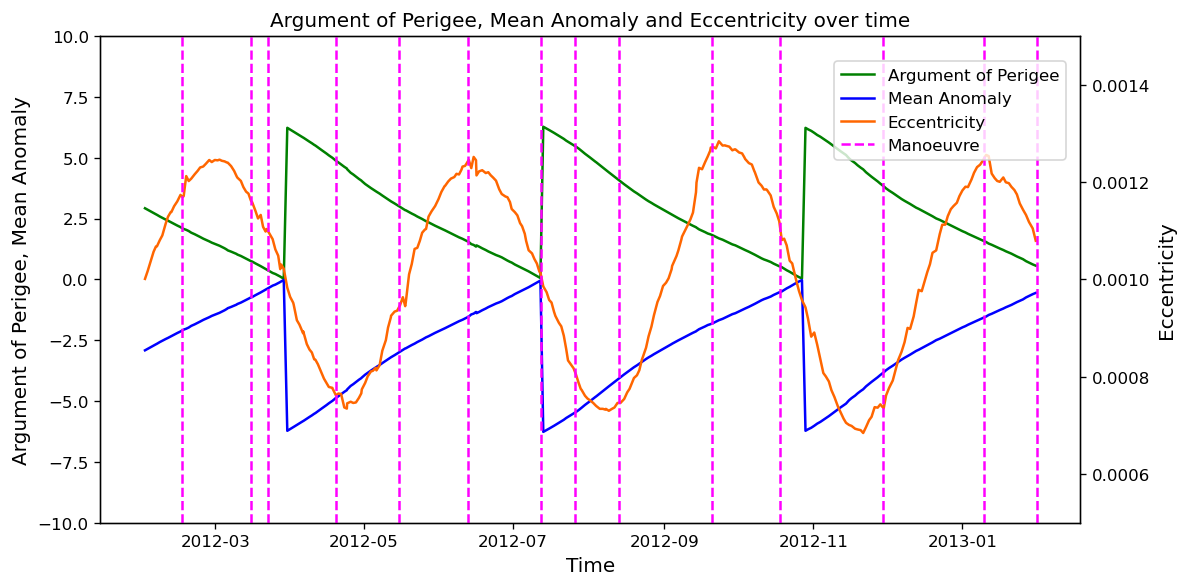

In [55]:
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)
plt.rcParams.update({'figure.figsize':(8,4), 'figure.dpi':120})

pd_df_Cryo_UnProp['TimeStamp'] = pd.to_datetime(pd_df_Cryo_UnProp['TimeStamp'])
pd_df_Cryo_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Cryo_GrdTrth['Start Date'])

# Define the start and end date for the filter
start_date = '2012-02-01'
end_date = '2013-02-01'

# Filter the DataFrame for rows where 'TimeStamp' is within the first few months of 2012
subset = pd_df_Cryo_UnProp[
    (pd_df_Cryo_UnProp['TimeStamp'] >= start_date) &
    (pd_df_Cryo_UnProp['TimeStamp'] <= end_date)]
GrdTrth = pd_df_Cryo_GrdTrth[
    (pd_df_Cryo_GrdTrth['Start Date'] >= start_date) &
    (pd_df_Cryo_GrdTrth['Start Date'] <= end_date)]

# plot forecasts against actual outcomes
x=subset['TimeStamp']
y1=subset['Argument of Perigee']
y2=subset['Mean Anomaly']
y3=subset['Eccentricity']

fig, ax = plt.subplots(figsize = (10,5))
plt.title('Argument of Perigee, Mean Anomaly and Eccentricity over time')
 
ax2 = ax.twinx()
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))

xcoords = GrdTrth['Start Date']
for xc in xcoords:
    plt.axvline(x=xc, color='magenta', label="Manoeuvre", linestyle='dashed')
 
ax.set_xlabel('Time')
ax.set_ylabel('Argument of Perigee, Mean Anomaly')
ax2.set_ylabel('Eccentricity')

ax.set_ylim(-10, 10)
ax2.set_ylim(0.0005, 0.0015)
 
plt.tight_layout()
fig.legend(['Argument of Perigee', 'Mean Anomaly', 'Eccentricity','Manoeuvre'], loc='upper right', bbox_to_anchor=(0.9, 0.9))
 
# show plot
plt.show()

C:\Users\aloci\AppData\Local\Temp\ipykernel_8376\2404490841.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df_Cryo_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Cryo_GrdTrth['Start Date'])


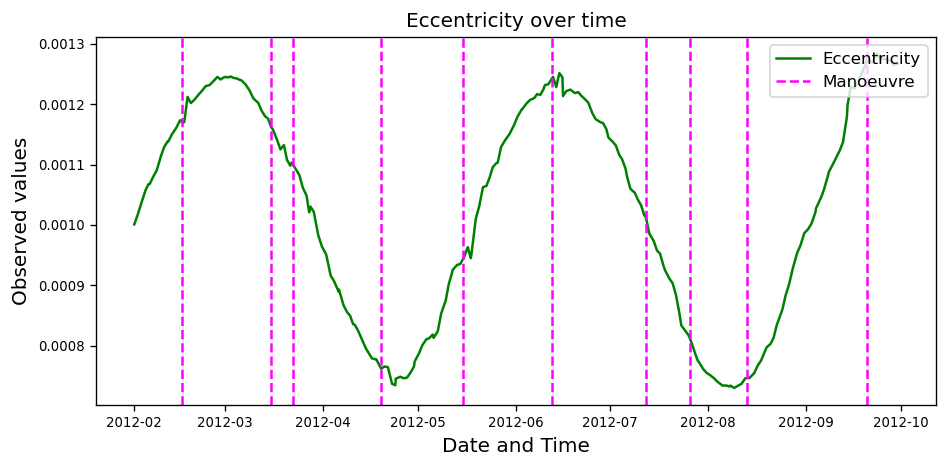

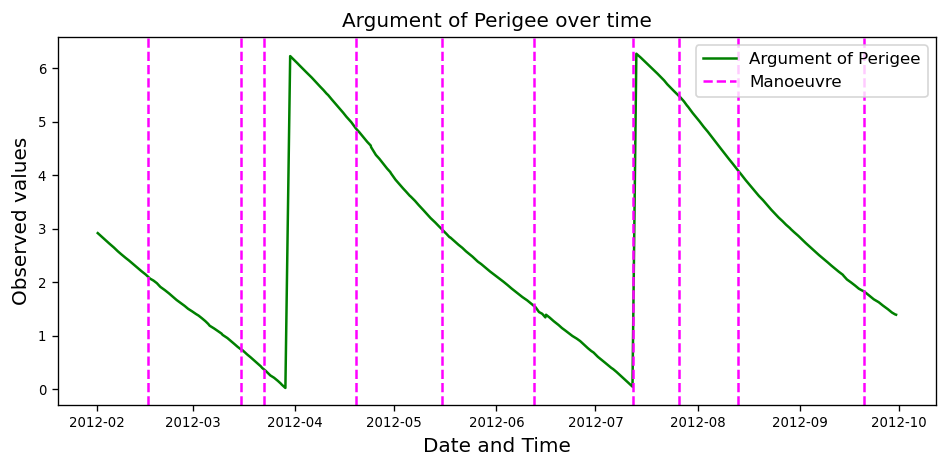

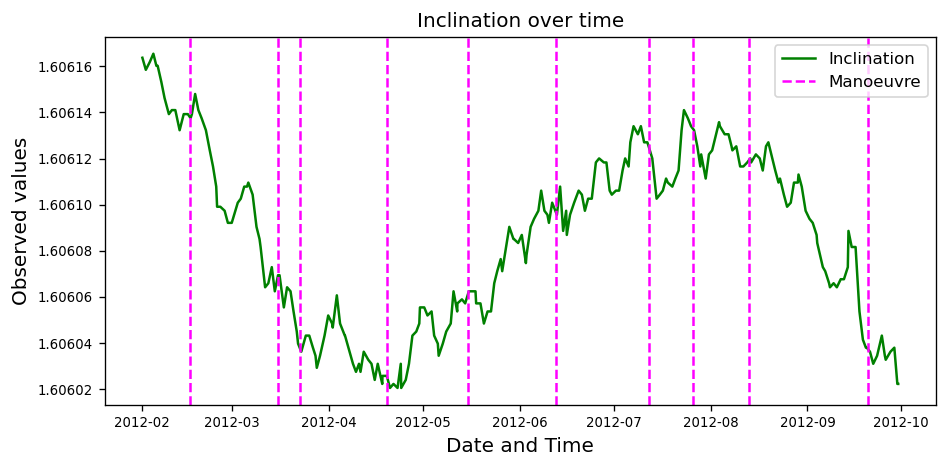

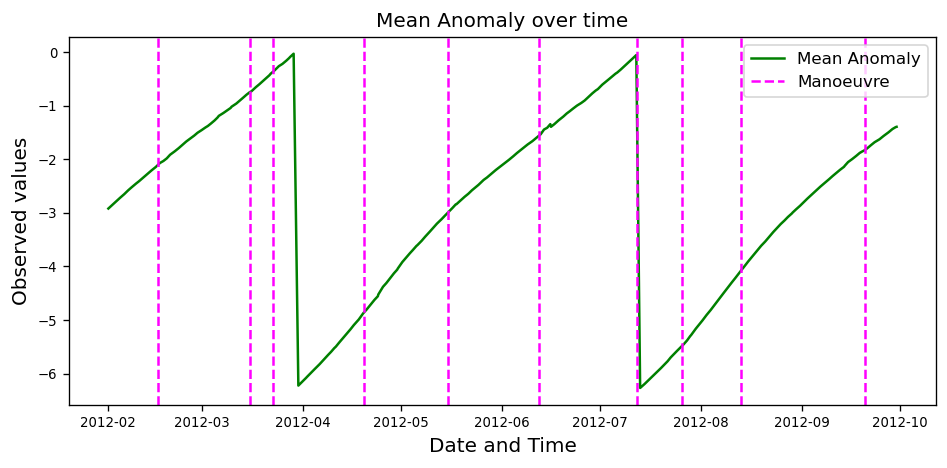

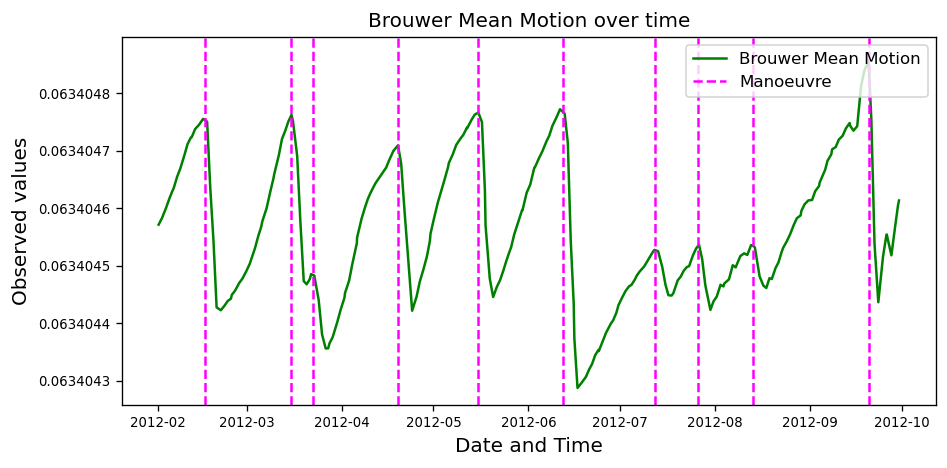

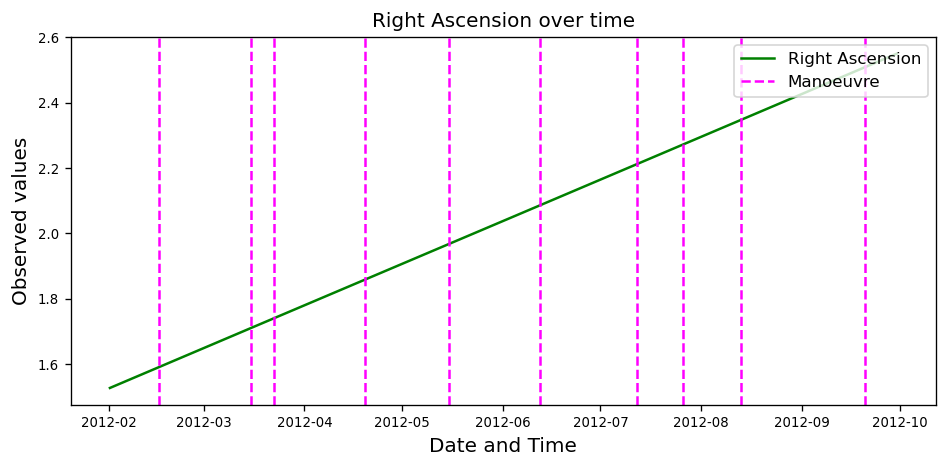

In [58]:
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
plt.rcParams.update({'figure.figsize':(8,4), 'figure.dpi':120})


pd_df_Cryo_UnProp['TimeStamp'] = pd.to_datetime(pd_df_Cryo_UnProp['TimeStamp'])
pd_df_Cryo_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Cryo_GrdTrth['Start Date'])

# Define the start and end date for the filter
start_date = '2012-02-01'
end_date = '2012-10-01'

# Filter the DataFrame for rows where 'TimeStamp' is within the first few months of 2012
subset = pd_df_Cryo_UnProp[
    (pd_df_Cryo_UnProp['TimeStamp'] >= start_date) &
    (pd_df_Cryo_UnProp['TimeStamp'] <= end_date)]
GrdTrth = pd_df_Cryo_GrdTrth[
    (pd_df_Cryo_GrdTrth['Start Date'] >= start_date) &
    (pd_df_Cryo_GrdTrth['Start Date'] <= end_date)]

for Feature in pd_df_Cryo_UnProp.columns:
    if Feature != 'TimeStamp':
        x = subset['TimeStamp']
        y1 = subset[Feature]

        plt.figure()
        plt.title(Feature + ' over time')
        plt.plot(x, y1, color='green')

        xcoords = GrdTrth['Start Date']
        for xc in xcoords:
            plt.axvline(x=xc, color='magenta', label="Manoeuvre", linestyle='dashed')

        plt.ylabel('Observed values')
        plt.xlabel('Date and Time')
        
        ax = plt.gca()
        formatter = ScalarFormatter(useOffset=False)
        formatter.set_scientific(False)
        ax.yaxis.set_major_formatter(formatter)

        plt.tight_layout()
        plt.legend([Feature, 'Manoeuvre'], loc='upper right')


        # Show plot
        plt.show()



## 2.3 Prepare individual dataframes per element

                   TimeStamp  Brouwer Mean Motion
0 2010-04-25 12:13:31.467936             3.558054
1 2010-04-26 13:01:57.579456             3.701827
2 2010-04-27 22:06:32.422176             3.948957
3 2010-04-28 12:59:36.035519             4.094361
4 2010-04-29 00:34:12.213407             4.232176


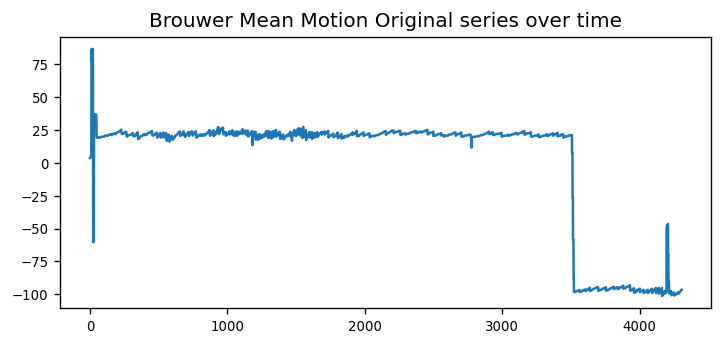

In [63]:
# Scale ['Brouwer mean motion'] to larger numbers
pd_df_Cryo_bmm=pd_df_Cryo_UnProp_train[['TimeStamp', 'Brouwer Mean Motion']]

pd_df_Cryo_bmm['Brouwer Mean Motion'] = (pd_df_Cryo_bmm['Brouwer Mean Motion'] - pd_df_Cryo_bmm['Brouwer Mean Motion'].mean()) * 10000000
print(pd_df_Cryo_bmm.head())

plt.rcParams.update({'figure.figsize':(7,3), 'figure.dpi':120})
plt.plot(pd_df_Cryo_bmm['Brouwer Mean Motion'])
plt.title('Brouwer Mean Motion Original series over time')
plt.show()

                   TimeStamp  Eccentricity
0 2010-04-25 12:13:31.467936      3.671897
1 2010-04-26 13:01:57.579456      3.839897
2 2010-04-27 22:06:32.422176      4.006897
3 2010-04-28 12:59:36.035519      4.093897
4 2010-04-29 00:34:12.213407      4.293897


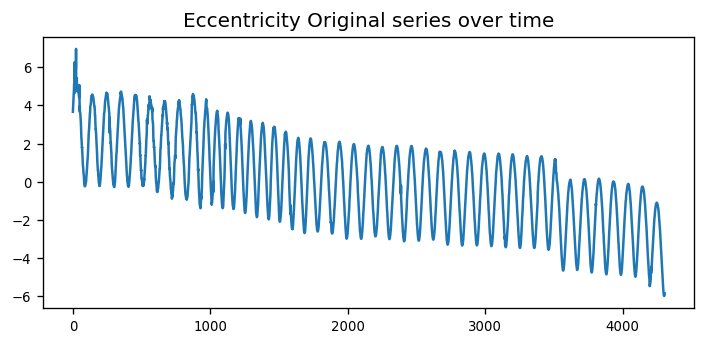

In [64]:
# Scale ['eccentricity'] to larger numbers
pd_df_Cryo_ecc=pd_df_Cryo_UnProp_train[['TimeStamp', 'Eccentricity']]

pd_df_Cryo_ecc['Eccentricity'] = (pd_df_Cryo_ecc['Eccentricity'] - pd_df_Cryo_ecc['Eccentricity'].mean()) * 10000
print(pd_df_Cryo_ecc.head())

plt.rcParams.update({'figure.figsize':(7,3), 'figure.dpi':120})
plt.plot(pd_df_Cryo_ecc['Eccentricity'])
plt.title('Eccentricity Original series over time')
plt.show()

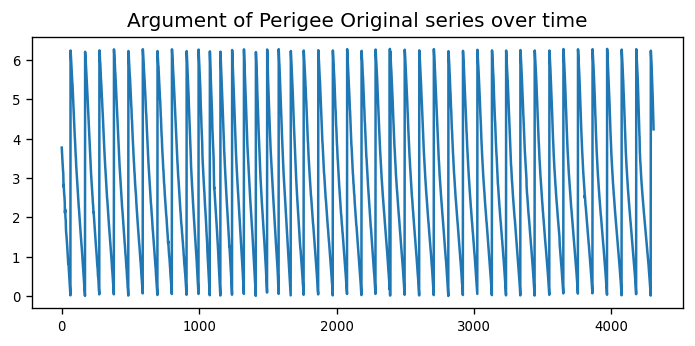

In [65]:
# Prepare ['argument of perigee'] dateframe
pd_df_Cryo_aop=pd_df_Cryo_UnProp_train[['TimeStamp', 'Argument of Perigee']]

plt.rcParams.update({'figure.figsize':(7,3), 'figure.dpi':120})
plt.plot(pd_df_Cryo_aop['Argument of Perigee'])
plt.title('Argument of Perigee Original series over time')
plt.show()

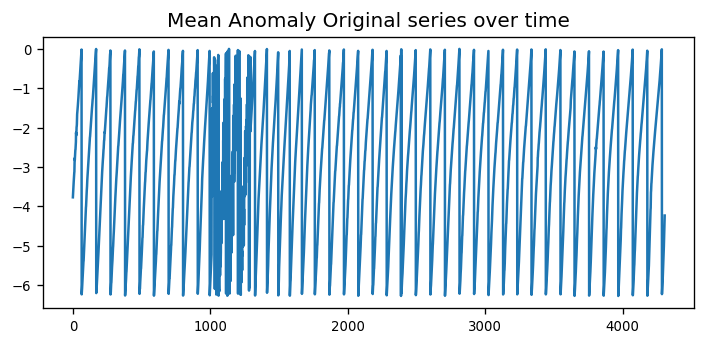

In [66]:
# Prepare ['mean anomaly'] dateframe
pd_df_Cryo_ma=pd_df_Cryo_UnProp_train[['TimeStamp', 'Mean Anomaly']]

plt.rcParams.update({'figure.figsize':(7,3), 'figure.dpi':120})
plt.plot(pd_df_Cryo_ma['Mean Anomaly'])
plt.title('Mean Anomaly Original series over time')
plt.show()

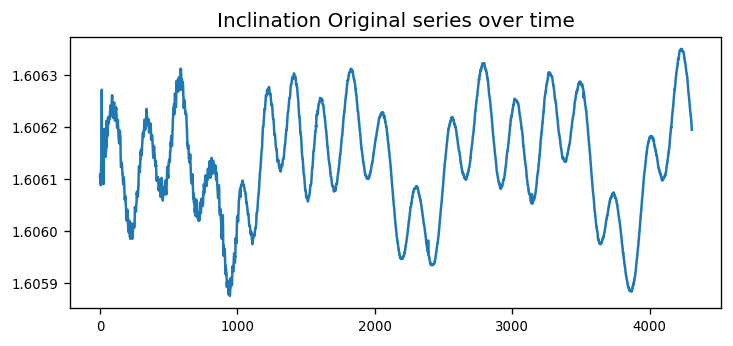

In [67]:
# Prepare ['inclination'] dateframe
pd_df_Cryo_inc=pd_df_Cryo_UnProp_train[['TimeStamp', 'Inclination']]

plt.rcParams.update({'figure.figsize':(7,3), 'figure.dpi':120})
plt.plot(pd_df_Cryo_inc['Inclination'])
plt.title('Inclination Original series over time')
plt.show()

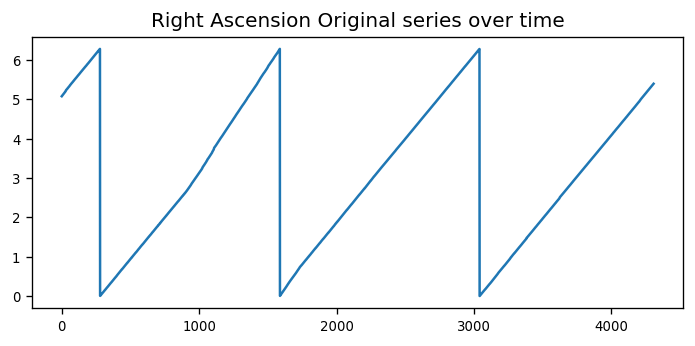

In [86]:
# Prepare ['right ascension'] dateframe
pd_df_Cryo_ra=pd_df_Cryo_UnProp_train[['TimeStamp', 'Right Ascension']]

plt.rcParams.update({'figure.figsize':(7,3), 'figure.dpi':120})
plt.plot(pd_df_Cryo_ra['Right Ascension'])
plt.title('Right Ascension Original series over time')
plt.show()

## 2.4 Test if Individual elements are stationary and determine rough p,d,q values

### 2.4.1 Test Brouwer mean motion 

#### 2.4.1.1 Test Stationarity

In [126]:
# test if pd_df_Cryo_bmm stationary time series
fuller_result = adfuller(pd_df_Cryo_bmm['Brouwer Mean Motion'])
print('ADF Statistic: %f' % fuller_result[0])
print('p-value: %f' % fuller_result[1])


ADF Statistic: -0.552207
p-value: 0.881420


p-value>0.05 therefore not stationary

The best way to find p, d, q values in R is to use auto.arima function from library(forecast). For example, auto.arima(x, ic = "aic"). For more information look up ?auto.arima.

Note that if you get a large value of p
 or d
 then this might mean that there is a trend in the data that is not easily amenable to the auto-regression and differencing in the ARIMA model, which may mean that the model is not a good model for that data. However, even if this is the case, since the MA model is a special case of the ARIMA model, that would mean that both models are performing poorly, and it would still not give a reason to prefer a moving average to the full ARIMA model.

#### 2.4.1.2 Determine Difference (d)

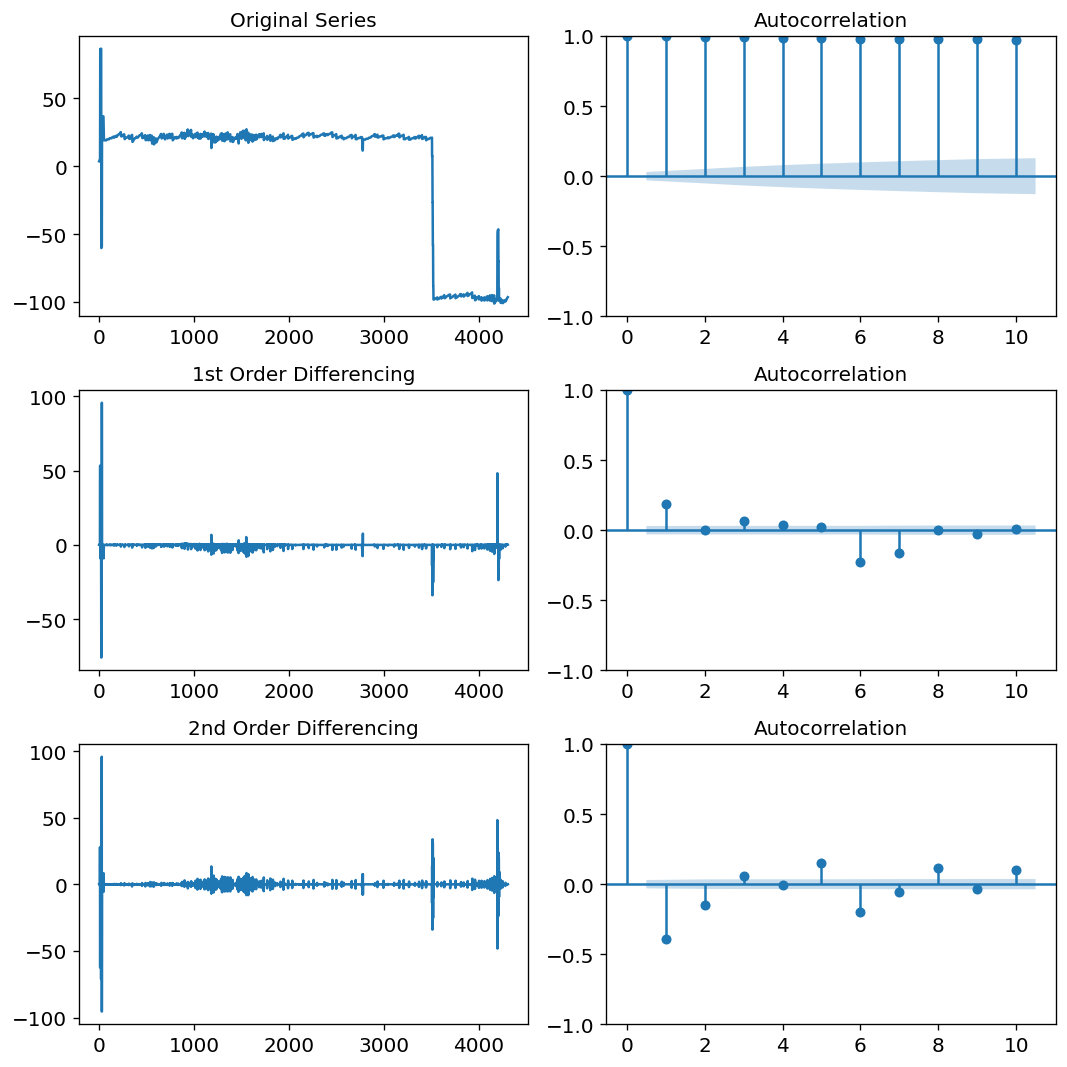

In [235]:
# Difference series until stationarity 

plt.rcParams.update({'figure.figsize':(9,9), 'figure.dpi':120})
# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(pd_df_Cryo_bmm['Brouwer Mean Motion']); axes[0, 0].set_title('Original Series')
plot_acf(pd_df_Cryo_bmm['Brouwer Mean Motion'], ax=axes[0, 1], lags = 10)

# # 1st Differencing
axes[1, 0].plot(pd_df_Cryo_bmm['Brouwer Mean Motion'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(pd_df_Cryo_bmm['Brouwer Mean Motion'].diff().dropna(), ax=axes[1, 1], lags = 10)

# # 2nd Differencing
axes[2, 0].plot(pd_df_Cryo_bmm['Brouwer Mean Motion'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(pd_df_Cryo_bmm['Brouwer Mean Motion'].diff().diff().dropna(), ax=axes[2, 1], lags = 10)

plt.tight_layout()
plt.show()


original graph shows step changes therefore not stationary even though ACF pretty flat. First order diferrencing shows values around 0 therefore stationary, but ACF is reaching negative values therefore possible over differenced. Choose d as 1 but maybe 0.

#### 2.4.1.3 Determine Regression order (p)

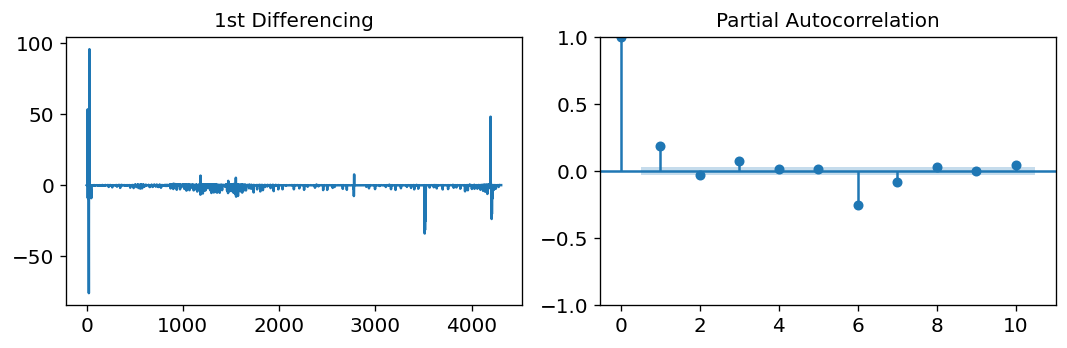

In [236]:
# check order of AR term p
# check PACF plot
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(pd_df_Cryo_bmm['Brouwer Mean Motion'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(pd_df_Cryo_bmm['Brouwer Mean Motion'].diff().dropna(), ax=axes[1], lags = 10)

plt.tight_layout()
plt.show()

PACF above significance of 0.05 after 1 differencing therefore choose p=1

#### 2.4.1.4 Determine Residual order (q)

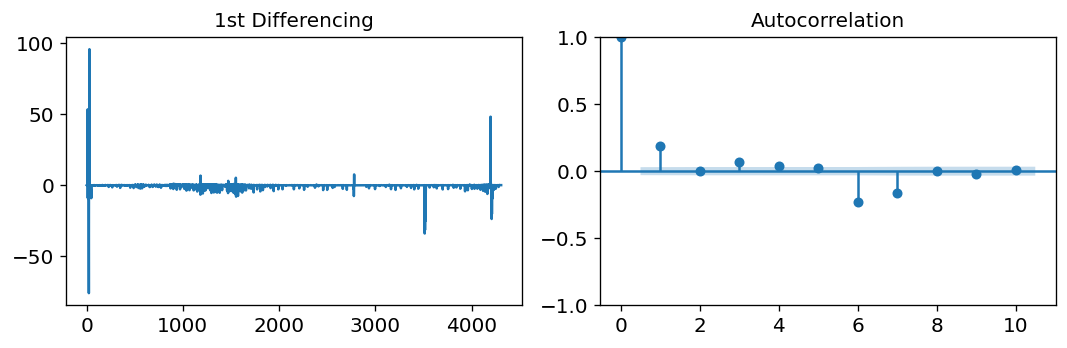

In [237]:
# check order of MA term q
# check ACF plot
# ACF plot of 1st differenced series

fig, axes = plt.subplots(1, 2)
axes[0].plot(pd_df_Cryo_bmm['Brouwer Mean Motion'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(pd_df_Cryo_bmm['Brouwer Mean Motion'].diff().dropna(), ax=axes[1], lags = 10)

plt.tight_layout()
plt.show()

not many ACF points above 0.05 so choose q=1 conservatively

### 2.4.2 Test Eccentricity

#### 2.4.2.1 Test Stationarity

In [241]:
# test if pd_df_Cryo_ecc stationary time series
fuller_result = adfuller(pd_df_Cryo_ecc['Eccentricity'])
print('ADF Statistic: %f' % fuller_result[0])
print('p-value: %f' % fuller_result[1])


ADF Statistic: -4.149340
p-value: 0.000802


p-value<0.05 therefore stationary

#### 2.4.2.2 Determine Difference (d)

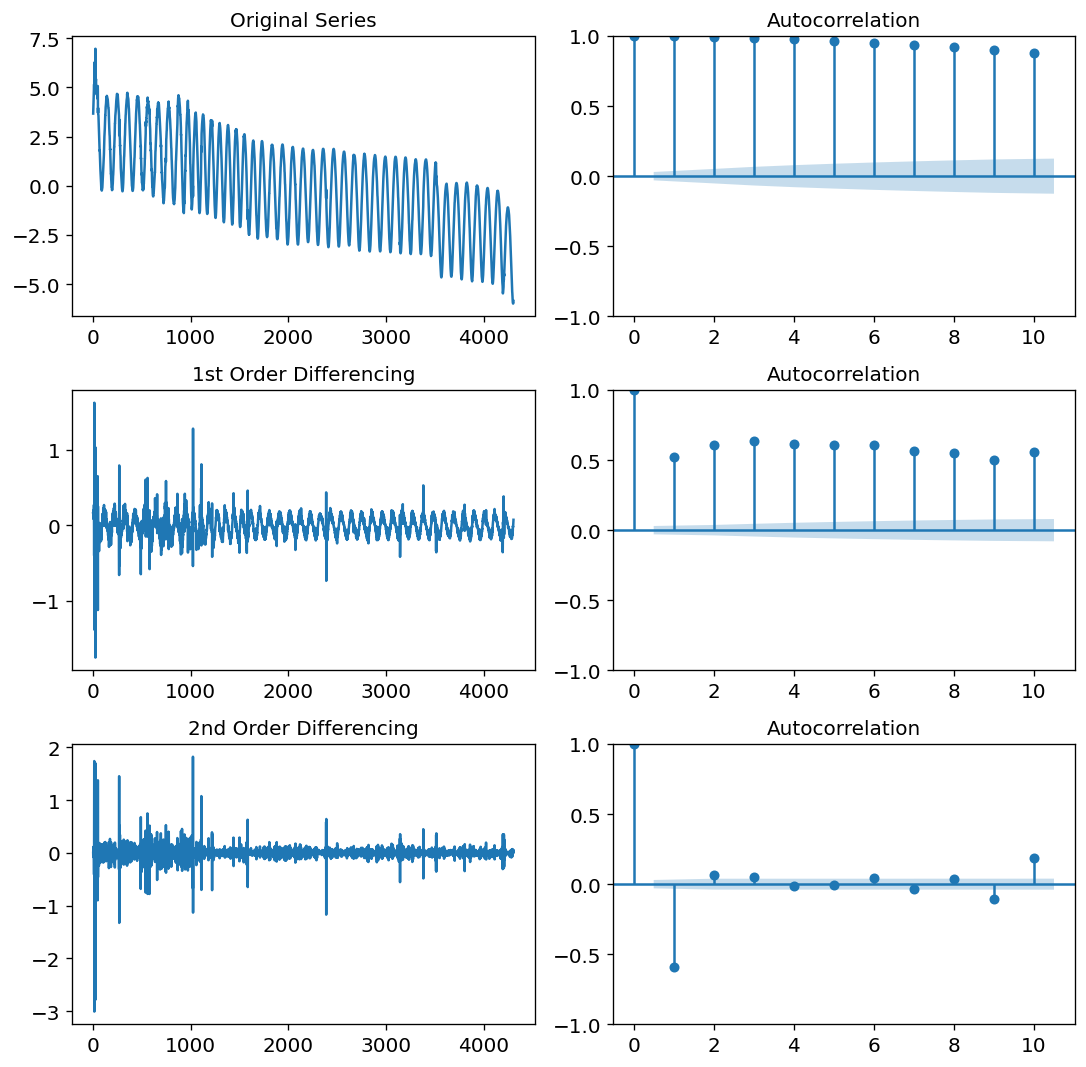

In [238]:
# Difference series until stationarity

plt.rcParams.update({'figure.figsize':(9,9), 'figure.dpi':120})
# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(pd_df_Cryo_ecc['Eccentricity']); axes[0, 0].set_title('Original Series')
plot_acf(pd_df_Cryo_ecc['Eccentricity'], ax=axes[0, 1], lags = 10)

# 1st Differencing
axes[1, 0].plot(pd_df_Cryo_ecc['Eccentricity'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(pd_df_Cryo_ecc['Eccentricity'].diff().dropna(), ax=axes[1, 1], lags = 10)

# 2nd Differencing
axes[2, 0].plot(pd_df_Cryo_ecc['Eccentricity'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(pd_df_Cryo_ecc['Eccentricity'].diff().diff().dropna(), ax=axes[2, 1], lags = 10)

plt.tight_layout()
plt.show()


Although Fuller shows a stationary time series, the actual plot of the data shows a decline and non-stationarity. The ACF plot of the data shows a very slow deline by number of lags. After first differencing the ACF plot shows a faster decline but still not within significance. however after second order differencing, the ACF value at lag 1 is sharply negative indicating over differencing. Therefore a d value of 1 will be used.

#### 2.4.2.3 Determine Regression order (p)

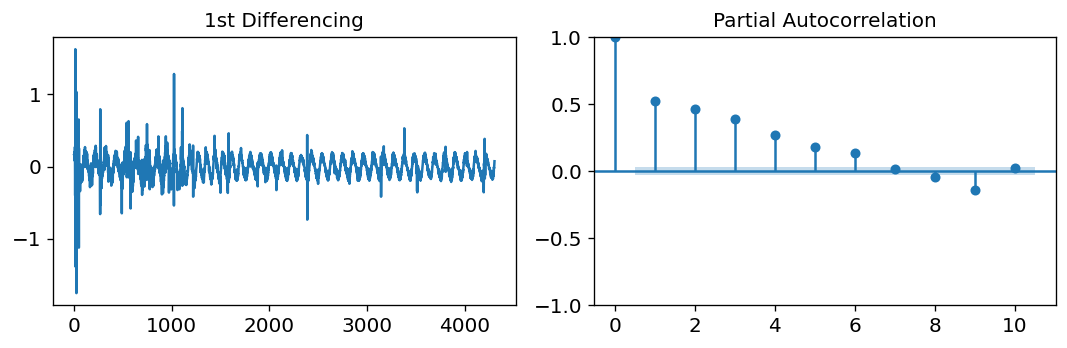

In [239]:
# check order of AR term p
# check PACF plot
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(pd_df_Cryo_ecc['Eccentricity'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(pd_df_Cryo_ecc['Eccentricity'].diff().dropna(), ax=axes[1], lags = 10)

plt.tight_layout()
plt.show()

first PACF value within significance is 7, so p=7

#### 2.4.2.4 Determine Residual order (q)

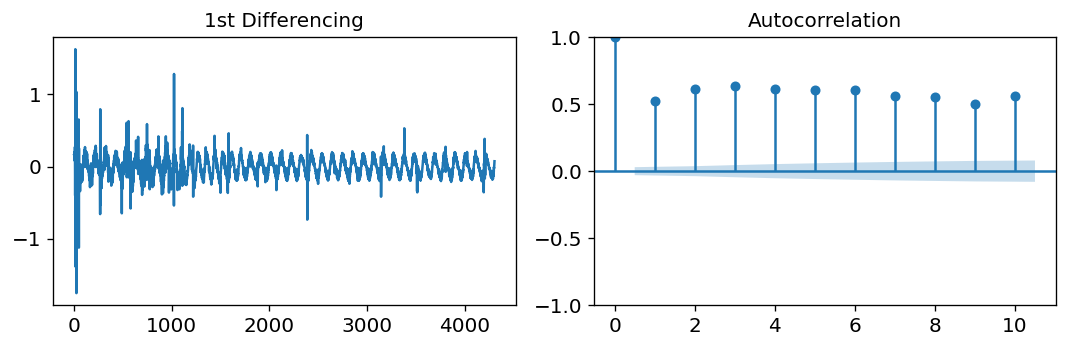

In [240]:
# check order of MA term q
# check ACF plot
# ACF plot of 1st differenced series

fig, axes = plt.subplots(1, 2)
axes[0].plot(pd_df_Cryo_ecc['Eccentricity'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(pd_df_Cryo_ecc['Eccentricity'].diff().dropna(), ax=axes[1], lags = 10)

plt.tight_layout()
plt.show()

ACF consistently high so choose q=10

high values of p and q indicate data is not well suited to arima - seasonal

### 2.4.3 Test argument of perigee

#### 2.4.3.1 Test Stationarity

In [263]:
# test if pd_df_Cryo_aop stationary time series
fuller_result = adfuller(pd_df_Cryo_aop['Argument of Perigee'])
print('ADF Statistic: %f' % fuller_result[0])
print('p-value: %f' % fuller_result[1])


ADF Statistic: -13.404203
p-value: 0.000000


p-value<0.05 therefore  stationary

#### 2.4.3.2 Determine Difference (d)

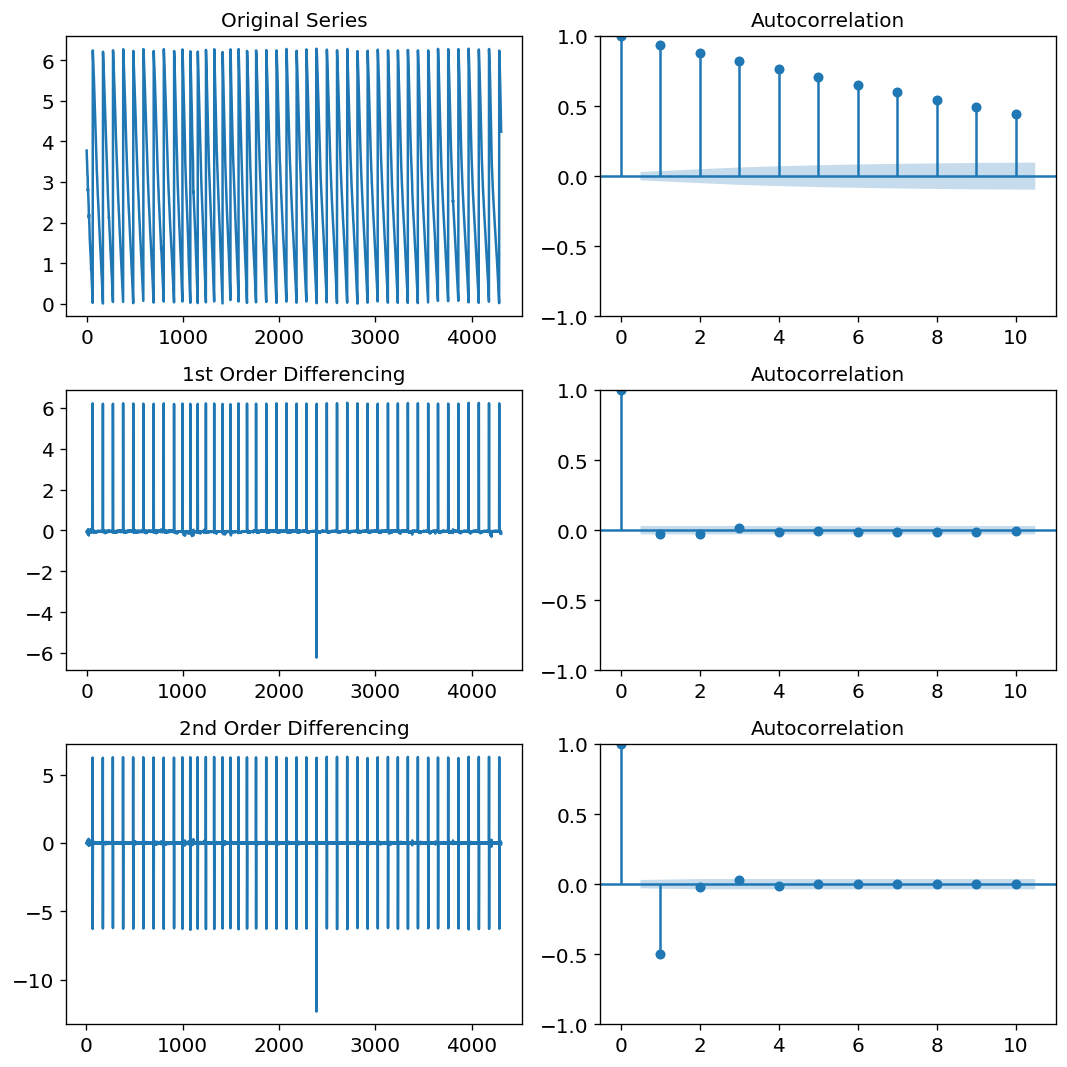

In [264]:
# Difference series until stationarity 

plt.rcParams.update({'figure.figsize':(9,9), 'figure.dpi':120})
# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(pd_df_Cryo_aop['Argument of Perigee']); axes[0, 0].set_title('Original Series')
plot_acf(pd_df_Cryo_aop['Argument of Perigee'], ax=axes[0, 1], lags = 10)

# # 1st Differencing
axes[1, 0].plot(pd_df_Cryo_aop['Argument of Perigee'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(pd_df_Cryo_aop['Argument of Perigee'].diff().dropna(), ax=axes[1, 1], lags = 10)

# # 2nd Differencing
axes[2, 0].plot(pd_df_Cryo_aop['Argument of Perigee'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(pd_df_Cryo_aop['Argument of Perigee'].diff().diff().dropna(), ax=axes[2, 1], lags = 10)

plt.tight_layout()
plt.show()


 Choose d as 1.

#### 2.4.3.3 Determine Regression order (p)

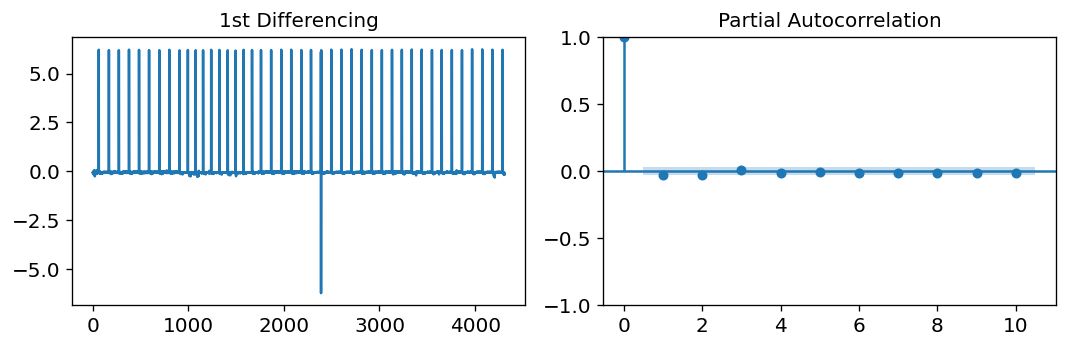

In [265]:
# check order of AR term p
# check PACF plot
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(pd_df_Cryo_aop['Argument of Perigee'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(pd_df_Cryo_aop['Argument of Perigee'].diff().dropna(), ax=axes[1], lags = 10)

plt.tight_layout()
plt.show()

PACF above significance of 0.05 after 1 differencing therefore choose p=1

#### 2.4.3.4 Determine Residual order (q)

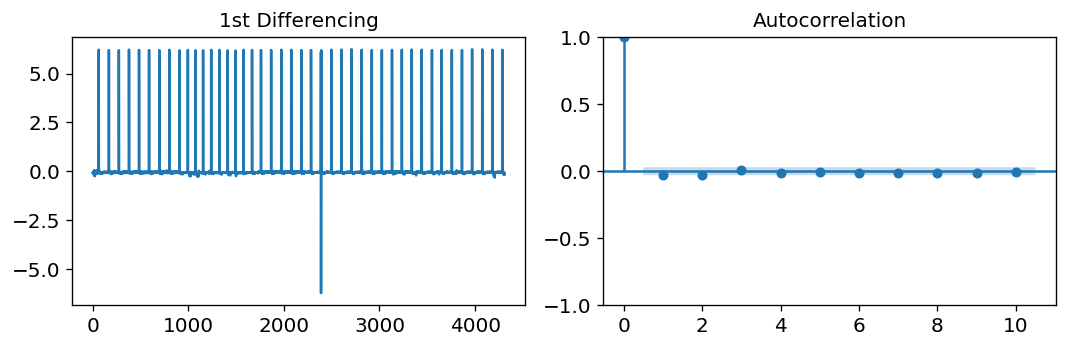

In [266]:
# check order of MA term q
# check ACF plot
# ACF plot of 1st differenced series

fig, axes = plt.subplots(1, 2)
axes[0].plot(pd_df_Cryo_aop['Argument of Perigee'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(pd_df_Cryo_aop['Argument of Perigee'].diff().dropna(), ax=axes[1], lags = 10)

plt.tight_layout()
plt.show()

not many ACF points above 0.05 so choose q=1 conservatively

### 2.4.4 Test Mean Anomaly

#### 2.4.4.1 Test Stationarity

In [8]:
# test if pd_df_Cryo_ma stationary time series
fuller_result = adfuller(pd_df_Cryo_ma['Mean Anomaly'])
print('ADF Statistic: %f' % fuller_result[0])
print('p-value: %f' % fuller_result[1])


ADF Statistic: -13.192708
p-value: 0.000000


p-value<0.05 therefore stationary

The best way to find p, d, q values in R is to use auto.arima function from library(forecast). For example, auto.arima(x, ic = "aic"). For more information look up ?auto.arima.

Note that if you get a large value of p
 or d
 then this might mean that there is a trend in the data that is not easily amenable to the auto-regression and differencing in the ARIMA model, which may mean that the model is not a good model for that data. However, even if this is the case, since the MA model is a special case of the ARIMA model, that would mean that both models are performing poorly, and it would still not give a reason to prefer a moving average to the full ARIMA model.

#### 2.4.4.2 Determine Difference (d)

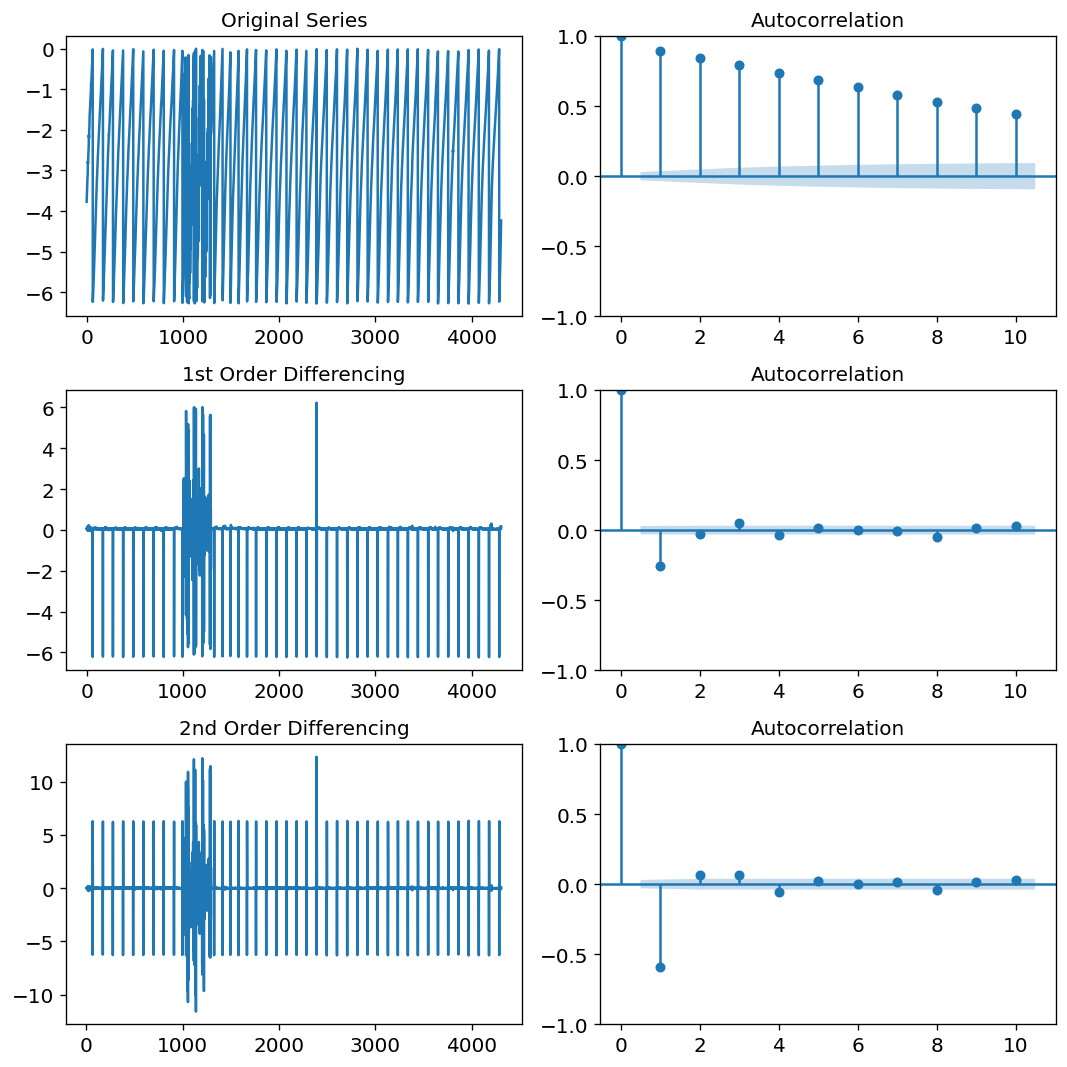

In [9]:
# Difference series until stationarity 

plt.rcParams.update({'figure.figsize':(9,9), 'figure.dpi':120})
# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(pd_df_Cryo_ma['Mean Anomaly']); axes[0, 0].set_title('Original Series')
plot_acf(pd_df_Cryo_ma['Mean Anomaly'], ax=axes[0, 1], lags = 10)

# # 1st Differencing
axes[1, 0].plot(pd_df_Cryo_ma['Mean Anomaly'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(pd_df_Cryo_ma['Mean Anomaly'].diff().dropna(), ax=axes[1, 1], lags = 10)

# # 2nd Differencing
axes[2, 0].plot(pd_df_Cryo_ma['Mean Anomaly'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(pd_df_Cryo_ma['Mean Anomaly'].diff().diff().dropna(), ax=axes[2, 1], lags = 10)

plt.tight_layout()
plt.show()


original graph shows step changes therefore not stationary even though ACF pretty flat. First order diferrencing shows values around 0 therefore stationary, but ACF is reaching negative values therefore possible over differenced. Choose d as 1 but maybe 0.

#### 2.4.4.3 Determine Regression order (p)

C:\Users\aloci\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


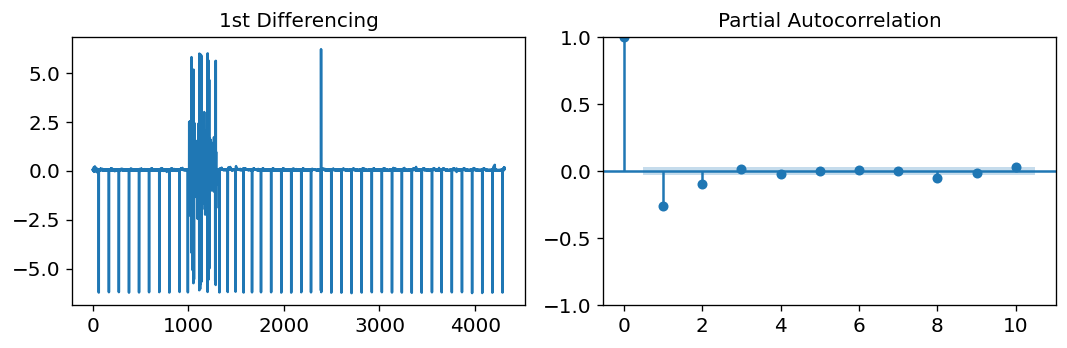

In [10]:
# check order of AR term p
# check PACF plot
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(pd_df_Cryo_ma['Mean Anomaly'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(pd_df_Cryo_ma['Mean Anomaly'].diff().dropna(), ax=axes[1], lags = 10)

plt.tight_layout()
plt.show()

 choose p=1

#### 2.4.4.4 Determine Residual order (q)

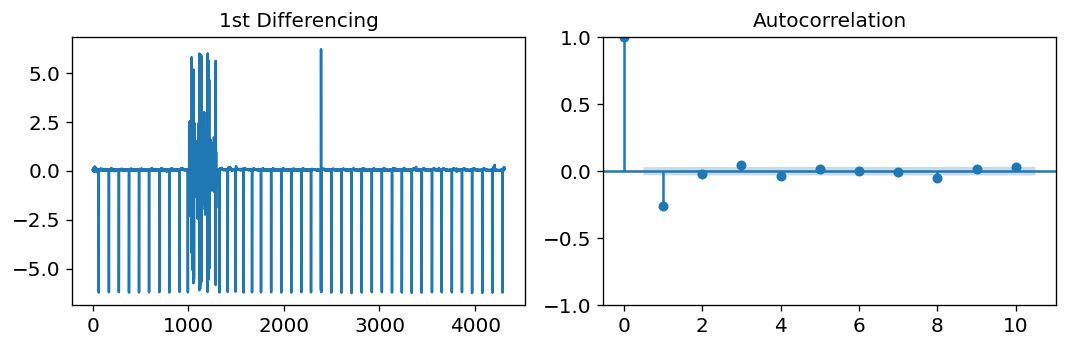

In [11]:
# check order of MA term q
# check ACF plot
# ACF plot of 1st differenced series

fig, axes = plt.subplots(1, 2)
axes[0].plot(pd_df_Cryo_ma['Mean Anomaly'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(pd_df_Cryo_ma['Mean Anomaly'].diff().dropna(), ax=axes[1], lags = 10)

plt.tight_layout()
plt.show()

not many ACF points above 0.05 so choose q=1 conservatively

### 2.4.5 Test Inclination

#### 2.4.5.1 Test Stationarity

In [26]:
# test if pd_df_Cryo_inc stationary time series
fuller_result = adfuller(pd_df_Cryo_inc['Inclination'])
print('ADF Statistic: %f' % fuller_result[0])
print('p-value: %f' % fuller_result[1])


ADF Statistic: -11.329751
p-value: 0.000000


p-value<0.05 therefore stationary

The best way to find p, d, q values in R is to use auto.arima function from library(forecast). For example, auto.arima(x, ic = "aic"). For more information look up ?auto.arima.

Note that if you get a large value of p
 or d
 then this might mean that there is a trend in the data that is not easily amenable to the auto-regression and differencing in the ARIMA model, which may mean that the model is not a good model for that data. However, even if this is the case, since the MA model is a special case of the ARIMA model, that would mean that both models are performing poorly, and it would still not give a reason to prefer a moving average to the full ARIMA model.

#### 2.4.5.2 Determine Difference (d)

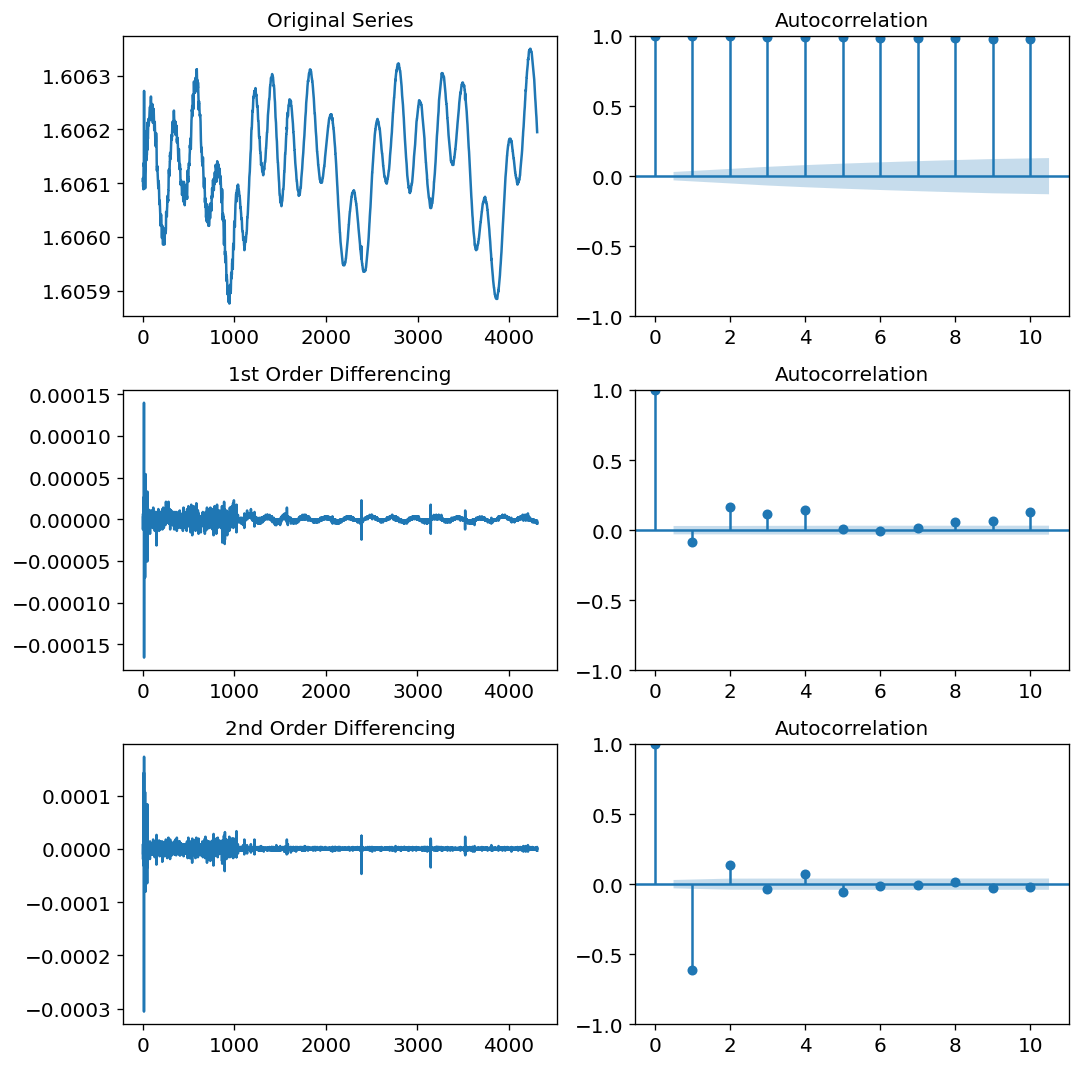

In [27]:
# Difference series until stationarity 

plt.rcParams.update({'figure.figsize':(9,9), 'figure.dpi':120})
# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(pd_df_Cryo_inc['Inclination']); axes[0, 0].set_title('Original Series')
plot_acf(pd_df_Cryo_inc['Inclination'], ax=axes[0, 1], lags = 10)

# # 1st Differencing
axes[1, 0].plot(pd_df_Cryo_inc['Inclination'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(pd_df_Cryo_inc['Inclination'].diff().dropna(), ax=axes[1, 1], lags = 10)

# # 2nd Differencing
axes[2, 0].plot(pd_df_Cryo_inc['Inclination'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(pd_df_Cryo_inc['Inclination'].diff().diff().dropna(), ax=axes[2, 1], lags = 10)

plt.tight_layout()
plt.show()


original graph shows step changes therefore not stationary even though ACF pretty flat. First order diferrencing shows values around 0 therefore stationary, but ACF is reaching negative values therefore possible over differenced. Choose d as 1 but maybe 0.

#### 2.4.5.3 Determine Regression order (p)

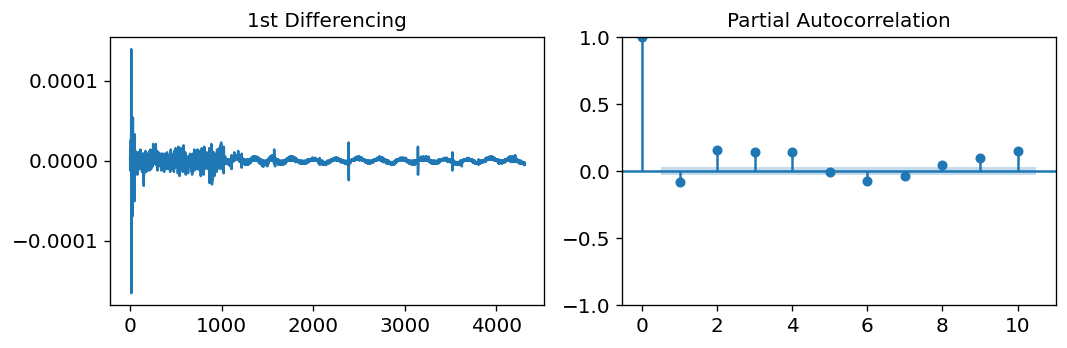

In [28]:
# check order of AR term p
# check PACF plot
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(pd_df_Cryo_inc['Inclination'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(pd_df_Cryo_inc['Inclination'].diff().dropna(), ax=axes[1], lags = 10)

plt.tight_layout()
plt.show()

 choose p=1

#### 2.4.5.4 Determine Residual order (q)

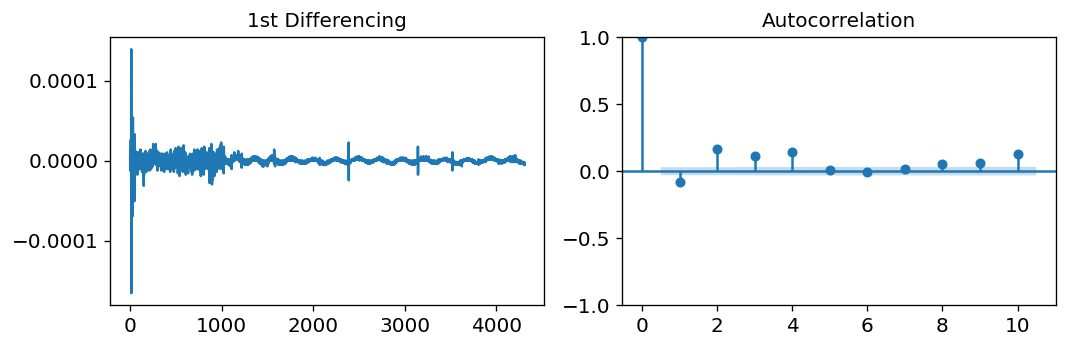

In [29]:
# check order of MA term q
# check ACF plot
# ACF plot of 1st differenced series

fig, axes = plt.subplots(1, 2)
axes[0].plot(pd_df_Cryo_inc['Inclination'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(pd_df_Cryo_inc['Inclination'].diff().dropna(), ax=axes[1], lags = 10)

plt.tight_layout()
plt.show()

not many ACF points above 0.05 so choose q=1 conservatively

### 2.4.6 Test Right Ascension

#### 2.4.6.1 Test Stationarity

In [35]:
# test if pd_df_Cryo_ra stationary time series
fuller_result = adfuller(pd_df_Cryo_ra['Right Ascension'])
print('ADF Statistic: %f' % fuller_result[0])
print('p-value: %f' % fuller_result[1])


ADF Statistic: -2.963956
p-value: 0.038400


p-value<0.05 therefore stationary

#### 2.4.6.2 Determine Difference (d)

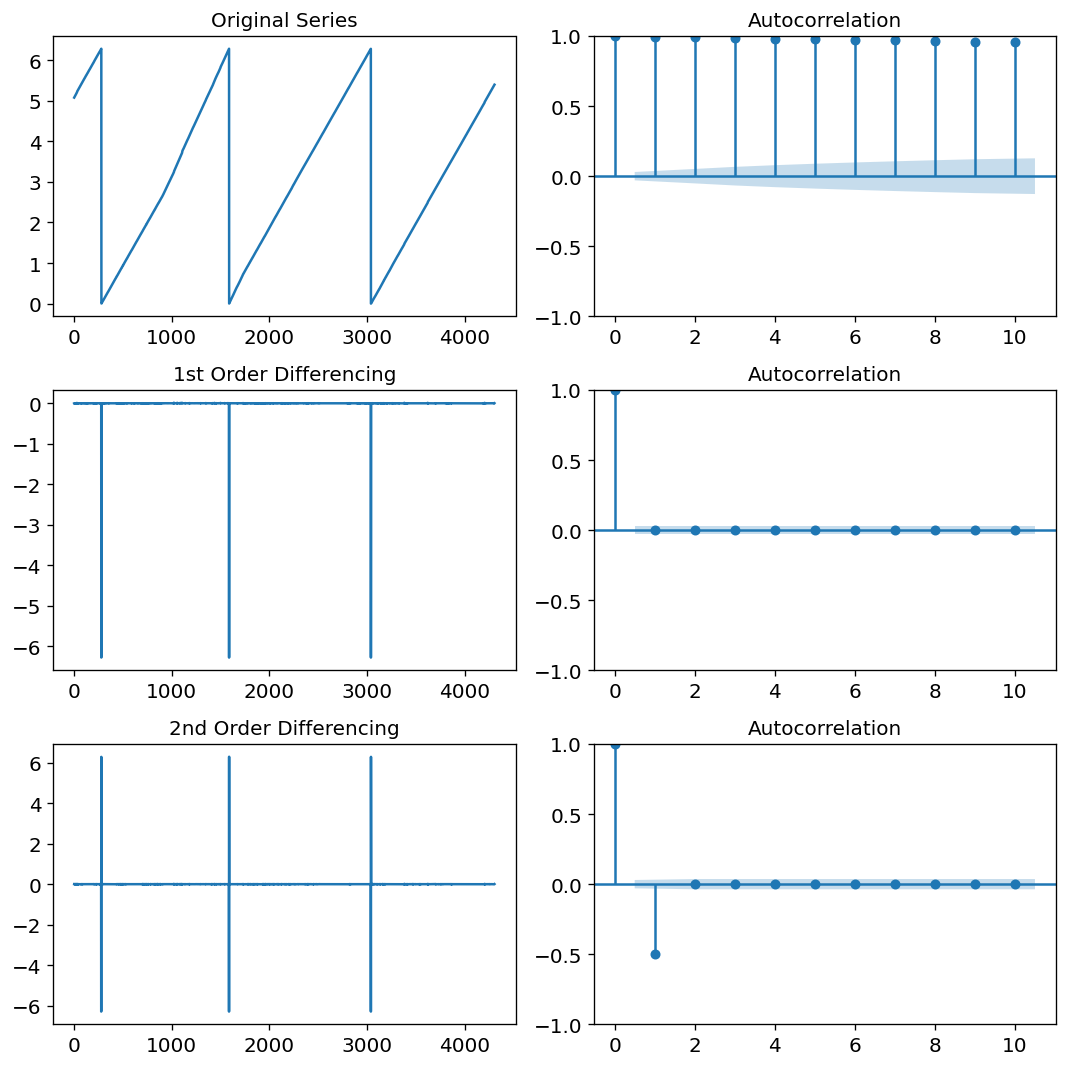

In [36]:
# Difference series until stationarity

plt.rcParams.update({'figure.figsize':(9,9), 'figure.dpi':120})
# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(pd_df_Cryo_ra['Right Ascension']); axes[0, 0].set_title('Original Series')
plot_acf(pd_df_Cryo_ra['Right Ascension'], ax=axes[0, 1], lags = 10)

# 1st Differencing
axes[1, 0].plot(pd_df_Cryo_ra['Right Ascension'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(pd_df_Cryo_ra['Right Ascension'].diff().dropna(), ax=axes[1, 1], lags = 10)

# 2nd Differencing
axes[2, 0].plot(pd_df_Cryo_ra['Right Ascension'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(pd_df_Cryo_ra['Right Ascension'].diff().diff().dropna(), ax=axes[2, 1], lags = 10)

plt.tight_layout()
plt.show()


Although Fuller shows a stationary time series, the actual plot of the data shows a decline and non-stationarity. The ACF plot of the data shows a very slow deline by number of lags. After first differencing the ACF plot shows a faster decline but still not within significance. however after second order differencing, the ACF value at lag 1 is sharply negative indicating over differencing. Therefore a d value of 1 will be used.

#### 2.4.6.3 Determine Regression order (p)

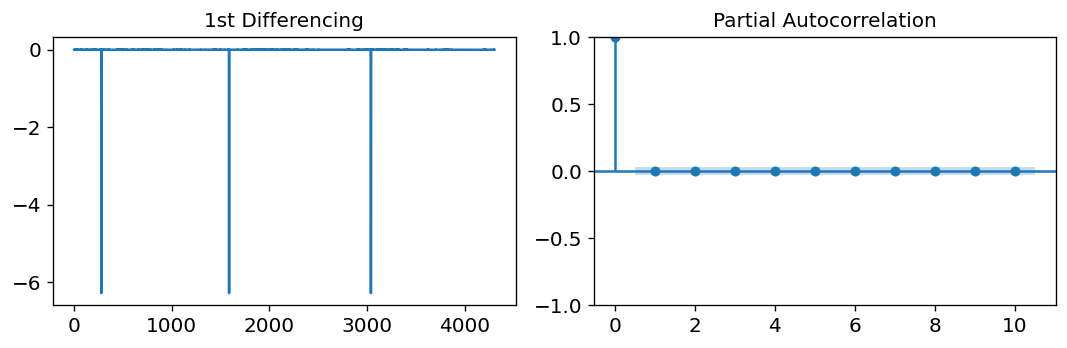

In [37]:
# check order of AR term p
# check PACF plot
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(pd_df_Cryo_ra['Right Ascension'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(pd_df_Cryo_ra['Right Ascension'].diff().dropna(), ax=axes[1], lags = 10)

plt.tight_layout()
plt.show()

first PACF value within significance is 1, so p=1

#### 2.4.6.4 Determine Residual order (q)

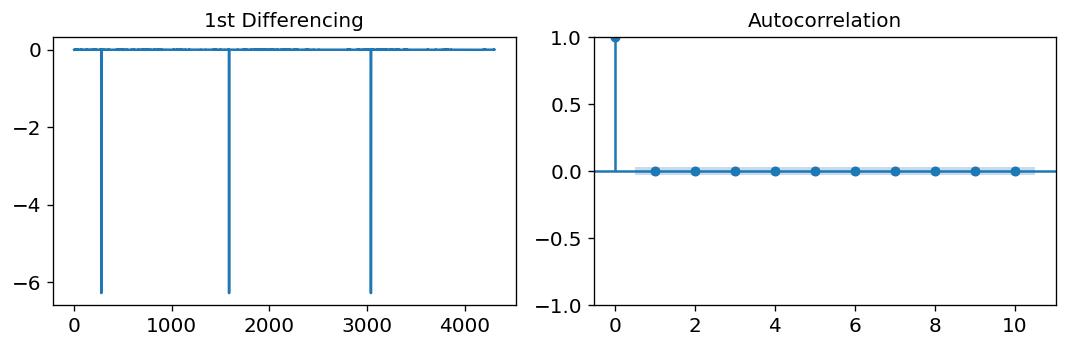

In [38]:
# check order of MA term q
# check ACF plot
# ACF plot of 1st differenced series

fig, axes = plt.subplots(1, 2)
axes[0].plot(pd_df_Cryo_ra['Right Ascension'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(pd_df_Cryo_ra['Right Ascension'].diff().dropna(), ax=axes[1], lags = 10)

plt.tight_layout()
plt.show()

 choose q=1

## 2.5 Propagate elements

In [210]:
(pd_df_Cryo_bmm_Arima_pred,dec_Cryo_bmm_Arima_pred_RMSE, dec_Cryo_bmm_Arima_pred_AIC, dec_Cryo_bmm_Arima_pred_BIC
)=Fit_Predict_Arima(pd_df_Cryo_bmm,'Brouwer Mean Motion',1,1,1)


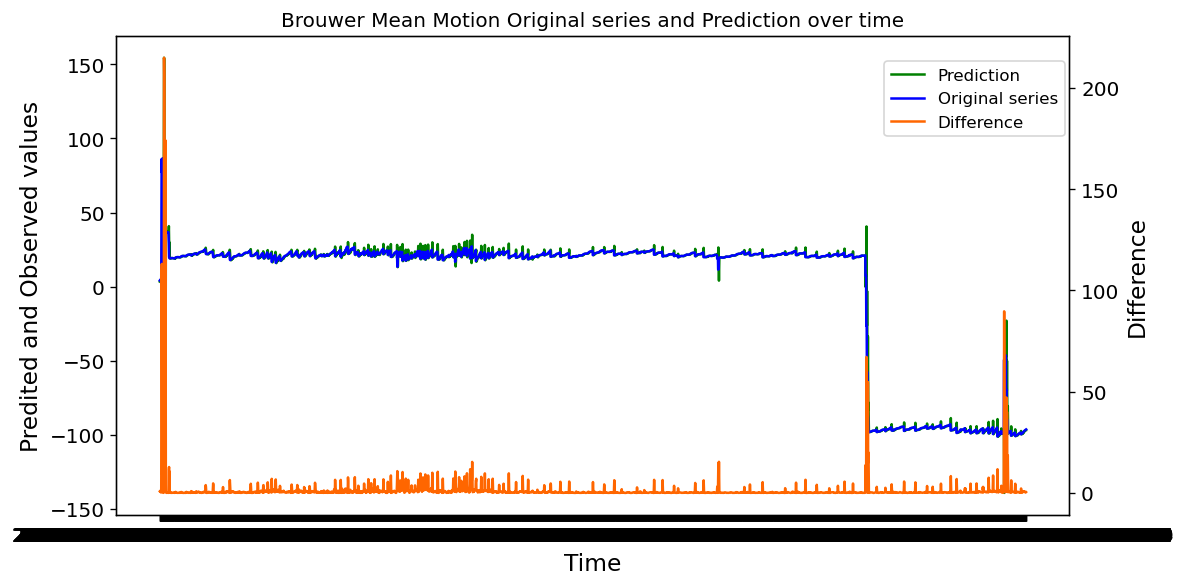

In [8]:
# evaluate forecasts
# pd_df_Cryo_bmm_Arima_pred['Difference']=abs(pd_df_Cryo_bmm_Arima_pred['Prediction']-pd_df_Cryo_bmm_Arima_pred['Observed'])
# print('RMSE: %.3f' % dec_Cryo_bmm_Arima_pred_RMSE)
# print('AIC: %.3f' % dec_Cryo_bmm_Arima_pred_AIC)
# print('BIC: %.3f' % dec_Cryo_bmm_Arima_pred_BIC)

# pd_df_Cryo_GrdTrth=data[['Satellite','Start Date','End Date']]

# plot forecasts against actual outcomes
x=pd_df_Cryo_bmm_Arima_pred['TimeStamp']
y1=pd_df_Cryo_bmm_Arima_pred['Prediction']
y2=pd_df_Cryo_bmm_Arima_pred['Observed']
y3=pd_df_Cryo_bmm_Arima_pred['Difference']

fig, ax = plt.subplots(figsize = (10, 5))
plt.title('Brouwer Mean Motion Original series and Prediction over time')
 
ax2 = ax.twinx()
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))
 
ax.set_xlabel('Time')
ax.set_ylabel('Predited and Observed values')
ax2.set_ylabel('Difference')
 
plt.tight_layout()
fig.legend(['Prediction','Original series','Difference'], loc='upper right', bbox_to_anchor=(0.9, 0.9))
 
# show plot
plt.show()


C:\Users\aloci\AppData\Local\Temp\ipykernel_4888\296342253.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df_Cryo_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Cryo_GrdTrth['Start Date'])


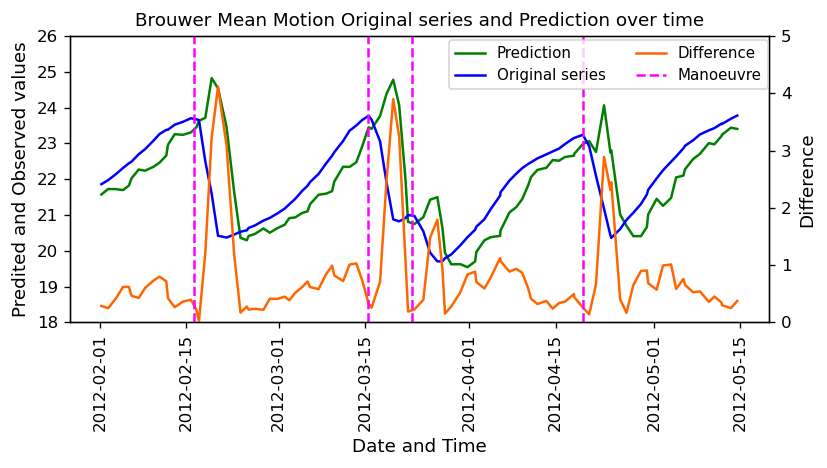

In [56]:
pd_df_Cryo_bmm_Arima_pred['TimeStamp'] = pd.to_datetime(pd_df_Cryo_bmm_Arima_pred['TimeStamp'])
pd_df_Cryo_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Cryo_GrdTrth['Start Date'])

# Define the start and end date for the filter
start_date = '2012-02-01'
end_date = '2012-05-15'

# Filter the DataFrame for rows where 'TimeStamp' is within the first few months of 2012
subset = pd_df_Cryo_bmm_Arima_pred[
    (pd_df_Cryo_bmm_Arima_pred['TimeStamp'] >= start_date) &
    (pd_df_Cryo_bmm_Arima_pred['TimeStamp'] <= end_date)]
GrdTrth = pd_df_Cryo_GrdTrth[
    (pd_df_Cryo_GrdTrth['Start Date'] >= start_date) &
    (pd_df_Cryo_GrdTrth['Start Date'] <= end_date)]

# plot forecasts against actual outcomes
x=subset['TimeStamp']
y1=subset['Prediction']
y2=subset['Observed']
y3=subset['Difference']

fig, ax = plt.subplots(figsize = (7, 4))
plt.title('Brouwer Mean Motion Original series and Prediction over time', fontsize = 11)

ax.tick_params(axis='x', labelrotation=90, labelsize=10)
ax.tick_params(axis='y', labelsize=10)

ax2 = ax.twinx()
ax2.tick_params(axis='y', labelsize=10)
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))

xcoords = GrdTrth['Start Date']
for xc in xcoords:
    plt.axvline(x=xc,color='magenta',label="Manoeuvre",linestyle='dashed')
 
ax.set_xlabel('Date and Time', fontsize = 11)
ax.set_ylabel('Predited and Observed values', fontsize = 11)
ax2.set_ylabel('Difference', fontsize = 11)

ax.set_ylim(18, 26)
ax2.set_ylim(0, 5)

plt.tight_layout()
fig.legend(['Prediction','Original series','Difference','Manoeuvre'], loc='upper right', 
           bbox_to_anchor=(0.93, 0.92), fontsize = 9, ncol=2)
 
# show plot
plt.show()

In [214]:
(pd_df_Cryo_ecc_Arima_pred,dec_Cryo_ecc_Arima_pred_RMSE, dec_Cryo_ecc_Arima_pred_AIC, dec_Cryo_ecc_Arima_pred_BIC
)=Fit_Predict_Arima(pd_df_Cryo_ecc,'Eccentricity',1,1,1)


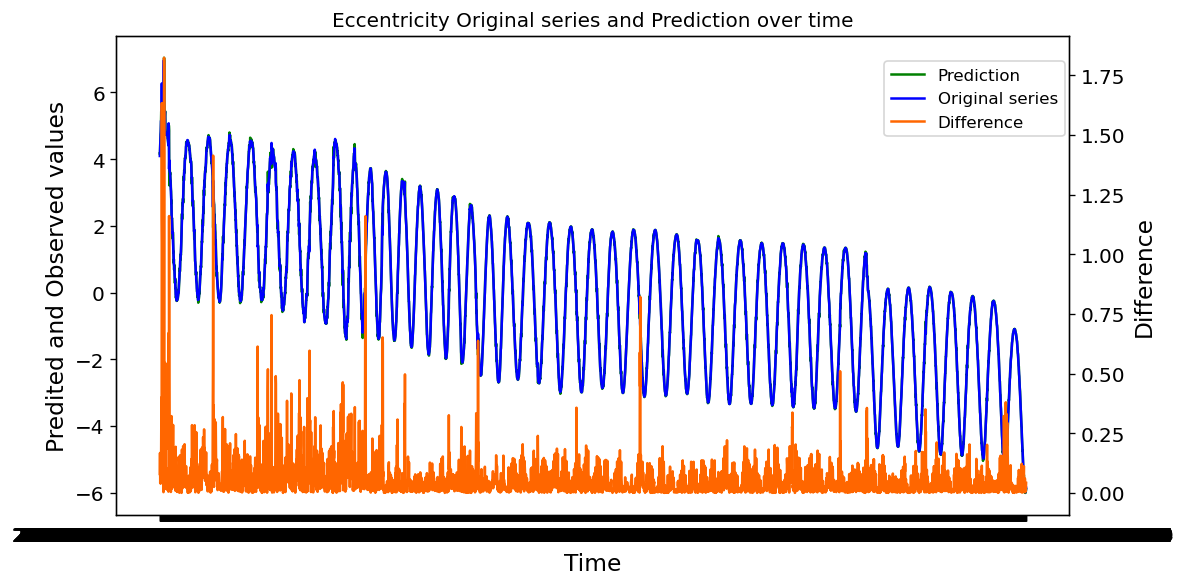

In [14]:
# evaluate forecasts
# pd_df_Cryo_ecc_Arima_pred['Difference']=abs(pd_df_Cryo_ecc_Arima_pred['Prediction']-pd_df_Cryo_ecc_Arima_pred['Observed'])
# print('RMSE: %.3f' % dec_Cryo_ecc_Arima_pred_RMSE)
# print('AIC: %.3f' % dec_Cryo_ecc_Arima_pred_AIC)
# print('BIC: %.3f' % dec_Cryo_ecc_Arima_pred_BIC)

# plot forecasts against actual outcomes
x=pd_df_Cryo_ecc_Arima_pred['TimeStamp']
y1=pd_df_Cryo_ecc_Arima_pred['Prediction']
y2=pd_df_Cryo_ecc_Arima_pred['Observed']
y3=pd_df_Cryo_ecc_Arima_pred['Difference']

fig, ax = plt.subplots(figsize = (10, 5))
plt.title('Eccentricity Original series and Prediction over time')
 
ax2 = ax.twinx()
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))
 
ax.set_xlabel('Time')
ax.set_ylabel('Predited and Observed values')
ax2.set_ylabel('Difference')
 
plt.tight_layout()
fig.legend(['Prediction','Original series','Difference'], loc='upper right', bbox_to_anchor=(0.9, 0.9))
 
# show plot
plt.show()


C:\Users\aloci\AppData\Local\Temp\ipykernel_4888\3498313103.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df_Cryo_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Cryo_GrdTrth['Start Date'])


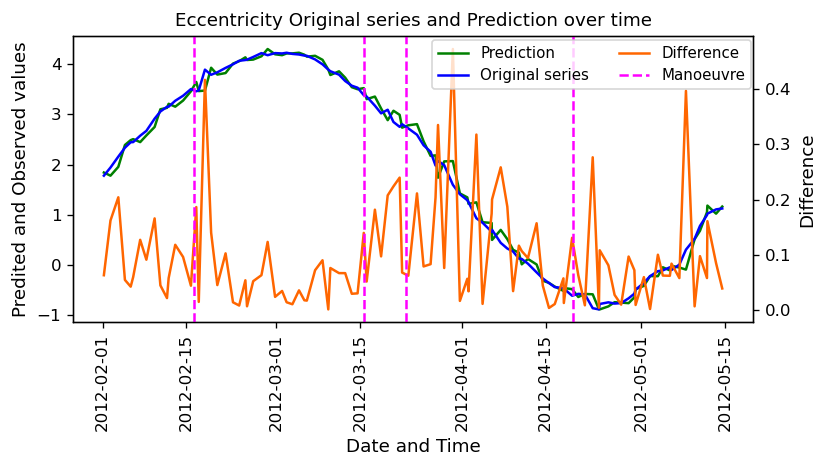

In [53]:

pd_df_Cryo_ecc_Arima_pred['TimeStamp'] = pd.to_datetime(pd_df_Cryo_ecc_Arima_pred['TimeStamp'])
pd_df_Cryo_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Cryo_GrdTrth['Start Date'])

# Define the start and end date for the filter
start_date = '2012-02-01'
end_date = '2012-05-15'

# Filter the DataFrame for rows where 'TimeStamp' is within the first few months of 2012
subset = pd_df_Cryo_ecc_Arima_pred[
    (pd_df_Cryo_ecc_Arima_pred['TimeStamp'] >= start_date) &
    (pd_df_Cryo_ecc_Arima_pred['TimeStamp'] <= end_date)]
GrdTrth = pd_df_Cryo_GrdTrth[
    (pd_df_Cryo_GrdTrth['Start Date'] >= start_date) &
    (pd_df_Cryo_GrdTrth['Start Date'] <= end_date)]

# plot forecasts against actual outcomes
x=subset['TimeStamp']
y1=subset['Prediction']
y2=subset['Observed']
y3=subset['Difference']

fig, ax = plt.subplots(figsize = (7,4))
plt.title('Eccentricity Original series and Prediction over time', fontsize = 11)

ax.tick_params(axis='x', labelrotation=90, labelsize=10)
ax.tick_params(axis='y', labelsize=10)

ax2 = ax.twinx()
ax2.tick_params(axis='y', labelsize=10)
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))

xcoords = GrdTrth['Start Date']
for xc in xcoords:
    plt.axvline(x=xc,color='magenta',label="Manoeuvre",linestyle='dashed')
 
ax.set_xlabel('Date and Time', fontsize = 11)
ax.set_ylabel('Predited and Observed values', fontsize = 11)
ax2.set_ylabel('Difference', fontsize = 11)


plt.tight_layout()
fig.legend(['Prediction','Original series','Difference','Manoeuvre'], loc='upper right',
           bbox_to_anchor=(0.91, 0.92), fontsize = 9, ncol =2)
 
# show plot
plt.show()

In [217]:
(pd_df_Cryo_aop_Arima_pred,dec_Cryo_aop_Arima_pred_RMSE, dec_Cryo_aop_Arima_pred_AIC, dec_Cryo_aop_Arima_pred_BIC
)=Fit_Predict_Arima(pd_df_Cryo_aop,'Argument of Perigee',1,1,1)

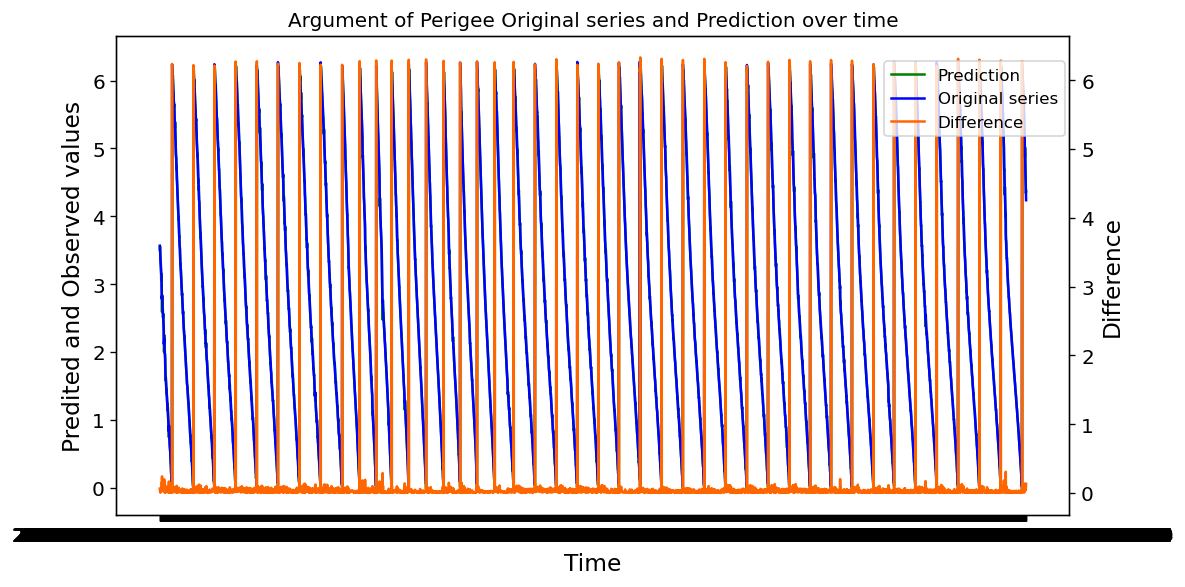

In [16]:

# evaluate forecasts
# pd_df_Cryo_aop_Arima_pred['Difference']=abs(pd_df_Cryo_aop_Arima_pred['Prediction']-pd_df_Cryo_aop_Arima_pred['Observed'])
# print('RMSE: %.3f' % dec_Cryo_aop_Arima_pred_RMSE)
# print('AIC: %.3f' % dec_Cryo_aop_Arima_pred_AIC)
# print('BIC: %.3f' % dec_Cryo_aop_Arima_pred_BIC)


# plot forecasts against actual outcomes
x=pd_df_Cryo_aop_Arima_pred['TimeStamp']
y1=pd_df_Cryo_aop_Arima_pred['Prediction']
y2=pd_df_Cryo_aop_Arima_pred['Observed']
y3=pd_df_Cryo_aop_Arima_pred['Difference']

fig, ax = plt.subplots(figsize = (10, 5))
plt.title('Argument of Perigee Original series and Prediction over time')
 
ax2 = ax.twinx()
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))
 
ax.set_xlabel('Time')
ax.set_ylabel('Predited and Observed values')
ax2.set_ylabel('Difference')
 
plt.tight_layout()
fig.legend(['Prediction','Original series','Difference'], loc='upper right', bbox_to_anchor=(0.9, 0.9))
 
# show plot
plt.show()


C:\Users\aloci\AppData\Local\Temp\ipykernel_4888\2407793717.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df_Cryo_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Cryo_GrdTrth['Start Date'])


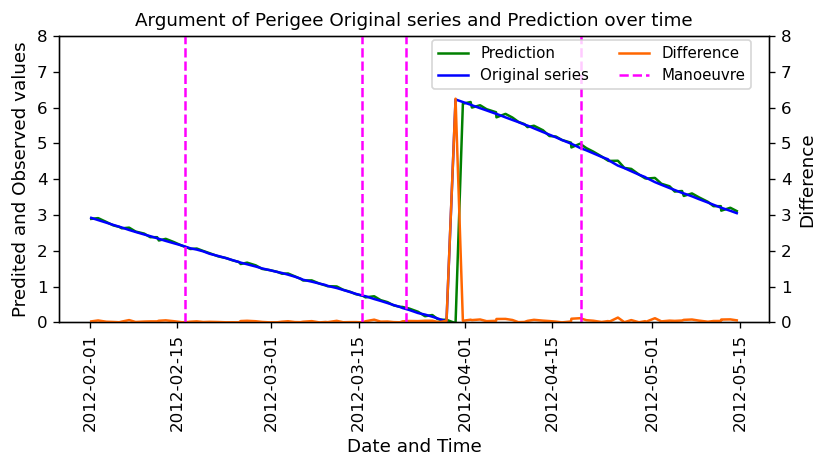

In [59]:

pd_df_Cryo_aop_Arima_pred['TimeStamp'] = pd.to_datetime(pd_df_Cryo_aop_Arima_pred['TimeStamp'])
pd_df_Cryo_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Cryo_GrdTrth['Start Date'])

# Define the start and end date for the filter
start_date = '2012-02-01'
end_date = '2012-05-15'

# Filter the DataFrame for rows where 'TimeStamp' is within the first few months of 2012
subset = pd_df_Cryo_aop_Arima_pred[
    (pd_df_Cryo_aop_Arima_pred['TimeStamp'] >= start_date) &
    (pd_df_Cryo_aop_Arima_pred['TimeStamp'] <= end_date)]
GrdTrth = pd_df_Cryo_GrdTrth[
    (pd_df_Cryo_GrdTrth['Start Date'] >= start_date) &
    (pd_df_Cryo_GrdTrth['Start Date'] <= end_date)]

# plot forecasts against actual outcomes
x=subset['TimeStamp']
y1=subset['Prediction']
y2=subset['Observed']
y3=subset['Difference']

fig, ax = plt.subplots(figsize = (7,4))
plt.title('Argument of Perigee Original series and Prediction over time', fontsize = 11)

ax.tick_params(axis='x', labelrotation=90, labelsize=10)
ax.tick_params(axis='y', labelsize=10)

ax2 = ax.twinx()
ax2.tick_params(axis='y', labelsize=10)
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))

ax.set_ylim(0, 8)
ax2.set_ylim(0, 8)

xcoords = GrdTrth['Start Date']
for xc in xcoords:
    plt.axvline(x=xc,color='magenta',label="Manoeuvre",linestyle='dashed')
 
ax.set_xlabel('Date and Time', fontsize = 11)
ax.set_ylabel('Predited and Observed values', fontsize = 11)
ax2.set_ylabel('Difference', fontsize = 11)


plt.tight_layout()
fig.legend(['Prediction','Original series','Difference','Manoeuvre'], loc='upper right',
           bbox_to_anchor=(0.91, 0.92), fontsize = 9, ncol =2)
 
# show plot
plt.show()

In [220]:
(pd_df_Cryo_ma_Arima_pred,dec_Cryo_ma_Arima_pred_RMSE, dec_Cryo_ma_Arima_pred_AIC, dec_Cryo_ma_Arima_pred_BIC
)=Fit_Predict_Arima(pd_df_Cryo_ma,'Mean Anomaly',1,1,1)

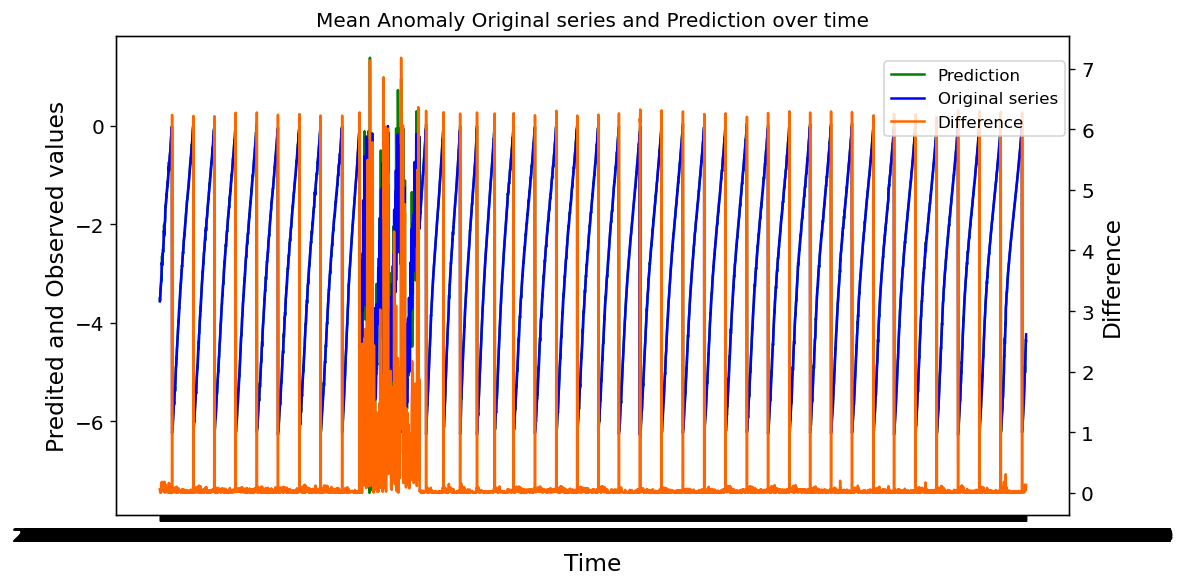

In [18]:
# evaluate forecasts
# pd_df_Cryo_ma_Arima_pred['Difference']=abs(pd_df_Cryo_ma_Arima_pred['Prediction']-pd_df_Cryo_ma_Arima_pred['Observed'])
# print('RMSE: %.3f' % dec_Cryo_ma_Arima_pred_RMSE)
# print('AIC: %.3f' % dec_Cryo_ma_Arima_pred_AIC)
# print('BIC: %.3f' % dec_Cryo_ma_Arima_pred_BIC)


# plot forecasts against actual outcomes
x=pd_df_Cryo_ma_Arima_pred['TimeStamp']
y1=pd_df_Cryo_ma_Arima_pred['Prediction']
y2=pd_df_Cryo_ma_Arima_pred['Observed']
y3=pd_df_Cryo_ma_Arima_pred['Difference']

fig, ax = plt.subplots(figsize = (10, 5))
plt.title('Mean Anomaly Original series and Prediction over time')
 
ax2 = ax.twinx()
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))
 
ax.set_xlabel('Time')
ax.set_ylabel('Predited and Observed values')
ax2.set_ylabel('Difference')
 
plt.tight_layout()
fig.legend(['Prediction','Original series','Difference'], loc='upper right', bbox_to_anchor=(0.9, 0.9))
 
# show plot
plt.show()

C:\Users\aloci\AppData\Local\Temp\ipykernel_4888\3714882099.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df_Cryo_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Cryo_GrdTrth['Start Date'])


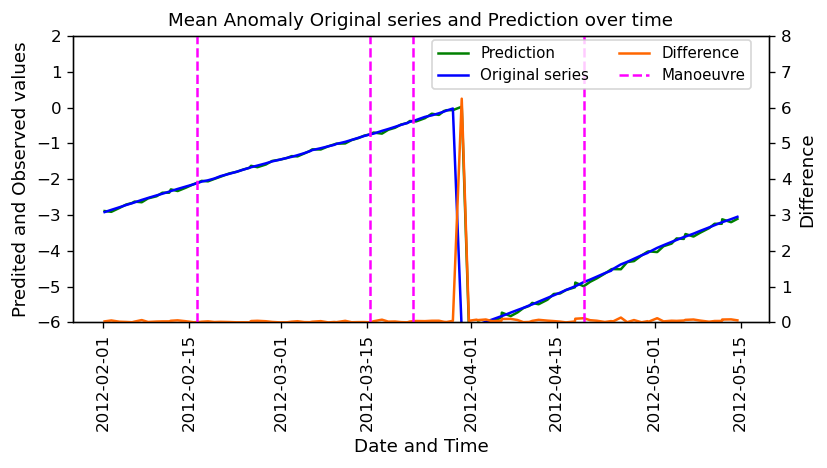

In [62]:

pd_df_Cryo_ma_Arima_pred['TimeStamp'] = pd.to_datetime(pd_df_Cryo_ma_Arima_pred['TimeStamp'])
pd_df_Cryo_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Cryo_GrdTrth['Start Date'])

# Define the start and end date for the filter
start_date = '2012-02-01'
end_date = '2012-05-15'

# Filter the DataFrame for rows where 'TimeStamp' is within the first few months of 2012
subset = pd_df_Cryo_ma_Arima_pred[
    (pd_df_Cryo_ma_Arima_pred['TimeStamp'] >= start_date) &
    (pd_df_Cryo_ma_Arima_pred['TimeStamp'] <= end_date)]
GrdTrth = pd_df_Cryo_GrdTrth[
    (pd_df_Cryo_GrdTrth['Start Date'] >= start_date) &
    (pd_df_Cryo_GrdTrth['Start Date'] <= end_date)]

# plot forecasts against actual outcomes
x=subset['TimeStamp']
y1=subset['Prediction']
y2=subset['Observed']
y3=subset['Difference']

fig, ax = plt.subplots(figsize = (7,4))
plt.title('Mean Anomaly Original series and Prediction over time', fontsize = 11)

ax.tick_params(axis='x', labelrotation=90, labelsize=10)
ax.tick_params(axis='y', labelsize=10)

ax2 = ax.twinx()
ax2.tick_params(axis='y', labelsize=10)
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))

ax.set_ylim(-6, 2)
ax2.set_ylim(0, 8)

xcoords = GrdTrth['Start Date']
for xc in xcoords:
    plt.axvline(x=xc,color='magenta',label="Manoeuvre",linestyle='dashed')
 
ax.set_xlabel('Date and Time', fontsize = 11)
ax.set_ylabel('Predited and Observed values', fontsize = 11)
ax2.set_ylabel('Difference', fontsize = 11)


plt.tight_layout()
fig.legend(['Prediction','Original series','Difference','Manoeuvre'], loc='upper right',
           bbox_to_anchor=(0.91, 0.92), fontsize = 9, ncol =2)
 
# show plot
plt.show()

In [223]:
(pd_df_Cryo_inc_Arima_pred,dec_Cryo_inc_Arima_pred_RMSE, dec_Cryo_inc_Arima_pred_AIC, dec_Cryo_inc_Arima_pred_BIC
)=Fit_Predict_Arima(pd_df_Cryo_inc,'Inclination',1,1,1)

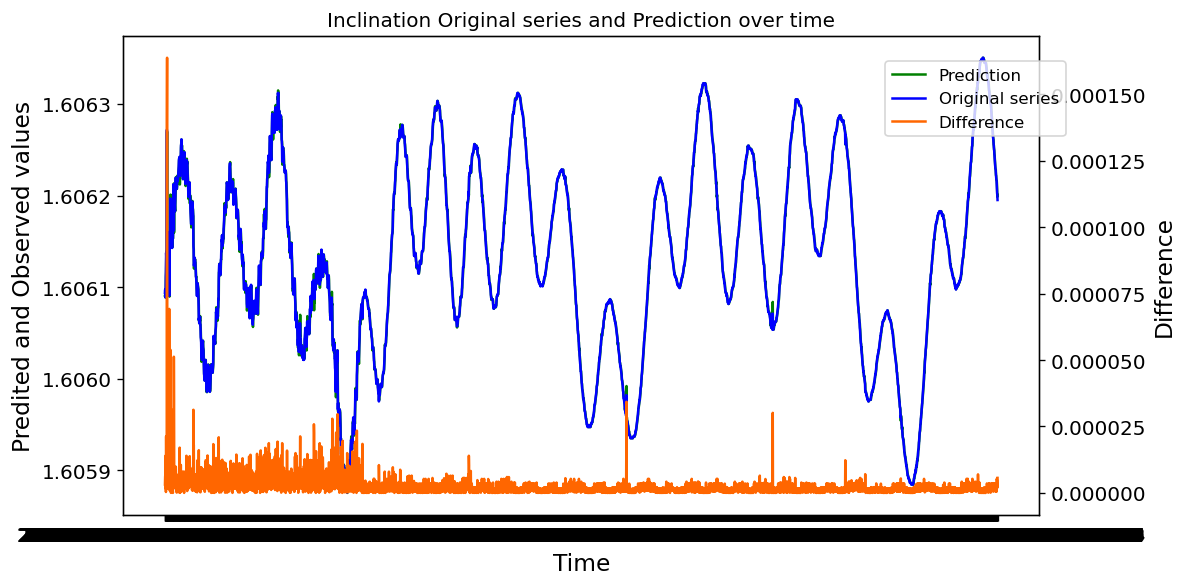

In [20]:
# evaluate forecasts
# pd_df_Cryo_inc_Arima_pred['Difference']=abs(pd_df_Cryo_inc_Arima_pred['Prediction']-pd_df_Cryo_inc_Arima_pred['Observed'])
# print('RMSE: %.3f' % dec_Cryo_inc_Arima_pred_RMSE)
# print('AIC: %.3f' % dec_Cryo_inc_Arima_pred_AIC)
# print('BIC: %.3f' % dec_Cryo_inc_Arima_pred_BIC)


# plot forecasts against actual outcomes
x=pd_df_Cryo_inc_Arima_pred['TimeStamp']
y1=pd_df_Cryo_inc_Arima_pred['Prediction']
y2=pd_df_Cryo_inc_Arima_pred['Observed']
y3=pd_df_Cryo_inc_Arima_pred['Difference']

fig, ax = plt.subplots(figsize = (10, 5))
plt.title('Inclination Original series and Prediction over time')
 
ax2 = ax.twinx()
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))
 
ax.set_xlabel('Time')
ax.set_ylabel('Predited and Observed values')
ax2.set_ylabel('Difference')
 
plt.tight_layout()
fig.legend(['Prediction','Original series','Difference'], loc='upper right', bbox_to_anchor=(0.9, 0.9))
 
# show plot
plt.show()

C:\Users\aloci\AppData\Local\Temp\ipykernel_4888\2295445585.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df_Cryo_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Cryo_GrdTrth['Start Date'])


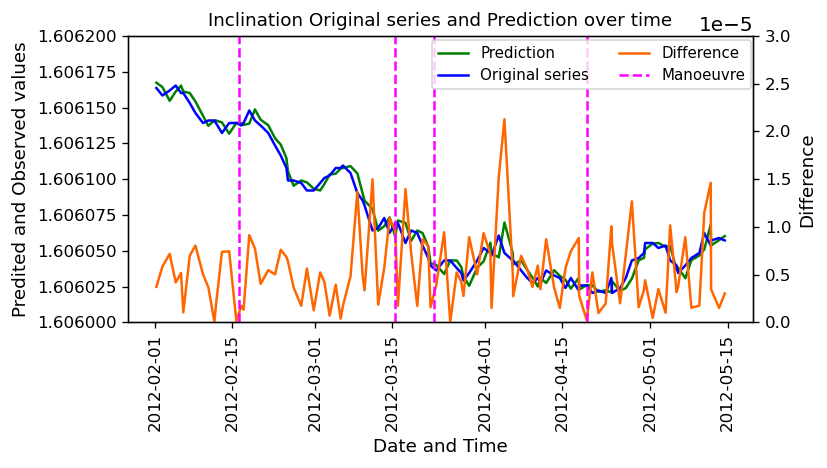

In [78]:

pd_df_Cryo_inc_Arima_pred['TimeStamp'] = pd.to_datetime(pd_df_Cryo_inc_Arima_pred['TimeStamp'])
pd_df_Cryo_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Cryo_GrdTrth['Start Date'])

# Define the start and end date for the filter
start_date = '2012-02-01'
end_date = '2012-05-15'

# Filter the DataFrame for rows where 'TimeStamp' is within the first few months of 2012
subset = pd_df_Cryo_inc_Arima_pred[
    (pd_df_Cryo_inc_Arima_pred['TimeStamp'] >= start_date) &
    (pd_df_Cryo_inc_Arima_pred['TimeStamp'] <= end_date)]
GrdTrth = pd_df_Cryo_GrdTrth[
    (pd_df_Cryo_GrdTrth['Start Date'] >= start_date) &
    (pd_df_Cryo_GrdTrth['Start Date'] <= end_date)]

# plot forecasts against actual outcomes
x=subset['TimeStamp']
y1=subset['Prediction']
y2=subset['Observed']
y3=subset['Difference']

fig, ax = plt.subplots(figsize = (7,4))
plt.title('Inclination Original series and Prediction over time', fontsize = 11)

ax.tick_params(axis='x', labelrotation=90, labelsize=10)
ax.tick_params(axis='y', labelsize=10)

ax2 = ax.twinx()
ax2.tick_params(axis='y', labelsize=10)
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))

ax.set_ylim(1.606, 1.6062)
ax2.set_ylim(0, 0.00003)

xcoords = GrdTrth['Start Date']
for xc in xcoords:
    plt.axvline(x=xc,color='magenta',label="Manoeuvre",linestyle='dashed')
 
ax.set_xlabel('Date and Time', fontsize = 11)
ax.set_ylabel('Predited and Observed values', fontsize = 11)
ax2.set_ylabel('Difference', fontsize = 11)

formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)
# ax2.yaxis.set_major_formatter(formatter)


plt.tight_layout()
fig.legend(['Prediction','Original series','Difference','Manoeuvre'], loc='upper right',
           bbox_to_anchor=(0.91, 0.92), fontsize = 9, ncol =2)
 
# show plot
plt.show()

In [226]:
(pd_df_Cryo_ra_Arima_pred,dec_Cryo_ra_Arima_pred_RMSE, dec_Cryo_ra_Arima_pred_AIC, dec_Cryo_ra_Arima_pred_BIC
)=Fit_Predict_Arima(pd_df_Cryo_ra,'Right Ascension',1,1,1)

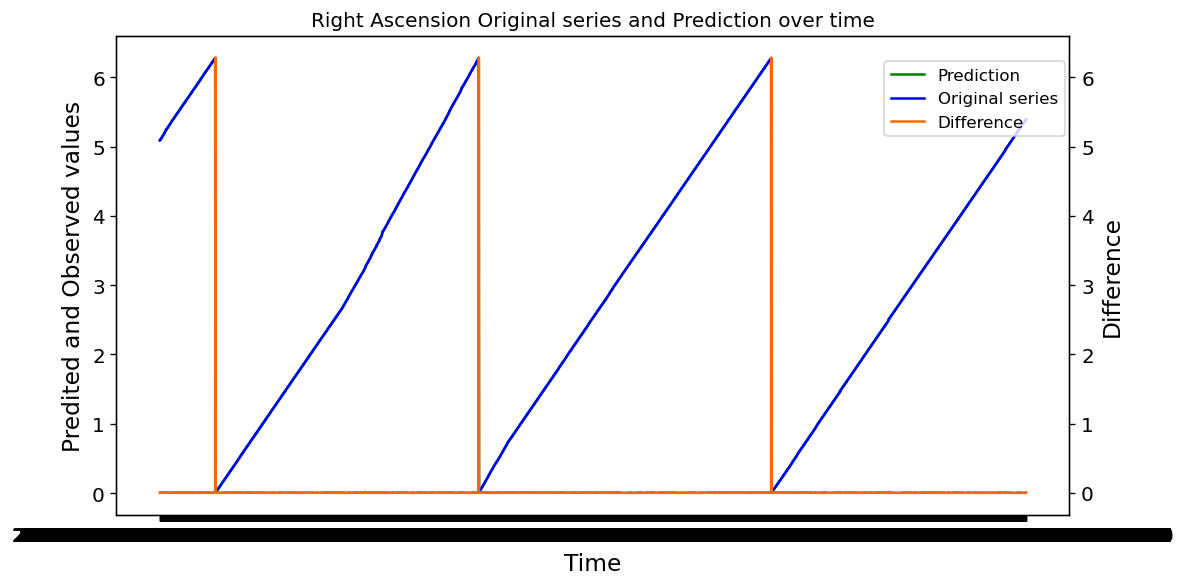

In [22]:
# evaluate forecasts
# pd_df_Cryo_ra_Arima_pred['Difference']=abs(pd_df_Cryo_ra_Arima_pred['Prediction']-pd_df_Cryo_ra_Arima_pred['Observed'])
# print('RMSE: %.3f' % dec_Cryo_ra_Arima_pred_RMSE)
# print('AIC: %.3f' % dec_Cryo_ra_Arima_pred_AIC)
# print('BIC: %.3f' % dec_Cryo_ra_Arima_pred_BIC)


# plot forecasts against actual outcomes
x=pd_df_Cryo_ra_Arima_pred['TimeStamp']
y1=pd_df_Cryo_ra_Arima_pred['Prediction']
y2=pd_df_Cryo_ra_Arima_pred['Observed']
y3=pd_df_Cryo_ra_Arima_pred['Difference']

fig, ax = plt.subplots(figsize = (10, 5))
plt.title('Right Ascension Original series and Prediction over time')
 
ax2 = ax.twinx()
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))
 
ax.set_xlabel('Time')
ax.set_ylabel('Predited and Observed values')
ax2.set_ylabel('Difference')
 
plt.tight_layout()
fig.legend(['Prediction','Original series','Difference'], loc='upper right', bbox_to_anchor=(0.9, 0.9))
 
# show plot
plt.show()

C:\Users\aloci\AppData\Local\Temp\ipykernel_4888\2360482197.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df_Cryo_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Cryo_GrdTrth['Start Date'])


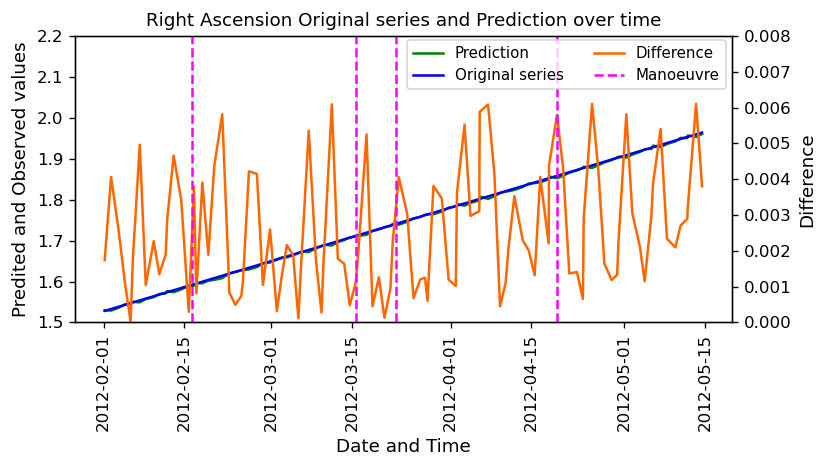

In [85]:

pd_df_Cryo_ra_Arima_pred['TimeStamp'] = pd.to_datetime(pd_df_Cryo_ra_Arima_pred['TimeStamp'])
pd_df_Cryo_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Cryo_GrdTrth['Start Date'])

# Define the start and end date for the filter
start_date = '2012-02-01'
end_date = '2012-05-15'

# Filter the DataFrame for rows where 'TimeStamp' is within the first few months of 2012
subset = pd_df_Cryo_ra_Arima_pred[
    (pd_df_Cryo_ra_Arima_pred['TimeStamp'] >= start_date) &
    (pd_df_Cryo_ra_Arima_pred['TimeStamp'] <= end_date)]
GrdTrth = pd_df_Cryo_GrdTrth[
    (pd_df_Cryo_GrdTrth['Start Date'] >= start_date) &
    (pd_df_Cryo_GrdTrth['Start Date'] <= end_date)]

# plot forecasts against actual outcomes
x=subset['TimeStamp']
y1=subset['Prediction']
y2=subset['Observed']
y3=subset['Difference']

fig, ax = plt.subplots(figsize = (7,4))
plt.title('Right Ascension Original series and Prediction over time', fontsize = 11)

ax.tick_params(axis='x', labelrotation=90, labelsize=10)
ax.tick_params(axis='y', labelsize=10)

ax2 = ax.twinx()
ax2.tick_params(axis='y', labelsize=10)
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))

ax.set_ylim(1.5, 2.2)
ax2.set_ylim(0, 0.008)

xcoords = GrdTrth['Start Date']
for xc in xcoords:
    plt.axvline(x=xc,color='magenta',label="Manoeuvre",linestyle='dashed')
 
ax.set_xlabel('Date and Time', fontsize = 11)
ax.set_ylabel('Predited and Observed values', fontsize = 11)
ax2.set_ylabel('Difference', fontsize = 11)

formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)
# ax2.yaxis.set_major_formatter(formatter)


plt.tight_layout()
fig.legend(['Prediction','Original series','Difference','Manoeuvre'], loc='upper right',
           bbox_to_anchor=(0.88, 0.92), fontsize = 9, ncol =2)
 
# show plot
plt.show()

## 2.6 Highlight Anomalies

### 2.6.1 Brouwer Mean Motion Anomaly Detection

In [229]:
# Determine Threshold value

s=pd_df_Cryo_bmm_Arima_pred['Difference']

# Define the threshold values
pd_lst_quan = [0.05, 0.5, 0.75, 0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

# Calculate the quantile threshold values
pd_lst_thres = s.quantile(pd_lst_quan)

# Calculate the count of data points above each threshold value
pd_lst_counts = [(s > threshold).sum() for threshold in pd_lst_thres]

# Create a DataFrame with the quantiles, threshold values, and counts
pd_df_thresh = pd.DataFrame({
    'Quantile': pd_lst_quan,
    'Threshold Value': pd_lst_thres.values,
    'Count': pd_lst_counts})
print(pd_df_thresh)



    Quantile Threshold Value  Count
0       0.05         0.00297   4089
1       0.50        0.038403   2152
2       0.75        0.099146   1076
3       0.80        0.122533    861
4       0.85        0.165965    646
5       0.90        0.266448    431
6       0.91        0.295095    388
7       0.92        0.337841    345
8       0.93        0.391952    302
9       0.94        0.478479    259
10      0.95        0.621219    216
11      0.96        0.937266    173
12      0.97        1.643274    130
13      0.98        2.915235     87
14      0.99        4.664855     44


In [230]:
# choose threshold
threshold = pd_df_thresh.loc[pd_df_thresh['Quantile'] == 0.94, 'Threshold Value'].values[0]
print(threshold)

pd_df_Cryo_bmm_Arima_anom = detect_anomalies(pd_df_Cryo_bmm_Arima_pred, threshold)

# pd_df_Cryo_bmm_Arima_anom.iloc[220:270]

0.478478960771781


In [231]:
# Add Manoeuvre column to show the ground truth manoevres (with a 3 day gray area)
pd_df_Cryo_bmm_Arima_anom['Manoeuvre'] = 'No'

# Iterate over the Cryo_GrdTrth DataFrame and update pd_df_Cryo_bmm_Arima_anom['Manoeuvre']
for _, row in pd_df_Cryo_GrdTrth.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']
    
    # for each row in pd_df_Cryo_bmm_Arima_anom, calculate a boolean called in_gray_zone and 
    # set it to True if it is within 1 day of the start time or within 3 days of the finish time of a logged Manoeuvre
    in_gray_zone = (
        (pd_df_Cryo_bmm_Arima_anom['TimeStamp'] >= (start_date + pd.Timedelta(days=2))) & 
        (pd_df_Cryo_bmm_Arima_anom['TimeStamp'] <= (end_date + pd.Timedelta(days=4)))
    )
    
    # Update the 'Manoeuvre' column to 'Yes' if in_gray_zone is True
    pd_df_Cryo_bmm_Arima_anom.loc[in_gray_zone, 'Manoeuvre'] = 'Yes'

    
test=pd_df_Cryo_bmm_Arima_anom[['TimeStamp','Difference', 'Anomaly','Manoeuvre']]

for x in range(0,20):
    subset=test[50*x:50*(x+1)]
    print(subset)


                    TimeStamp Difference Anomaly Manoeuvre
0  2010-04-28 12:59:36.035519   0.100498      No        No
1  2010-04-29 00:34:12.213407   0.056433      No        No
2  2010-04-30 09:38:46.889375   0.081472      No        No
3  2010-05-01 12:06:26.644320   0.018257      No        No
4  2010-05-02 12:54:52.673760    0.21834      No        No
5  2010-05-03 13:43:18.741216   0.006921      No        No
6  2010-05-04 21:08:39.697727    0.14995      No        No
7  2010-05-05 00:27:07.147007   0.006787      No        No
8  2010-05-06 12:50:02.311008  27.793121     Yes       Yes
9  2010-05-08 02:52:25.312224   53.43164     Yes       Yes
10 2010-05-09 00:21:48.377664  59.912736     Yes       Yes
11 2010-05-10 11:05:21.007680  18.248149     Yes       Yes
12 2010-05-11 13:32:48.308064   9.069663     Yes        No
13 2010-05-12 20:57:54.779615   0.126604      No        No
14 2010-05-13 11:50:51.500832   0.048695      No        No
15 2010-05-14 20:55:10.915967   0.017338      No        

                     TimeStamp Difference Anomaly Manoeuvre
900 2012-10-22 07:44:44.000736   0.208578      No        No
901 2012-10-23 08:33:07.516799   0.021038      No        No
902 2012-10-24 20:56:05.903520   1.108444     Yes        No
903 2012-10-25 20:05:15.799488   0.178754      No        No
904 2012-10-26 02:42:10.024991   0.091914      No        No
905 2012-10-27 08:28:14.110175   0.406243      No        No
906 2012-10-28 19:11:58.850879   0.737399     Yes        No
907 2012-10-29 20:00:22.225248   0.993499     Yes        No
908 2012-10-31 03:25:39.756000   0.209185      No        No
909 2012-11-01 09:11:43.863647   0.201935      No        No
910 2012-11-02 14:57:47.949696   0.318339      No        No
911 2012-11-03 20:43:51.853439   0.244541      No        No
912 2012-11-05 02:29:55.824576   0.422537      No        No
913 2012-11-06 03:18:19.142783   0.062375      No        No
914 2012-11-07 09:04:23.163167   0.156892      No        No
915 2012-11-08 09:52:46.457183   0.41702

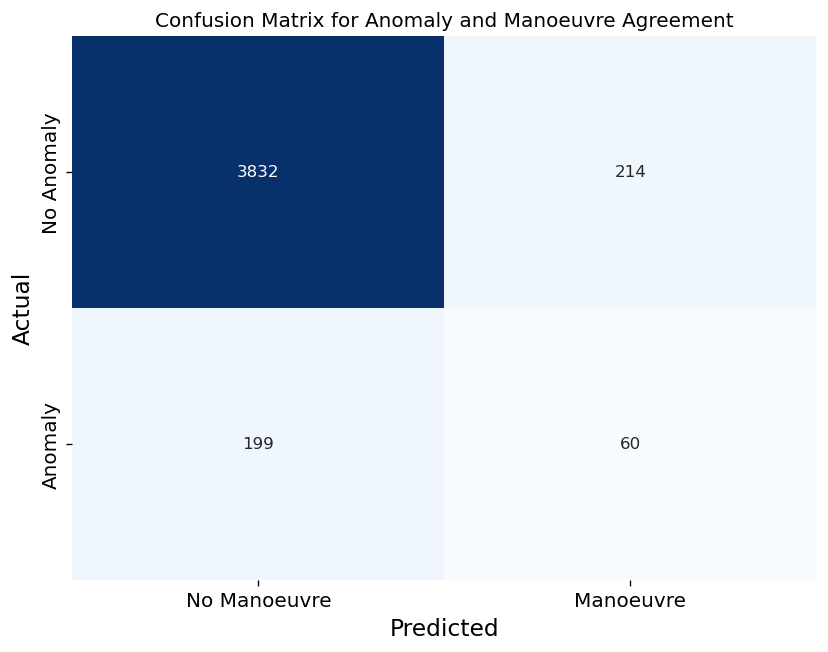

In [155]:
df=pd_df_Cryo_bmm_Arima_anom[['TimeStamp','Anomaly','Manoeuvre']]

# Convert 'yes'/'no' to binary values
df['anomaly_bin'] = df['Anomaly'].map({'Yes': 1, 'No': 0})
df['manoeuvre_bin'] = df['Manoeuvre'].map({'Yes': 1, 'No': 0})

# Create confusion matrix
cm = confusion_matrix(df['anomaly_bin'], df['manoeuvre_bin'])

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=['No Anomaly', 'Anomaly'], columns=['No Manoeuvre', 'Manoeuvre'])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sb.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Anomaly and Manoeuvre Agreement')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 2.6.2 Eccentricity Anomaly Detection

In [232]:
# Determine Threshold value

s=pd_df_Cryo_ecc_Arima_pred['Difference']

# Define the threshold values
pd_lst_quan = [0.05, 0.5, 0.75, 0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

# Calculate the quantile threshold values
pd_lst_thres = s.quantile(pd_lst_quan)

# Calculate the count of data points above each threshold value
pd_lst_counts = [(s > threshold).sum() for threshold in pd_lst_thres]

# Create a DataFrame with the quantiles, threshold values, and counts
pd_df_thresh = pd.DataFrame({
    'Quantile': pd_lst_quan,
    'Threshold Value': pd_lst_thres.values,
    'Count': pd_lst_counts})
print(pd_df_thresh)



    Quantile Threshold Value  Count
0       0.05         0.00288   4089
1       0.50        0.037033   2152
2       0.75        0.076343   1076
3       0.80        0.090639    861
4       0.85        0.108138    646
5       0.90        0.132761    431
6       0.91        0.139568    388
7       0.92        0.145189    345
8       0.93        0.155129    302
9       0.94        0.166913    259
10      0.95        0.181177    216
11      0.96        0.195932    173
12      0.97        0.224915    130
13      0.98        0.283649     87
14      0.99        0.358553     44


In [233]:
# choose threshold
threshold = pd_df_thresh.loc[pd_df_thresh['Quantile'] == 0.94, 'Threshold Value'].values[0]
print(threshold)

pd_df_Cryo_ecc_Arima_anom = detect_anomalies(pd_df_Cryo_ecc_Arima_pred, threshold)


0.16691269598681835


In [234]:
# Add Manoeuvre column to show the ground truth manoevres (with a 3 day gray area)
pd_df_Cryo_ecc_Arima_anom['Manoeuvre'] = 'No'

# Iterate over the Cryo_GrdTrth DataFrame and update pd_df_Cryo_ecc_Arima_anom['Manoeuvre']
for _, row in pd_df_Cryo_GrdTrth.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']
    
    # for each row in pd_df_Cryo_ecc_Arima_anom, calculate a boolean called in_gray_zone and 
    # set it to True if it is within 1 day of the start time or within 3 days of the finish time of a logged Manoeuvre
    in_gray_zone = (
        (pd_df_Cryo_ecc_Arima_anom['TimeStamp'] >= (start_date - pd.Timedelta(days=1))) & 
        (pd_df_Cryo_ecc_Arima_anom['TimeStamp'] <= (end_date + pd.Timedelta(days=3)))
    )
    
    # Update the 'Manoeuvre' column to 'Yes' if in_gray_zone is True
    pd_df_Cryo_ecc_Arima_anom.loc[in_gray_zone, 'Manoeuvre'] = 'Yes'

    
test=pd_df_Cryo_ecc_Arima_anom[['TimeStamp','Difference', 'Anomaly','Manoeuvre']]

for x in range(0,20):
    subset=test[50*x:50*(x+1)]
    print(subset)


                    TimeStamp Difference Anomaly Manoeuvre
0  2010-04-28 12:59:36.035519   0.079297      No        No
1  2010-04-29 00:34:12.213407   0.167404     Yes        No
2  2010-04-30 09:38:46.889375   0.041736      No        No
3  2010-05-01 12:06:26.644320   0.085703      No        No
4  2010-05-02 12:54:52.673760   0.038764      No        No
5  2010-05-03 13:43:18.741216   0.065276      No       Yes
6  2010-05-04 21:08:39.697727   0.088545      No       Yes
7  2010-05-05 00:27:07.147007   0.270533     Yes       Yes
8  2010-05-06 12:50:02.311008   0.400002     Yes       Yes
9  2010-05-08 02:52:25.312224   0.134992      No       Yes
10 2010-05-09 00:21:48.377664   1.632906     Yes       Yes
11 2010-05-10 11:05:21.007680   1.157001     Yes        No
12 2010-05-11 13:32:48.308064   1.048182     Yes        No
13 2010-05-12 20:57:54.779615   0.167351     Yes        No
14 2010-05-13 11:50:51.500832   0.089142      No        No
15 2010-05-14 20:55:10.915967   0.302191     Yes        

### 2.6.3 Argument of Perigee Anomaly Detection

In [235]:
# Determine Threshold value

s=pd_df_Cryo_aop_Arima_pred['Difference']

# Define the threshold values
pd_lst_quan = [0.05, 0.5, 0.75, 0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

# Calculate the quantile threshold values
pd_lst_thres = s.quantile(pd_lst_quan)

# Calculate the count of data points above each threshold value
pd_lst_counts = [(s > threshold).sum() for threshold in pd_lst_thres]

# Create a DataFrame with the quantiles, threshold values, and counts
pd_df_thresh = pd.DataFrame({
    'Quantile': pd_lst_quan,
    'Threshold Value': pd_lst_thres.values,
    'Count': pd_lst_counts})
print(pd_df_thresh)



    Quantile Threshold Value  Count
0       0.05        0.001741   4089
1       0.50        0.020627   2152
2       0.75        0.040344   1076
3       0.80        0.046682    861
4       0.85        0.054541    646
5       0.90        0.064306    431
6       0.91        0.067222    388
7       0.92        0.070649    345
8       0.93        0.074885    302
9       0.94        0.079329    259
10      0.95        0.084769    216
11      0.96        0.090388    173
12      0.97        0.100319    130
13      0.98        0.117383     87
14      0.99        6.198434     44


In [236]:
# choose threshold
threshold = pd_df_thresh.loc[pd_df_thresh['Quantile'] == 0.94, 'Threshold Value'].values[0]
print(threshold)

pd_df_Cryo_aop_Arima_anom = detect_anomalies(pd_df_Cryo_ecc_Arima_pred, threshold)


0.07932891171472566


In [237]:
# Add Manoeuvre column to show the ground truth manoevres (with a 3 day gray area)
pd_df_Cryo_aop_Arima_anom['Manoeuvre'] = 'No'

# Iterate over the Cryo_GrdTrth DataFrame and update pd_df_Cryo_aop_Arima_anom['Manoeuvre']
for _, row in pd_df_Cryo_GrdTrth.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']
    
    # for each row in pd_df_Cryo_aop_Arima_anom, calculate a boolean called in_gray_zone and 
    # set it to True if it is within 1 day of the start time or within 3 days of the finish time of a logged Manoeuvre
    in_gray_zone = (
        (pd_df_Cryo_aop_Arima_anom['TimeStamp'] >= (start_date - pd.Timedelta(days=1))) & 
        (pd_df_Cryo_aop_Arima_anom['TimeStamp'] <= (end_date + pd.Timedelta(days=3)))
    )
    
    # Update the 'Manoeuvre' column to 'Yes' if in_gray_zone is True
    pd_df_Cryo_aop_Arima_anom.loc[in_gray_zone, 'Manoeuvre'] = 'Yes'

    
test=pd_df_Cryo_aop_Arima_anom[['TimeStamp','Difference', 'Anomaly','Manoeuvre']]

for x in range(0,20):
    subset=test[50*x:50*(x+1)]
    print(subset)


                    TimeStamp Difference Anomaly Manoeuvre
0  2010-04-28 12:59:36.035519   0.079297      No        No
1  2010-04-29 00:34:12.213407   0.167404     Yes        No
2  2010-04-30 09:38:46.889375   0.041736      No        No
3  2010-05-01 12:06:26.644320   0.085703     Yes        No
4  2010-05-02 12:54:52.673760   0.038764      No        No
5  2010-05-03 13:43:18.741216   0.065276      No       Yes
6  2010-05-04 21:08:39.697727   0.088545     Yes       Yes
7  2010-05-05 00:27:07.147007   0.270533     Yes       Yes
8  2010-05-06 12:50:02.311008   0.400002     Yes       Yes
9  2010-05-08 02:52:25.312224   0.134992     Yes       Yes
10 2010-05-09 00:21:48.377664   1.632906     Yes       Yes
11 2010-05-10 11:05:21.007680   1.157001     Yes        No
12 2010-05-11 13:32:48.308064   1.048182     Yes        No
13 2010-05-12 20:57:54.779615   0.167351     Yes        No
14 2010-05-13 11:50:51.500832   0.089142     Yes        No
15 2010-05-14 20:55:10.915967   0.302191     Yes        

849 2012-09-01 16:13:39.006624   0.137272     Yes        No
                     TimeStamp Difference Anomaly Manoeuvre
850 2012-09-02 17:02:02.539968   0.083796     Yes        No
851 2012-09-03 22:48:06.719328   0.090363     Yes        No
852 2012-09-04 03:45:47.417183   0.098617     Yes        No
853 2012-09-05 22:45:40.068288   0.195584     Yes        No
854 2012-09-06 16:57:09.254303   0.019924      No        No
855 2012-09-07 22:43:13.320479    0.17336     Yes        No
856 2012-09-08 05:20:07.549439   0.145163     Yes        No
857 2012-09-09 09:26:58.036127   0.111846     Yes        No
858 2012-09-10 10:15:21.387167   0.002728      No        No
859 2012-09-11 16:01:25.455072   0.028972      No        No
860 2012-09-12 16:49:48.763776   0.000084      No        No
861 2012-09-13 22:35:52.759104   0.276484     Yes        No
862 2012-09-14 03:33:33.410303   0.074106      No        No
863 2012-09-15 04:21:56.760480   0.246031     Yes        No
864 2012-09-16 10:08:00.663360   0.34299

### 2.6.4 Mean Anomaly Anomaly Detection

In [241]:
# Determine Threshold value

s=pd_df_Cryo_ma_Arima_pred['Difference']

# Define the threshold values
pd_lst_quan = [0.05, 0.5, 0.75, 0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

# Calculate the quantile threshold values
pd_lst_thres = s.quantile(pd_lst_quan)

# Calculate the count of data points above each threshold value
pd_lst_counts = [(s > threshold).sum() for threshold in pd_lst_thres]

# Create a DataFrame with the quantiles, threshold values, and counts
pd_df_thresh = pd.DataFrame({
    'Quantile': pd_lst_quan,
    'Threshold Value': pd_lst_thres.values,
    'Count': pd_lst_counts})
print(pd_df_thresh)



    Quantile Threshold Value  Count
0       0.05        0.001969   4089
1       0.50        0.022766   2152
2       0.75         0.04707   1076
3       0.80        0.055638    861
4       0.85        0.065915    646
5       0.90        0.088456    431
6       0.91        0.097667    388
7       0.92        0.113317    345
8       0.93        0.164158    302
9       0.94        0.444926    259
10      0.95         0.81275    216
11      0.96        1.121877    173
12      0.97        1.567142    130
13      0.98        3.495668     87
14      0.99        6.202871     44


In [242]:
# choose threshold
threshold = pd_df_thresh.loc[pd_df_thresh['Quantile'] == 0.94, 'Threshold Value'].values[0]
print(threshold)

pd_df_Cryo_ma_Arima_anom = detect_anomalies(pd_df_Cryo_ma_Arima_pred, threshold)


0.44492558932474074


In [243]:
# Add Manoeuvre column to show the ground truth manoevres (with a 3 day gray area)
pd_df_Cryo_ma_Arima_anom['Manoeuvre'] = 'No'

# Iterate over the Cryo_GrdTrth DataFrame and update pd_df_Cryo_ma_Arima_anom['Manoeuvre']
for _, row in pd_df_Cryo_GrdTrth.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']
    
    # for each row in pd_df_Cryo_ma_Arima_anom, calculate a boolean called in_gray_zone and 
    # set it to True if it is within 1 day of the start time or within 3 days of the finish time of a logged Manoeuvre
    in_gray_zone = (
        (pd_df_Cryo_ma_Arima_anom['TimeStamp'] >= (start_date - pd.Timedelta(days=1))) & 
        (pd_df_Cryo_ma_Arima_anom['TimeStamp'] <= (end_date + pd.Timedelta(days=3)))
    )
    
    # Update the 'Manoeuvre' column to 'Yes' if in_gray_zone is True
    pd_df_Cryo_ma_Arima_anom.loc[in_gray_zone, 'Manoeuvre'] = 'Yes'

    
test=pd_df_Cryo_ma_Arima_anom[['TimeStamp','Difference', 'Anomaly','Manoeuvre']]

for x in range(0,20):
    subset=test[50*x:50*(x+1)]
    print(subset)


                    TimeStamp Difference Anomaly Manoeuvre
0  2010-04-28 12:59:36.035519   0.062453      No        No
1  2010-04-29 00:34:12.213407   0.030719      No        No
2  2010-04-30 09:38:46.889375   0.048933      No        No
3  2010-05-01 12:06:26.644320   0.003194      No        No
4  2010-05-02 12:54:52.673760   0.010981      No        No
5  2010-05-03 13:43:18.741216   0.004254      No       Yes
6  2010-05-04 21:08:39.697727   0.029757      No       Yes
7  2010-05-05 00:27:07.147007   0.086724      No       Yes
8  2010-05-06 12:50:02.311008   0.030703      No       Yes
9  2010-05-08 02:52:25.312224   0.172111      No       Yes
10 2010-05-09 00:21:48.377664   0.094118      No       Yes
11 2010-05-10 11:05:21.007680    0.18304      No        No
12 2010-05-11 13:32:48.308064   0.064035      No        No
13 2010-05-12 20:57:54.779615   0.148677      No        No
14 2010-05-13 11:50:51.500832   0.044719      No        No
15 2010-05-14 20:55:10.915967   0.063842      No        

799 2012-07-13 08:58:30.759167   6.223756     Yes       Yes
                     TimeStamp Difference Anomaly Manoeuvre
800 2012-07-14 18:03:02.176991    0.02439      No       Yes
801 2012-07-15 18:51:25.794143   0.060394      No        No
802 2012-07-16 18:00:35.871552   0.002573      No        No
803 2012-07-17 18:48:59.429088   0.011275      No        No
804 2012-07-18 08:02:47.968223   0.030853      No        No
805 2012-07-19 18:46:32.903328   0.072574      No        No
806 2012-07-20 17:55:42.851999   0.005974      No        No
807 2012-07-21 18:44:06.367200   0.024508      No        No
808 2012-07-22 17:53:16.293407   0.004665      No        No
809 2012-07-23 12:04:45.504480   0.027084      No        No
810 2012-07-24 17:50:49.710624    0.04714      No        No
811 2012-07-25 18:39:13.177440   0.018191      No       Yes
812 2012-07-26 17:48:23.069952   0.009613      No       Yes
813 2012-07-27 18:36:46.622303   0.012671      No       Yes
814 2012-07-28 17:45:56.735999   0.00592

### 2.6.5 Inclination Anomaly Detection

In [238]:
# Determine Threshold value

s=pd_df_Cryo_inc_Arima_pred['Difference']

# Define the threshold values
pd_lst_quan = [0.05, 0.5, 0.75, 0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

# Calculate the quantile threshold values
pd_lst_thres = s.quantile(pd_lst_quan)

# Calculate the count of data points above each threshold value
pd_lst_counts = [(s > threshold).sum() for threshold in pd_lst_thres]

# Create a DataFrame with the quantiles, threshold values, and counts
pd_df_thresh = pd.DataFrame({
    'Quantile': pd_lst_quan,
    'Threshold Value': pd_lst_thres.values,
    'Count': pd_lst_counts})
print(pd_df_thresh)



    Quantile Threshold Value  Count
0       0.05             0.0   3930
1       0.50        0.000002   2130
2       0.75        0.000004   1069
3       0.80        0.000004    844
4       0.85        0.000004    643
5       0.90        0.000006    431
6       0.91        0.000006    388
7       0.92        0.000007    344
8       0.93        0.000007    302
9       0.94        0.000008    259
10      0.95        0.000009    216
11      0.96        0.000009    173
12      0.97        0.000011    130
13      0.98        0.000013     87
14      0.99        0.000016     44


In [239]:
# choose threshold
threshold = pd_df_thresh.loc[pd_df_thresh['Quantile'] == 0.94, 'Threshold Value'].values[0]
print(threshold)

pd_df_Cryo_inc_Arima_anom = detect_anomalies(pd_df_Cryo_ecc_Arima_pred, threshold)


7.6127906132406056e-06


In [240]:
# Add Manoeuvre column to show the ground truth manoevres (with a 3 day gray area)
pd_df_Cryo_inc_Arima_anom['Manoeuvre'] = 'No'

# Iterate over the Cryo_GrdTrth DataFrame and update pd_df_Cryo_inc_Arima_anom['Manoeuvre']
for _, row in pd_df_Cryo_GrdTrth.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']
    
    # for each row in pd_df_Cryo_inc_Arima_anom, calculate a boolean called in_gray_zone and 
    # set it to True if it is within 1 day of the start time or within 3 days of the finish time of a logged Manoeuvre
    in_gray_zone = (
        (pd_df_Cryo_inc_Arima_anom['TimeStamp'] >= (start_date - pd.Timedelta(days=1))) & 
        (pd_df_Cryo_inc_Arima_anom['TimeStamp'] <= (end_date + pd.Timedelta(days=3)))
    )
    
    # Update the 'Manoeuvre' column to 'Yes' if in_gray_zone is True
    pd_df_Cryo_inc_Arima_anom.loc[in_gray_zone, 'Manoeuvre'] = 'Yes'

    
test=pd_df_Cryo_inc_Arima_anom[['TimeStamp','Difference', 'Anomaly','Manoeuvre']]

for x in range(0,20):
    subset=test[50*x:50*(x+1)]
    print(subset)


                    TimeStamp Difference Anomaly Manoeuvre
0  2010-04-28 12:59:36.035519   0.079297     Yes        No
1  2010-04-29 00:34:12.213407   0.167404     Yes        No
2  2010-04-30 09:38:46.889375   0.041736     Yes        No
3  2010-05-01 12:06:26.644320   0.085703     Yes        No
4  2010-05-02 12:54:52.673760   0.038764     Yes        No
5  2010-05-03 13:43:18.741216   0.065276     Yes       Yes
6  2010-05-04 21:08:39.697727   0.088545     Yes       Yes
7  2010-05-05 00:27:07.147007   0.270533     Yes       Yes
8  2010-05-06 12:50:02.311008   0.400002     Yes       Yes
9  2010-05-08 02:52:25.312224   0.134992     Yes       Yes
10 2010-05-09 00:21:48.377664   1.632906     Yes       Yes
11 2010-05-10 11:05:21.007680   1.157001     Yes        No
12 2010-05-11 13:32:48.308064   1.048182     Yes        No
13 2010-05-12 20:57:54.779615   0.167351     Yes        No
14 2010-05-13 11:50:51.500832   0.089142     Yes        No
15 2010-05-14 20:55:10.915967   0.302191     Yes        

### 2.6.6 Right Ascension Anomaly Detection

In [244]:
# Determine Threshold value

s=pd_df_Cryo_ra_Arima_pred['Difference']

# Define the threshold values
pd_lst_quan = [0.05, 0.5, 0.75, 0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

# Calculate the quantile threshold values
pd_lst_thres = s.quantile(pd_lst_quan)

# Calculate the count of data points above each threshold value
pd_lst_counts = [(s > threshold).sum() for threshold in pd_lst_thres]

# Create a DataFrame with the quantiles, threshold values, and counts
pd_df_thresh = pd.DataFrame({
    'Quantile': pd_lst_quan,
    'Threshold Value': pd_lst_thres.values,
    'Count': pd_lst_counts})
print(pd_df_thresh)



    Quantile Threshold Value  Count
0       0.05        0.000171   4089
1       0.50        0.001791   2152
2       0.75        0.003669   1076
3       0.80        0.004291    861
4       0.85        0.004376    646
5       0.90        0.004931    431
6       0.91        0.005073    388
7       0.92        0.005241    345
8       0.93        0.005428    302
9       0.94        0.005519    259
10      0.95        0.005533    216
11      0.96        0.005543    173
12      0.97        0.005801    130
13      0.98        0.005853     87
14      0.99        0.006383     44


In [245]:
# choose threshold
threshold = pd_df_thresh.loc[pd_df_thresh['Quantile'] == 0.94, 'Threshold Value'].values[0]
print(threshold)

pd_df_Cryo_ra_Arima_anom = detect_anomalies(pd_df_Cryo_ra_Arima_pred, threshold)


0.005518729929866106


In [246]:
# Add Manoeuvre column to show the ground truth manoevres (with a 3 day gray area)
pd_df_Cryo_ra_Arima_anom['Manoeuvre'] = 'No'

# Iterate over the Cryo_GrdTrth DataFrame and update pd_df_Cryo_ra_Arima_anom['Manoeuvre']
for _, row in pd_df_Cryo_GrdTrth.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']
    
    # for each row in pd_df_Cryo_ra_Arima_anom, calculate a boolean called in_gray_zone and 
    # set it to True if it is within 1 day of the start time or within 3 days of the finish time of a logged Manoeuvre
    in_gray_zone = (
        (pd_df_Cryo_ra_Arima_anom['TimeStamp'] >= (start_date - pd.Timedelta(days=1))) & 
        (pd_df_Cryo_ra_Arima_anom['TimeStamp'] <= (end_date + pd.Timedelta(days=3)))
    )
    
    # Update the 'Manoeuvre' column to 'Yes' if in_gray_zone is True
    pd_df_Cryo_ra_Arima_anom.loc[in_gray_zone, 'Manoeuvre'] = 'Yes'

    
test=pd_df_Cryo_ra_Arima_anom[['TimeStamp','Difference', 'Anomaly','Manoeuvre']]

for x in range(0,20):
    subset=test[50*x:50*(x+1)]
    print(subset)


                    TimeStamp Difference Anomaly Manoeuvre
0  2010-04-28 12:59:36.035519   0.003203      No        No
1  2010-04-29 00:34:12.213407   0.001402      No        No
2  2010-04-30 09:38:46.889375   0.004321      No        No
3  2010-05-01 12:06:26.644320   0.001263      No        No
4  2010-05-02 12:54:52.673760   0.000737      No        No
5  2010-05-03 13:43:18.741216   0.000315      No       Yes
6  2010-05-04 21:08:39.697727   0.005536     Yes       Yes
7  2010-05-05 00:27:07.147007   0.004677      No       Yes
8  2010-05-06 12:50:02.311008   0.006395     Yes       Yes
9  2010-05-08 02:52:25.312224   0.006695     Yes       Yes
10 2010-05-09 00:21:48.377664   0.002941      No       Yes
11 2010-05-10 11:05:21.007680   0.004392      No        No
12 2010-05-11 13:32:48.308064   0.000497      No        No
13 2010-05-12 20:57:54.779615   0.002091      No        No
14 2010-05-13 11:50:51.500832   0.003223      No        No
15 2010-05-14 20:55:10.915967   0.005074      No        

## 2.7 Find optimal p,d,q for Brouwer Mean Motion

In [267]:
# Define the values for p, d, and q
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]

# Generate all combinations of p, d, q
combinations = list(product(p_values, d_values, q_values))

# Create a DataFrame from the combinations
pd_df_combos = pd.DataFrame(combinations, columns=['p', 'd', 'q'])


In [270]:
pd_df_Cryo_best_metrics = pd.DataFrame(columns=['Model (p,d,q)', 'RMSE', 'AIC','BIC'])

for index,row in pd_df_combos.iterrows():
    p = row['p']
    d = row['d']
    q = row['q']
    print(p,d,q)
        
    (output,RMSE, AIC, BIC)=Fit_Predict_Arima(pd_df_Cryo_bmm,'Brouwer Mean Motion',p,d,q)
    
    pd_df_Cryo_best_metrics = pd_df_Cryo_best_metrics.append({'Model (p,d,q)': 'Model - ('+ str(p) +',' + str(d) +','+ str(q)+ ')',
                'RMSE': RMSE, 'AIC': AIC, 'BIC': BIC}, ignore_index=True)

print(pd_df_Cryo_best_metrics)
        
    

0 0 0
0 0 1
0 0 2
0 1 0
0 1 1
0 1 2
1 0 0
1 0 1
1 0 2
1 1 0
1 1 1
1 1 2
2 0 0
2 0 1
2 0 2
2 1 0
2 1 1
2 1 2
      Model (p,d,q)      RMSE       AIC        BIC
0   Model - (0,0,0)  3.747254 -3.878167  -5.680943
1   Model - (0,0,1)  4.571857 -2.600488  -5.304652
2   Model - (0,0,2)  3.617481 -1.324733  -4.930284
3   Model - (0,1,0)  2.726301 -2.346673  -3.653526
4   Model - (0,1,1)  2.826306 -1.184572  -3.798278
5   Model - (0,1,2)  3.139777  0.526686  -3.393872
6   Model - (1,0,0)  4.252266 -1.880437  -4.584601
7   Model - (1,0,1)   4.88447  -0.60113  -4.206681
8   Model - (1,0,2)  4.054621  0.671401  -3.835537
9   Model - (1,1,0)  3.112601 -1.702399  -4.316105
10  Model - (1,1,1)  3.175171  0.297595  -3.622963
11  Model - (1,1,2)  3.383746  2.297596  -2.929816
12  Model - (2,0,0)  7.179722 -8.712601 -12.318152
13  Model - (2,0,1)  4.634359 -7.409075 -11.916014
14  Model - (2,0,2)  6.382955 -4.060189  -9.468516
15  Model - (2,1,0)  3.782474    0.2976  -3.622958
16  Model - (2,1,1)  3.74

In [284]:
#  Choose Best

best_rmse_model = pd_df_Cryo_best_metrics.loc[pd_df_Cryo_best_metrics['RMSE']==pd_df_Cryo_best_metrics['RMSE'].min(),'Model (p,d,q)']
best_aic_model = pd_df_Cryo_best_metrics.loc[pd_df_Cryo_best_metrics['AIC']==pd_df_Cryo_best_metrics['AIC'].min(),'Model (p,d,q)']
best_bic_model = pd_df_Cryo_best_metrics.loc[pd_df_Cryo_best_metrics['BIC']==pd_df_Cryo_best_metrics['BIC'].min(),'Model (p,d,q)']

print('Best model by RMSE: '+best_rmse_model)
print('Best model by AIC: '+best_aic_model)
print('Best model by BIC: '+best_bic_model)


3    Best model by RMSE: Model - (0,1,0)
Name: Model (p,d,q), dtype: object
12    Best model by AIC: Model - (2,0,0)
Name: Model (p,d,q), dtype: object
12    Best model by BIC: Model - (2,0,0)
Name: Model (p,d,q), dtype: object


## 2.8 Propagate elements for best p,d,q

In [289]:
(pd_df_Cryo_bmm_Arima_pred,dec_Cryo_bmm_Arima_pred_RMSE, dec_Cryo_bmm_Arima_pred_AIC, dec_Cryo_bmm_Arima_pred_BIC
)=Fit_Predict_Arima(pd_df_Cryo_bmm,'Brouwer Mean Motion',2,0,0)
print(model_fit.summary())

RMSE: 7.180
AIC: -8.713
BIC: -12.318


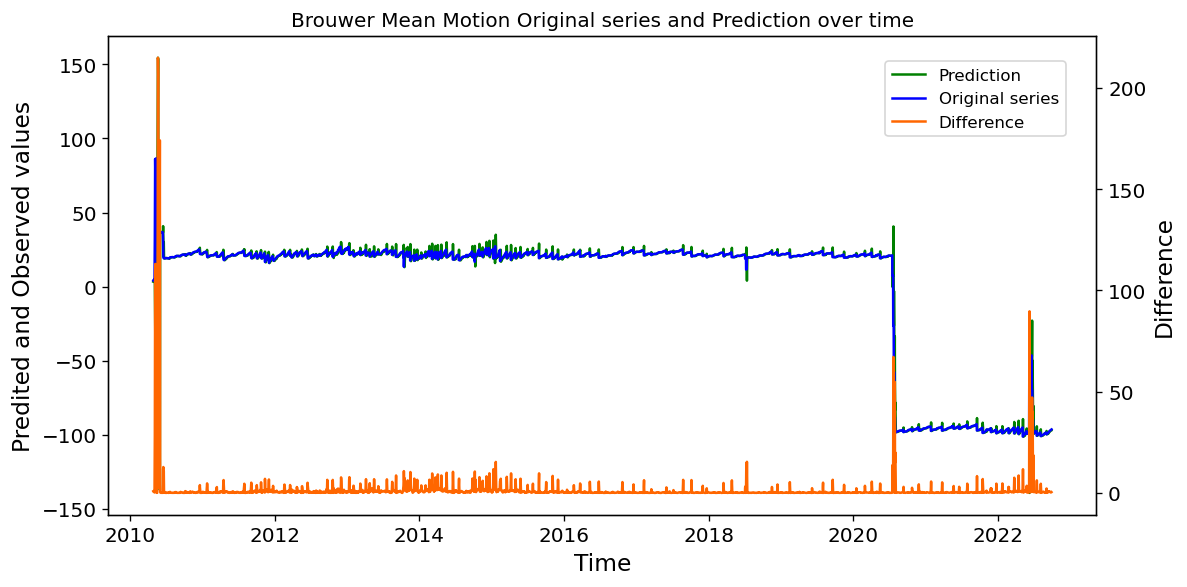

In [290]:
# evaluate forecasts
pd_df_Cryo_bmm_Arima_pred['Difference']=abs(pd_df_Cryo_bmm_Arima_pred['Prediction']-pd_df_Cryo_bmm_Arima_pred['Observed'])
print('RMSE: %.3f' % dec_Cryo_bmm_Arima_pred_RMSE)
print('AIC: %.3f' % dec_Cryo_bmm_Arima_pred_AIC)
print('BIC: %.3f' % dec_Cryo_bmm_Arima_pred_BIC)

# pd_df_Cryo_GrdTrth=data[['Satellite','Start Date','End Date']]

# plot forecasts against actual outcomes
x=pd_df_Cryo_bmm_Arima_pred['TimeStamp']
y1=pd_df_Cryo_bmm_Arima_pred['Prediction']
y2=pd_df_Cryo_bmm_Arima_pred['Observed']
y3=pd_df_Cryo_bmm_Arima_pred['Difference']

fig, ax = plt.subplots(figsize = (10, 5))
plt.title('Brouwer Mean Motion Original series and Prediction over time')
 
ax2 = ax.twinx()
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))
 
ax.set_xlabel('Time')
ax.set_ylabel('Predited and Observed values')
ax2.set_ylabel('Difference')
 
plt.tight_layout()
fig.legend(['Prediction','Original series','Difference'], loc='upper right', bbox_to_anchor=(0.9, 0.9))
 
# show plot
plt.show()


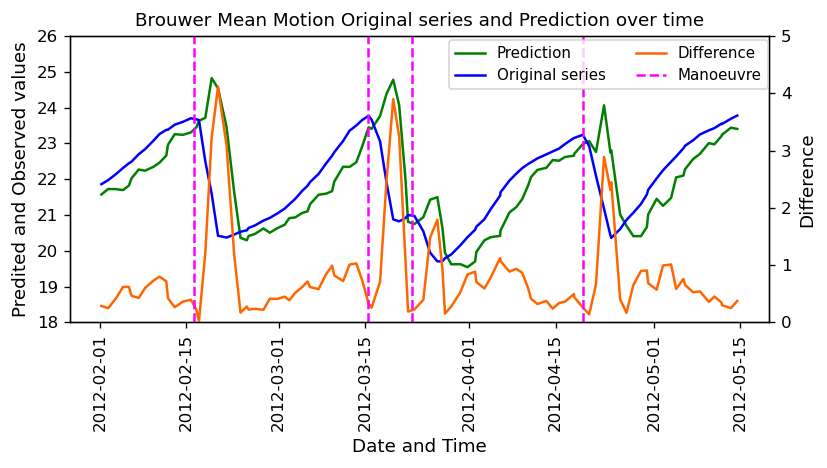

In [167]:
pd_df_Cryo_bmm_Arima_pred['TimeStamp'] = pd.to_datetime(pd_df_Cryo_bmm_Arima_pred['TimeStamp'])
pd_df_Cryo_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Cryo_GrdTrth['Start Date'])

# Define the start and end date for the filter
start_date = '2012-02-01'
end_date = '2012-05-15'

# Filter the DataFrame for rows where 'TimeStamp' is within the first few months of 2012
subset = pd_df_Cryo_bmm_Arima_pred[
    (pd_df_Cryo_bmm_Arima_pred['TimeStamp'] >= start_date) &
    (pd_df_Cryo_bmm_Arima_pred['TimeStamp'] <= end_date)]
GrdTrth = pd_df_Cryo_GrdTrth[
    (pd_df_Cryo_GrdTrth['Start Date'] >= start_date) &
    (pd_df_Cryo_GrdTrth['Start Date'] <= end_date)]

# plot forecasts against actual outcomes
x=subset['TimeStamp']
y1=subset['Prediction']
y2=subset['Observed']
y3=subset['Difference']

fig, ax = plt.subplots(figsize = (7, 4))
plt.title('Brouwer Mean Motion Original series and Prediction over time', fontsize = 11)

ax.tick_params(axis='x', labelrotation=90, labelsize=10)
ax.tick_params(axis='y', labelsize=10)

ax2 = ax.twinx()
ax2.tick_params(axis='y', labelsize=10)
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))

xcoords = GrdTrth['Start Date']
for xc in xcoords:
    plt.axvline(x=xc,color='magenta',label="Manoeuvre",linestyle='dashed')
 
ax.set_xlabel('Date and Time', fontsize = 11)
ax.set_ylabel('Predited and Observed values', fontsize = 11)
ax2.set_ylabel('Difference', fontsize = 11)

ax.set_ylim(18, 26)
ax2.set_ylim(0, 5)

plt.tight_layout()
fig.legend(['Prediction','Original series','Difference','Manoeuvre'], loc='upper right', 
           bbox_to_anchor=(0.93, 0.92), fontsize = 9, ncol=2)
# show plot
plt.show()

## 2.9 Highlight Anomalies for best p,d,q

In [292]:
# Determine Threshold value

s=pd_df_Cryo_bmm_Arima_pred['Difference']

# Define the threshold values
pd_lst_quan = [0.05, 0.5, 0.75, 0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

# Calculate the quantile threshold values
pd_lst_thres = s.quantile(pd_lst_quan)

# Calculate the count of data points above each threshold value
pd_lst_counts = [(s > threshold).sum() for threshold in pd_lst_thres]

# Create a DataFrame with the quantiles, threshold values, and counts
pd_df_thresh = pd.DataFrame({
    'Quantile': pd_lst_quan,
    'Threshold Value': pd_lst_thres.values,
    'Count': pd_lst_counts})
print(pd_df_thresh)



    Quantile Threshold Value  Count
0       0.05        0.017549   4089
1       0.50         0.29441   2152
2       0.75        0.626398   1076
3       0.80        0.797458    861
4       0.85        1.032694    646
5       0.90        1.658216    431
6       0.91        1.817755    388
7       0.92        2.150483    345
8       0.93        2.511122    302
9       0.94        3.004462    259
10      0.95        3.476129    216
11      0.96         4.19163    173
12      0.97        5.221693    130
13      0.98        6.942953     87
14      0.99       10.632542     44


In [293]:
# choose threshold
threshold = pd_df_thresh.loc[pd_df_thresh['Quantile'] == 0.94, 'Threshold Value'].values[0]
print(threshold)

pd_df_Cryo_bmm_Arima_anom = detect_anomalies(pd_df_Cryo_bmm_Arima_pred, threshold)

# pd_df_Cryo_bmm_Arima_anom.iloc[220:270]

3.004462136454319


In [294]:
# Add Manoeuvre column to show the ground truth manoevres (with a 3 day gray area)
pd_df_Cryo_bmm_Arima_anom['Manoeuvre'] = 'No'

# Iterate over the Cryo_GrdTrth DataFrame and update pd_df_Cryo_bmm_Arima_anom['Manoeuvre']
for _, row in pd_df_Cryo_GrdTrth.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']
    
    # for each row in pd_df_Cryo_bmm_Arima_anom, calculate a boolean called in_gray_zone and 
    # set it to True if it is within 1 day of the start time or within 3 days of the finish time of a logged Manoeuvre
    in_gray_zone = (
        (pd_df_Cryo_bmm_Arima_anom['TimeStamp'] >= (start_date + pd.Timedelta(days=2))) & 
        (pd_df_Cryo_bmm_Arima_anom['TimeStamp'] <= (end_date + pd.Timedelta(days=4)))
    )
    
    # Update the 'Manoeuvre' column to 'Yes' if in_gray_zone is True
    pd_df_Cryo_bmm_Arima_anom.loc[in_gray_zone, 'Manoeuvre'] = 'Yes'

    
test=pd_df_Cryo_bmm_Arima_anom[['TimeStamp','Difference', 'Anomaly','Manoeuvre']]

for x in range(0,20):
    subset=test[50*x:50*(x+1)]
    print(subset)


                    TimeStamp  Difference Anomaly Manoeuvre
0  2010-04-28 12:59:36.035519     0.77759      No        No
1  2010-04-29 00:34:12.213407    0.675305      No        No
2  2010-04-30 09:38:46.889375    0.625627      No        No
3  2010-05-01 12:06:26.644320    0.797556      No        No
4  2010-05-02 12:54:52.673760    0.592005      No        No
5  2010-05-03 13:43:18.741216    0.306255      No        No
6  2010-05-04 21:08:39.697727    0.196423      No        No
7  2010-05-05 00:27:07.147007    0.314427      No        No
8  2010-05-06 12:50:02.311008    27.95737     Yes       Yes
9  2010-05-08 02:52:25.312224  108.725674     Yes       Yes
10 2010-05-09 00:21:48.377664  113.063722     Yes       Yes
11 2010-05-10 11:05:21.007680   60.510654     Yes       Yes
12 2010-05-11 13:32:48.308064    8.988529     Yes        No
13 2010-05-12 20:57:54.779615    9.577119     Yes        No
14 2010-05-13 11:50:51.500832    0.530897      No        No
15 2010-05-14 20:55:10.915967     0.2076

                     TimeStamp Difference Anomaly Manoeuvre
750 2012-05-25 20:43:18.944544   0.382922      No        No
751 2012-05-26 08:17:53.968128   0.295616      No        No
752 2012-05-27 09:06:17.526527   0.533988      No        No
753 2012-05-28 14:52:21.767231   0.728011      No        No
754 2012-05-29 22:17:39.566687   0.827351      No        No
755 2012-05-30 01:36:06.679007   0.398767      No        No
756 2012-05-31 10:40:37.964640   0.521692      No        No
757 2012-06-01 14:47:28.482431   0.751153      No        No
758 2012-06-02 22:12:46.118591   0.884783      No        No
759 2012-06-03 03:10:26.764607    0.73032      No        No
760 2012-06-04 10:35:44.380031   0.462651      No        No
761 2012-06-05 13:03:21.260448   0.438286      No        No
762 2012-06-06 22:07:52.363776   0.573211      No        No
763 2012-06-07 19:37:48.510911   0.558668      No        No
764 2012-06-08 20:26:11.769503   0.542268      No        No
765 2012-06-09 19:35:21.432192   0.54350

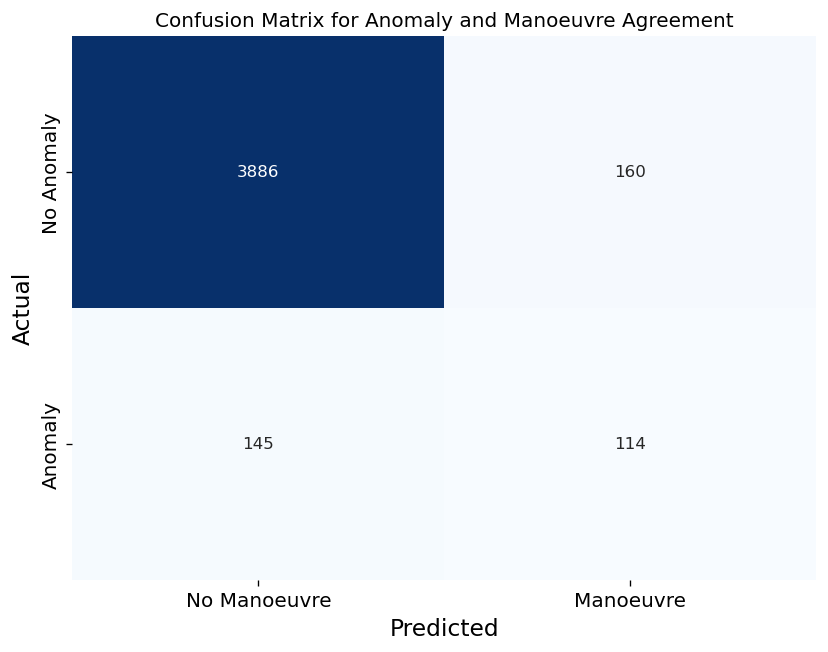

In [295]:
df=pd_df_Cryo_bmm_Arima_anom[['TimeStamp','Anomaly','Manoeuvre']]

# Convert 'yes'/'no' to binary values
df['anomaly_bin'] = df['Anomaly'].map({'Yes': 1, 'No': 0})
df['manoeuvre_bin'] = df['Manoeuvre'].map({'Yes': 1, 'No': 0})

# Create confusion matrix
cm = confusion_matrix(df['anomaly_bin'], df['manoeuvre_bin'])

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=['No Anomaly', 'Anomaly'], columns=['No Manoeuvre', 'Manoeuvre'])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sb.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Anomaly and Manoeuvre Agreement')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 3. Model Jason 1

## 3.1 Import Data

In [7]:
pd_df_Jas1_UnProp = pd.read_csv(r"C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\orbital_elements\unpropagated_elements_Jason-1.csv",parse_dates=True)
pd_df_Jas1_UnProp = pd_df_Jas1_UnProp.rename(columns={'Unnamed: 0': 'TimeStamp','eccentricity':'Eccentricity'})
pd_df_Jas1_UnProp = pd_df_Jas1_UnProp.rename(columns={'inclination': 'Inclination','mean anomaly':'Mean Anomaly'})
pd_df_Jas1_UnProp = pd_df_Jas1_UnProp.rename(columns={'argument of perigee': 'Argument of Perigee'})
pd_df_Jas1_UnProp = pd_df_Jas1_UnProp.rename(columns={'Brouwer mean motion': 'Brouwer Mean Motion'})
pd_df_Jas1_UnProp = pd_df_Jas1_UnProp.rename(columns={'right ascension':'Right Ascension'})
pd_df_Jas1_UnProp['TimeStamp'] = pd.to_datetime(pd_df_Jas1_UnProp['TimeStamp'])
pd_df_Jas1_UnProp


TimeStamp  Eccentricity  Argument of Perigee  \
0    2001-12-22 04:13:05.190527      0.000851             4.661221   
1    2001-12-23 23:23:38.458751      0.000839             4.615654   
2    2001-12-24 23:45:59.288255      0.000836             4.609627   
3    2001-12-25 22:15:50.795999      0.000830             4.597215   
4    2001-12-26 11:23:15.892799      0.000822             4.593359   
...                         ...           ...                  ...   
3991 2013-05-27 20:10:28.445664      0.000840             4.913053   
3992 2013-05-30 02:15:06.984575      0.000847             4.901185   
3993 2013-06-01 11:45:57.436703      0.000856             4.889407   
3994 2013-06-03 20:24:01.368576      0.000859             4.890667   
3995 2013-06-06 02:07:13.832255      0.000865             4.885842   

      Inclination  Mean Anomaly  Brouwer Mean Motion  Right Ascension  
0        1.152701     -4.846921             0.055877         6.092690  
1        1.152689     -4.615556             0.055877         6.027578  
2        1.152690     -4.609521             0.055878         5.990822  
3        1.152689     -4.597084             0.055878         5.956886  
4        1.152684     -4.593216             0.055878         5.937093  
...           ...           ...                  ...              ...  
3991     1.152633     -2.332018             0.056038         5.476089  
3992     1.152631     -2.779852             0.056038         5.393956  
3993     1.152635     -4.243651             0.056038         5.306602  
3994     1.152642     -2.393515             0.056038         5.220585  
3995     1.152643     -4.048989             0.056038         5.138998  

[3996 rows x 7 columns]

In [8]:
pd_df_Jas1_UnProp.info()
size=len(pd_df_Jas1_UnProp)
split=round(0.85*size)
pd_df_Jas1_UnProp_train, pd_df_Jas1_UnProp_test = pd_df_Jas1_UnProp[0:split], pd_df_Jas1_UnProp[split:size]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3996 entries, 0 to 3995
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   TimeStamp            3996 non-null   datetime64[ns]
 1   Eccentricity         3996 non-null   float64       
 2   Argument of Perigee  3996 non-null   float64       
 3   Inclination          3996 non-null   float64       
 4   Mean Anomaly         3996 non-null   float64       
 5   Brouwer Mean Motion  3996 non-null   float64       
 6   Right Ascension      3996 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 218.7 KB


In [169]:
# Read the fixed-width formatted text file into a DataFrame
file_path = r"C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\manoeuvres\Jason1-ja1man.txt"
data = pd.read_fwf(file_path, header=None)
data = data.rename(columns={0: 'Satellite'})
data['Start Date'] = pd.to_datetime(data[1].astype(str) + data[2].astype(str).str.zfill(3) + 
                                    data[3].astype(str).str.zfill(2) + data[4].astype(str).str.zfill(2), format='%Y%j%H%M')
data['End Date'] = pd.to_datetime(data[5].astype(str) + data[6].astype(str).str.zfill(3) + 
                                  data[7].astype(str).str.zfill(2) + data[8].astype(str).str.zfill(2), format='%Y%j%H%M')
pd_df_Jas1_GrdTrth=data[['Satellite','Start Date','End Date']]

# Display the DataFrame
print(pd_df_Jas1_GrdTrth.head(10))
int_Jas1_num_man=pd_df_Jas1_GrdTrth.shape[0]
print(int_Jas1_num_man)



  Satellite          Start Date            End Date
0     JASO1 2001-12-11 13:08:00 2001-12-11 15:57:00
1     JASO1 2001-12-13 21:17:00 2001-12-14 00:06:00
2     JASO1 2001-12-17 07:35:00 2001-12-17 10:31:00
3     JASO1 2001-12-20 06:45:00 2001-12-20 09:39:00
4     JASO1 2002-01-10 01:49:00 2002-01-10 04:40:00
5     JASO1 2002-01-13 01:03:00 2002-01-13 03:53:00
6     JASO1 2002-02-04 00:45:00 2002-02-04 03:34:00
7     JASO1 2002-03-05 18:40:00 2002-03-05 19:37:00
8     JASO1 2002-05-14 04:30:00 2002-05-14 05:27:00
9     JASO1 2002-07-02 18:23:00 2002-07-02 19:20:00
119


## 3.2 Prepare individual dataframes per element

                   TimeStamp  Brouwer Mean Motion
0 2001-12-22 04:13:05.190527          -297.367965
1 2001-12-23 23:23:38.458751          -296.866863
2 2001-12-24 23:45:59.288255          -296.794929
3 2001-12-25 22:15:50.795999          -296.710994
4 2001-12-26 11:23:15.892799          -296.744298


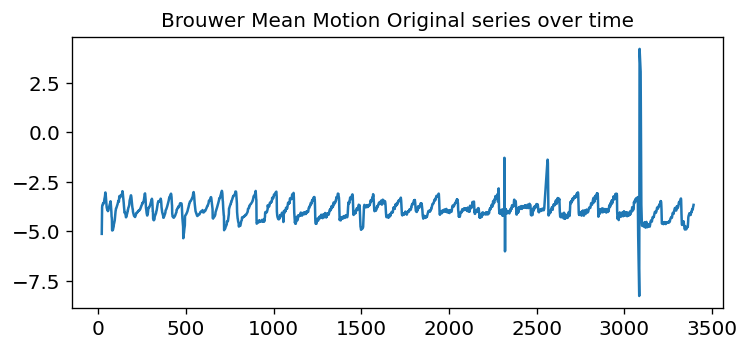

In [309]:
# Scale ['Brouwer mean motion'] to larger numbers
pd_df_Jas1_bmm=pd_df_Jas1_UnProp_train[['TimeStamp', 'Brouwer Mean Motion']]

pd_df_Jas1_bmm['Brouwer Mean Motion'] = (pd_df_Jas1_bmm['Brouwer Mean Motion'] - pd_df_Jas1_bmm['Brouwer Mean Motion'].mean()) * 10000000
print(pd_df_Jas1_bmm.head())

pd_df_Jas1_bmm = pd_df_Jas1_bmm[pd_df_Jas1_bmm['Brouwer Mean Motion'] <= 5]
pd_df_Jas1_bmm = pd_df_Jas1_bmm[pd_df_Jas1_bmm['Brouwer Mean Motion'] >= -10]

plt.rcParams.update({'figure.figsize':(7,3), 'figure.dpi':120})
plt.plot(pd_df_Jas1_bmm['Brouwer Mean Motion'])
plt.title('Brouwer Mean Motion Original series over time')
plt.show()

## 3.3 Propagate elements

In [310]:
(pd_df_Jas1_bmm_Arima_pred,dec_Jas1_bmm_Arima_pred_RMSE, dec_Jas1_bmm_Arima_pred_AIC, dec_Jas1_bmm_Arima_pred_BIC
)=Fit_Predict_Arima(pd_df_Jas1_bmm,'Brouwer Mean Motion',1,1,1)


RMSE: 0.320
AIC: 0.416
BIC: -3.504


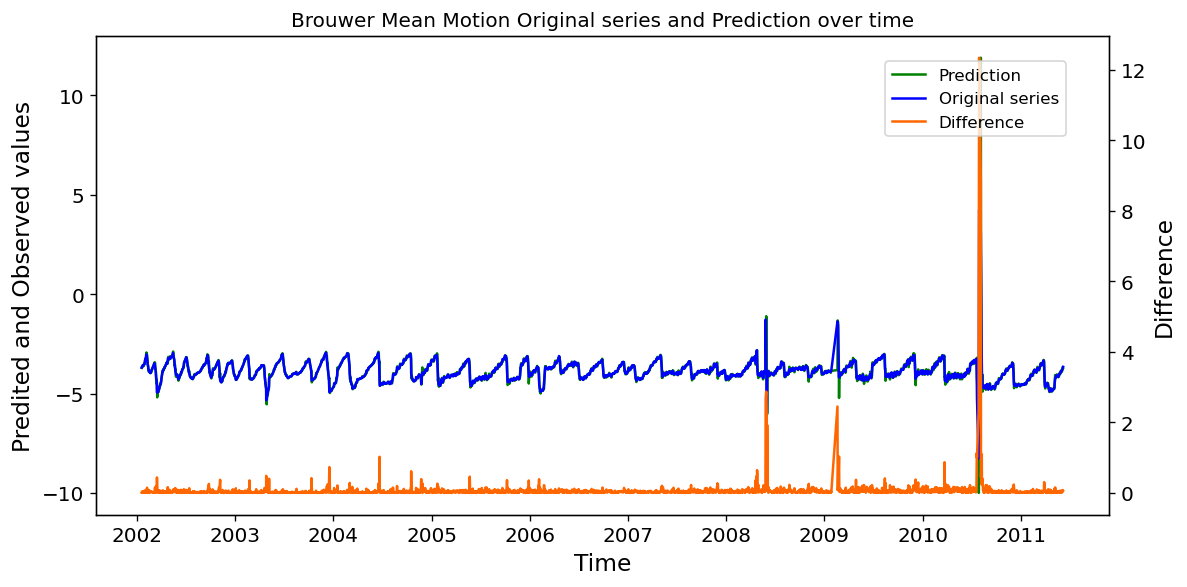

In [311]:
# evaluate forecasts
pd_df_Jas1_bmm_Arima_pred['Difference']=abs(pd_df_Jas1_bmm_Arima_pred['Prediction']-pd_df_Jas1_bmm_Arima_pred['Observed'])
print('RMSE: %.3f' % dec_Jas1_bmm_Arima_pred_RMSE)
print('AIC: %.3f' % dec_Jas1_bmm_Arima_pred_AIC)
print('BIC: %.3f' % dec_Jas1_bmm_Arima_pred_BIC)

# pd_df_Jas1_GrdTrth=data[['Satellite','Start Date','End Date']]

# plot forecasts against actual outcomes
x=pd_df_Jas1_bmm_Arima_pred['TimeStamp']
y1=pd_df_Jas1_bmm_Arima_pred['Prediction']
y2=pd_df_Jas1_bmm_Arima_pred['Observed']
y3=pd_df_Jas1_bmm_Arima_pred['Difference']

fig, ax = plt.subplots(figsize = (10, 5))
plt.title('Brouwer Mean Motion Original series and Prediction over time')
 
ax2 = ax.twinx()
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))
 
ax.set_xlabel('Time')
ax.set_ylabel('Predited and Observed values')
ax2.set_ylabel('Difference')
 
plt.tight_layout()
fig.legend(['Prediction','Original series','Difference'], loc='upper right', bbox_to_anchor=(0.9, 0.9))
 
# show plot
plt.show()


C:\Users\aloci\AppData\Local\Temp\ipykernel_4888\1981562620.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df_Jas1_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Jas1_GrdTrth['Start Date'])


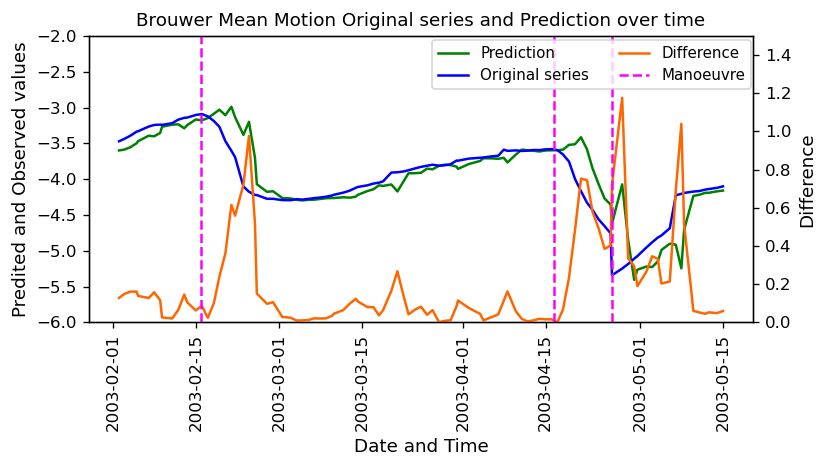

In [175]:
pd_df_Jas1_bmm_Arima_pred['TimeStamp'] = pd.to_datetime(pd_df_Jas1_bmm_Arima_pred['TimeStamp'])
pd_df_Jas1_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Jas1_GrdTrth['Start Date'])

# Define the start and end date for the filter
start_date = '2003-02-01'
end_date = '2003-05-15'

# Filter the DataFrame for rows where 'TimeStamp' is within the first few months of 2012
subset = pd_df_Jas1_bmm_Arima_pred[
    (pd_df_Jas1_bmm_Arima_pred['TimeStamp'] >= start_date) &
    (pd_df_Jas1_bmm_Arima_pred['TimeStamp'] <= end_date)]
GrdTrth = pd_df_Jas1_GrdTrth[
    (pd_df_Jas1_GrdTrth['Start Date'] >= start_date) &
    (pd_df_Jas1_GrdTrth['Start Date'] <= end_date)]

# plot forecasts against actual outcomes
x=subset['TimeStamp']
y1=subset['Prediction']
y2=subset['Observed']
y3=subset['Difference']

fig, ax = plt.subplots(figsize = (7, 4))
plt.title('Brouwer Mean Motion Original series and Prediction over time', fontsize = 11)

ax.tick_params(axis='x', labelrotation=90, labelsize=10)
ax.tick_params(axis='y', labelsize=10)

ax2 = ax.twinx()
ax2.tick_params(axis='y', labelsize=10)
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))

xcoords = GrdTrth['Start Date']
for xc in xcoords:
    plt.axvline(x=xc,color='magenta',label="Manoeuvre",linestyle='dashed')
 
ax.set_xlabel('Date and Time', fontsize = 11)
ax.set_ylabel('Predited and Observed values', fontsize = 11)
ax2.set_ylabel('Difference', fontsize = 11)

ax.set_ylim(-6, -2)
ax2.set_ylim(0, 1.5)

plt.tight_layout()
fig.legend(['Prediction','Original series','Difference','Manoeuvre'], loc='upper right', 
           bbox_to_anchor=(0.91, 0.92), fontsize = 9, ncol=2)
# show plot
plt.show()

## 3.4 Find optimal p,d,q for Brouwer Mean Motion

In [316]:
# Define the values for p, d, and q
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]

# Generate all combinations of p, d, q
combinations = list(product(p_values, d_values, q_values))

# Create a DataFrame from the combinations
pd_df_combos = pd.DataFrame(combinations, columns=['p', 'd', 'q'])


In [317]:
pd_df_Jas1_best_metrics = pd.DataFrame(columns=['Model (p,d,q)', 'RMSE', 'AIC','BIC'])

for index,row in pd_df_combos.iterrows():
    p = row['p']
    d = row['d']
    q = row['q']
    print(p,d,q)
        
    (output,RMSE, AIC, BIC)=Fit_Predict_Arima(pd_df_Jas1_bmm,'Brouwer Mean Motion',p,d,q)
    
    pd_df_Jas1_best_metrics = pd_df_Jas1_best_metrics.append({'Model (p,d,q)': 'Model - ('+ str(p) +',' + str(d) +','+ str(q)+ ')',
                'RMSE': RMSE, 'AIC': AIC, 'BIC': BIC}, ignore_index=True)

print(pd_df_Jas1_best_metrics)
        
    

0 0 0
0 0 1
0 0 2
0 1 0
0 1 1
0 1 2
1 0 0
1 0 1
1 0 2
1 1 0
1 1 1
1 1 2
2 0 0
2 0 1
2 0 2
2 1 0
2 1 1
2 1 2
      Model (p,d,q)      RMSE       AIC        BIC
0   Model - (0,0,0)  0.288851 -6.298598  -8.101373
1   Model - (0,0,1)  0.351949 -5.188482  -7.892646
2   Model - (0,0,2)  0.316178 -3.444129   -7.04968
3   Model - (0,1,0)  0.214878 -3.503518  -4.810371
4   Model - (0,1,1)  0.260029 -1.583502  -4.197208
5   Model - (0,1,2)  0.288597  0.416498  -3.504061
6   Model - (1,0,0)  0.336667  -4.38447  -7.088633
7   Model - (1,0,1)  0.384543 -3.218614  -6.824165
8   Model - (1,0,2)  0.341307 -1.571618  -6.078557
9   Model - (1,1,0)  0.308944 -1.583503  -4.197208
10  Model - (1,1,1)  0.320243  0.416497  -3.504061
11  Model - (1,1,2)  0.323532  2.416497  -2.810914
12  Model - (2,0,0)  0.521857   -6.7629 -10.368451
13  Model - (2,0,1)  0.563647 -6.195813 -10.702752
14  Model - (2,0,2)  0.394319 -7.764525 -13.172851
15  Model - (2,1,0)  0.308965  0.416498  -3.504061
16  Model - (2,1,1)  0.31

In [133]:
#  Choose Best

best_Jas1_rmse_model = pd_df_Jas1_best_metrics.loc[pd_df_Jas1_best_metrics['RMSE']==pd_df_Jas1_best_metrics['RMSE'].min(),'Model (p,d,q)']
best_Jas1_aic_model = pd_df_Jas1_best_metrics.loc[pd_df_Jas1_best_metrics['AIC']==pd_df_Jas1_best_metrics['AIC'].min(),'Model (p,d,q)']
best_Jas1_bic_model = pd_df_Jas1_best_metrics.loc[pd_df_Jas1_best_metrics['BIC']==pd_df_Jas1_best_metrics['BIC'].min(),'Model (p,d,q)']

print('Best model by RMSE: '+best_Jas1_rmse_model)
print('Best model by AIC: '+best_Jas1_aic_model)
print('Best model by BIC: '+best_Jas1_bic_model)


## 3.5 Propagate elements for best p,d,q

In [319]:
(pd_df_Jas1_bmm_Arima_pred,dec_Jas1_bmm_Arima_pred_RMSE, dec_Jas1_bmm_Arima_pred_AIC, dec_Jas1_bmm_Arima_pred_BIC
)=Fit_Predict_Arima(pd_df_Jas1_bmm,'Brouwer Mean Motion',2,0,0)
# print(model_fit.summary())

RMSE: 0.522
AIC: -6.763
BIC: -10.368


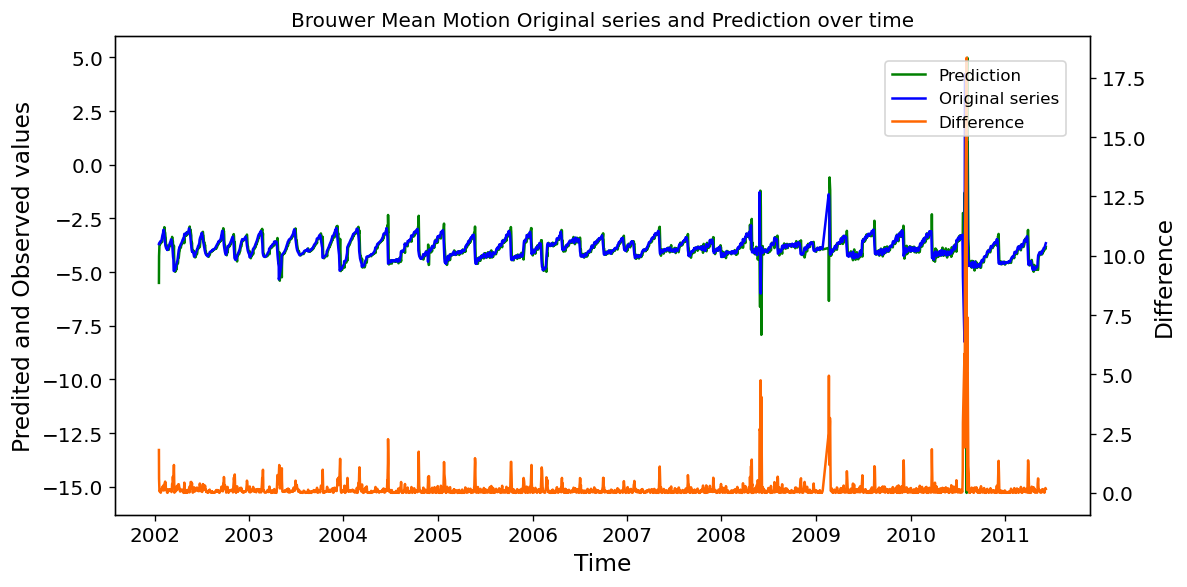

In [320]:
# evaluate forecasts
pd_df_Jas1_bmm_Arima_pred['Difference']=abs(pd_df_Jas1_bmm_Arima_pred['Prediction']-pd_df_Jas1_bmm_Arima_pred['Observed'])
print('RMSE: %.3f' % dec_Jas1_bmm_Arima_pred_RMSE)
print('AIC: %.3f' % dec_Jas1_bmm_Arima_pred_AIC)
print('BIC: %.3f' % dec_Jas1_bmm_Arima_pred_BIC)

# pd_df_Jas1_GrdTrth=data[['Satellite','Start Date','End Date']]

# plot forecasts against actual outcomes
x=pd_df_Jas1_bmm_Arima_pred['TimeStamp']
y1=pd_df_Jas1_bmm_Arima_pred['Prediction']
y2=pd_df_Jas1_bmm_Arima_pred['Observed']
y3=pd_df_Jas1_bmm_Arima_pred['Difference']

fig, ax = plt.subplots(figsize = (10, 5))
plt.title('Brouwer Mean Motion Original series and Prediction over time')
 
ax2 = ax.twinx()
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))
 
ax.set_xlabel('Time')
ax.set_ylabel('Predited and Observed values')
ax2.set_ylabel('Difference')
 
plt.tight_layout()
fig.legend(['Prediction','Original series','Difference'], loc='upper right', bbox_to_anchor=(0.9, 0.9))
 
# show plot
plt.show()


C:\Users\aloci\AppData\Local\Temp\ipykernel_4888\3036532197.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df_Jas1_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Jas1_GrdTrth['Start Date'])


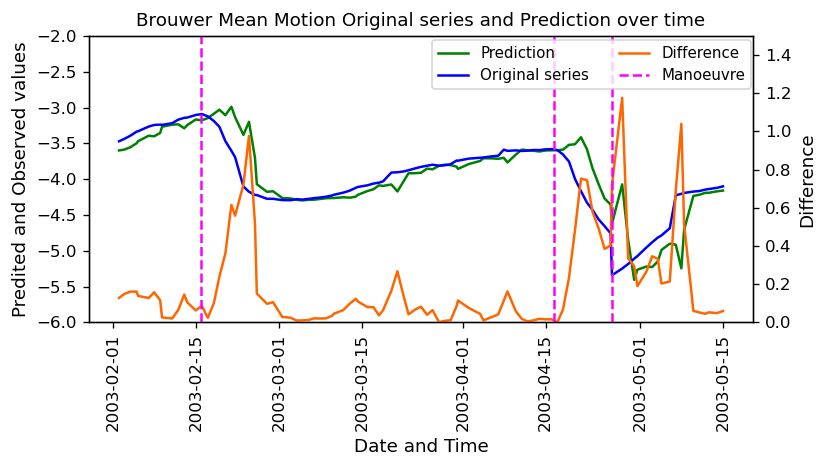

In [176]:
pd_df_Jas1_bmm_Arima_pred['TimeStamp'] = pd.to_datetime(pd_df_Jas1_bmm_Arima_pred['TimeStamp'])
pd_df_Jas1_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Jas1_GrdTrth['Start Date'])

# Define the start and end date for the filter
start_date = '2003-02-01'
end_date = '2003-05-15'

# Filter the DataFrame for rows where 'TimeStamp' is within the first few months of 2012
subset = pd_df_Jas1_bmm_Arima_pred[
    (pd_df_Jas1_bmm_Arima_pred['TimeStamp'] >= start_date) &
    (pd_df_Jas1_bmm_Arima_pred['TimeStamp'] <= end_date)]
GrdTrth = pd_df_Jas1_GrdTrth[
    (pd_df_Jas1_GrdTrth['Start Date'] >= start_date) &
    (pd_df_Jas1_GrdTrth['Start Date'] <= end_date)]

# plot forecasts against actual outcomes
x=subset['TimeStamp']
y1=subset['Prediction']
y2=subset['Observed']
y3=subset['Difference']

fig, ax = plt.subplots(figsize = (7, 4))
plt.title('Brouwer Mean Motion Original series and Prediction over time', fontsize = 11)

ax.tick_params(axis='x', labelrotation=90, labelsize=10)
ax.tick_params(axis='y', labelsize=10)

ax2 = ax.twinx()
ax2.tick_params(axis='y', labelsize=10)
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))

xcoords = GrdTrth['Start Date']
for xc in xcoords:
    plt.axvline(x=xc,color='magenta',label="Manoeuvre",linestyle='dashed')
 
ax.set_xlabel('Date and Time', fontsize = 11)
ax.set_ylabel('Predited and Observed values', fontsize = 11)
ax2.set_ylabel('Difference', fontsize = 11)

ax.set_ylim(-6, -2)
ax2.set_ylim(0, 1.5)

plt.tight_layout()
fig.legend(['Prediction','Original series','Difference','Manoeuvre'], loc='upper right', 
           bbox_to_anchor=(0.91, 0.92), fontsize = 9, ncol=2)
 
# show plot
plt.show()

## 3.6 Highlight Anomalies for best p,d,q

In [323]:
# Determine Threshold value

s=pd_df_Jas1_bmm_Arima_pred['Difference']

# Define the threshold values
pd_lst_quan = [0.05, 0.5, 0.75, 0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

# Calculate the quantile threshold values
pd_lst_thres = s.quantile(pd_lst_quan)

# Calculate the count of data points above each threshold value
pd_lst_counts = [(s > threshold).sum() for threshold in pd_lst_thres]

# Create a DataFrame with the quantiles, threshold values, and counts
pd_df_thresh = pd.DataFrame({
    'Quantile': pd_lst_quan,
    'Threshold Value': pd_lst_thres.values,
    'Count': pd_lst_counts})
print(pd_df_thresh)



    Quantile Threshold Value  Count
0       0.05        0.007292   3178
1       0.50        0.076954   1673
2       0.75        0.139567    837
3       0.80        0.166078    669
4       0.85        0.207611    502
5       0.90        0.270075    335
6       0.91        0.293188    302
7       0.92        0.323581    268
8       0.93        0.360835    235
9       0.94        0.406712    201
10      0.95        0.469519    168
11      0.96        0.559451    134
12      0.97         0.66557    101
13      0.98        0.883005     67
14      0.99        1.334185     34


In [324]:
# choose threshold
threshold = pd_df_thresh.loc[pd_df_thresh['Quantile'] == 0.94, 'Threshold Value'].values[0]
print(threshold)

pd_df_Jas1_bmm_Arima_anom = detect_anomalies(pd_df_Jas1_bmm_Arima_pred, threshold)

# pd_df_Jas1_bmm_Arima_anom.iloc[220:270]

0.4067116793966445


In [325]:
# Add Manoeuvre column to show the ground truth manoevres (with a 3 day gray area)
pd_df_Jas1_bmm_Arima_anom['Manoeuvre'] = 'No'

# Iterate over the Jas1_GrdTrth DataFrame and update pd_df_Jas1_bmm_Arima_anom['Manoeuvre']
for _, row in pd_df_Jas1_GrdTrth.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']
    
    # for each row in pd_df_Jas1_bmm_Arima_anom, calculate a boolean called in_gray_zone and 
    # set it to True if it is within 1 day of the start time or within 3 days of the finish time of a logged Manoeuvre
    in_gray_zone = (
        (pd_df_Jas1_bmm_Arima_anom['TimeStamp'] >= (start_date + pd.Timedelta(days=2))) & 
        (pd_df_Jas1_bmm_Arima_anom['TimeStamp'] <= (end_date + pd.Timedelta(days=4)))
    )
    
    # Update the 'Manoeuvre' column to 'Yes' if in_gray_zone is True
    pd_df_Jas1_bmm_Arima_anom.loc[in_gray_zone, 'Manoeuvre'] = 'Yes'

    
test=pd_df_Jas1_bmm_Arima_anom[['TimeStamp','Difference', 'Anomaly','Manoeuvre']]

for x in range(0,20):
    subset=test[50*x:50*(x+1)]
    print(subset)


                    TimeStamp Difference Anomaly Manoeuvre
0  2002-01-17 19:29:07.833408   1.809127     Yes        No
1  2002-01-18 06:43:42.494016    0.60176     Yes        No
2  2002-01-19 20:12:17.718336    0.08506      No        No
3  2002-01-20 20:33:52.598591    0.05328      No        No
4  2002-01-21 19:03:01.677024   0.089078      No        No
5  2002-01-22 11:54:53.520192   0.120893      No        No
6  2002-01-23 19:46:11.426304   0.039366      No        No
7  2002-01-24 18:15:20.515104   0.007995      No        No
8  2002-01-25 18:36:55.345247   0.044515      No        No
9  2002-01-26 18:58:30.173663   0.083373      No        No
10 2002-01-27 19:20:05.029728   0.089327      No        No
11 2002-01-28 17:49:14.055455   0.131194      No        No
12 2002-01-29 21:55:40.341504    0.22133      No        No
13 2002-01-30 16:39:57.841343   0.255474      No        No
14 2002-01-31 03:54:32.348160   0.207109      No        No
15 2002-02-01 17:23:07.335744   0.180951      No        

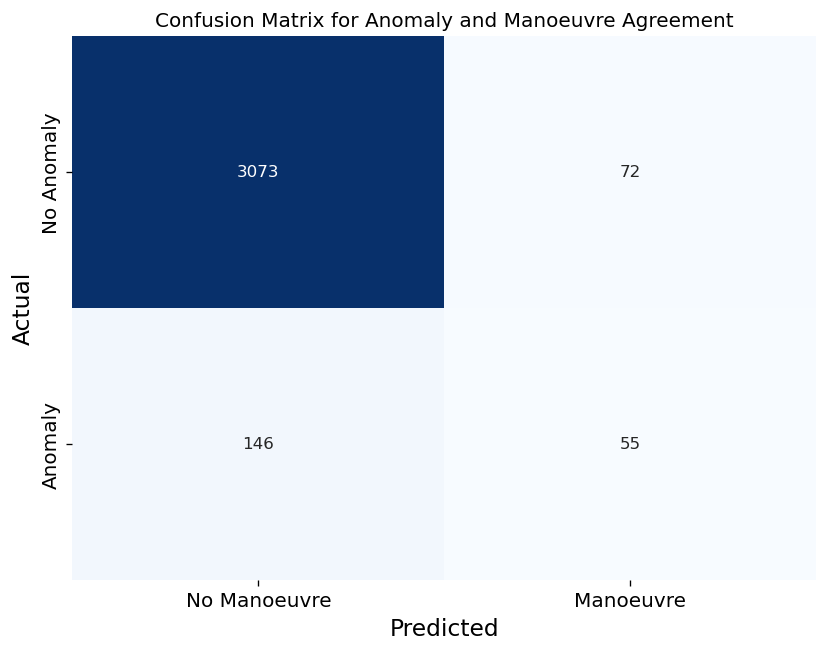

In [326]:
df=pd_df_Jas1_bmm_Arima_anom[['TimeStamp','Anomaly','Manoeuvre']]

# Convert 'yes'/'no' to binary values
df['anomaly_bin'] = df['Anomaly'].map({'Yes': 1, 'No': 0})
df['manoeuvre_bin'] = df['Manoeuvre'].map({'Yes': 1, 'No': 0})

# Create confusion matrix
cm = confusion_matrix(df['anomaly_bin'], df['manoeuvre_bin'])

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=['No Anomaly', 'Anomaly'], columns=['No Manoeuvre', 'Manoeuvre'])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sb.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Anomaly and Manoeuvre Agreement')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 4. Model Sentinel 3A

## 4.1 Import Data

In [86]:
pd_df_Sen3A_UnProp = pd.read_csv(r"C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\orbital_elements\unpropagated_elements_Sentinel-3A.csv",parse_dates=True)
pd_df_Sen3A_UnProp = pd_df_Sen3A_UnProp.rename(columns={'Unnamed: 0': 'TimeStamp','eccentricity':'Eccentricity'})
pd_df_Sen3A_UnProp = pd_df_Sen3A_UnProp.rename(columns={'inclination': 'Inclination','mean anomaly':'Mean Anomaly'})
pd_df_Sen3A_UnProp = pd_df_Sen3A_UnProp.rename(columns={'argument of perigee': 'Argument of Perigee'})
pd_df_Sen3A_UnProp = pd_df_Sen3A_UnProp.rename(columns={'Brouwer mean motion': 'Brouwer Mean Motion'})
pd_df_Sen3A_UnProp = pd_df_Sen3A_UnProp.rename(columns={'right ascension':'Right Ascension'})
pd_df_Sen3A_UnProp['TimeStamp'] = pd.to_datetime(pd_df_Sen3A_UnProp['TimeStamp'])
pd_df_Sen3A_UnProp


TimeStamp  Eccentricity  Argument of Perigee  \
0    2016-03-04 15:21:16.747488      0.000109             1.314804   
1    2016-03-05 03:07:49.774079      0.000116             1.219563   
2    2016-03-06 02:41:39.264000      0.000111             1.172992   
3    2016-03-07 05:37:27.298272      0.000107             1.116070   
4    2016-03-08 03:30:17.538911      0.000107             1.106130   
...                         ...           ...                  ...   
2380 2022-09-25 03:15:40.345632      0.000118             1.700001   
2381 2022-09-26 04:30:28.587167      0.000118             1.696254   
2382 2022-09-27 02:23:18.378527      0.000118             1.697642   
2383 2022-09-28 01:57:07.361279      0.000118             1.696380   
2384 2022-09-29 01:30:56.336255      0.000118             1.695938   

      Inclination  Mean Anomaly  Brouwer Mean Motion  Right Ascension  
0        1.721209     -1.290057              0.06229         2.317569  
1        1.721205     -1.217329              0.06229         2.326014  
2        1.721209     -1.170795              0.06229         2.342892  
3        1.721211     -1.113839              0.06229         2.362184  
4        1.721211     -1.103881              0.06229         2.377852  
...           ...           ...                  ...              ...  
2380     1.721401     -1.697708              0.06229         5.829283  
2381     1.721397     -1.693961              0.06229         5.847384  
2382     1.721394     -1.695348              0.06229         5.863071  
2383     1.721390     -1.694086              0.06229         5.879965  
2384     1.721387     -1.693645              0.06229         5.896858  

[2385 rows x 7 columns]

In [87]:
pd_df_Sen3A_UnProp.info()
size=len(pd_df_Sen3A_UnProp)
split=round(0.85*size)
pd_df_Sen3A_UnProp_train, pd_df_Sen3A_UnProp_test = pd_df_Sen3A_UnProp[0:split], pd_df_Sen3A_UnProp[split:size]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2385 entries, 0 to 2384
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   TimeStamp            2385 non-null   datetime64[ns]
 1   Eccentricity         2385 non-null   float64       
 2   Argument of Perigee  2385 non-null   float64       
 3   Inclination          2385 non-null   float64       
 4   Mean Anomaly         2385 non-null   float64       
 5   Brouwer Mean Motion  2385 non-null   float64       
 6   Right Ascension      2385 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 130.6 KB


In [88]:
# Read the fixed-width formatted text file into a DataFrame
file_path = r"C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\manoeuvres\Sentinel3A-s3aman.txt"
data = pd.read_fwf(file_path, header=None)
data = data.rename(columns={0: 'Satellite'})
data['Start Date'] = pd.to_datetime(data[1].astype(str) + data[2].astype(str).str.zfill(3) + 
                                    data[3].astype(str).str.zfill(2) + data[4].astype(str).str.zfill(2), format='%Y%j%H%M')
data['End Date'] = pd.to_datetime(data[5].astype(str) + data[6].astype(str).str.zfill(3) + 
                                  data[7].astype(str).str.zfill(2) + data[8].astype(str).str.zfill(2), format='%Y%j%H%M')
pd_df_Sen3A_GrdTrth=data[['Satellite','Start Date','End Date']]

# Display the DataFrame
print(pd_df_Sen3A_GrdTrth.head(10))
int_Sen3A_num_man=pd_df_Sen3A_GrdTrth.shape[0]
print(int_Sen3A_num_man)



  Satellite          Start Date            End Date
0     SEN3A 2016-02-22 09:30:00 2016-02-22 12:11:00
1     SEN3A 2016-02-23 10:45:00 2016-02-23 13:24:00
2     SEN3A 2016-02-24 19:29:00 2016-02-24 19:32:00
3     SEN3A 2016-02-26 09:27:00 2016-02-26 12:08:00
4     SEN3A 2016-03-02 12:59:00 2016-03-02 15:33:00
5     SEN3A 2016-03-07 12:21:00 2016-03-07 12:22:00
6     SEN3A 2016-03-21 11:16:00 2016-03-21 11:20:00
7     SEN3A 2016-03-23 13:27:00 2016-03-23 13:27:00
8     SEN3A 2016-04-13 09:11:00 2016-04-13 10:52:00
9     SEN3A 2016-04-19 12:03:00 2016-04-19 12:10:00
64


## 4.2 Prepare individual dataframes per element

C:\Users\aloci\AppData\Local\Temp\ipykernel_4888\2697658845.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df_Sen3A_bmm['Brouwer Mean Motion'] = (pd_df_Sen3A_bmm['Brouwer Mean Motion'] - pd_df_Sen3A_bmm['Brouwer Mean Motion'].mean()) * 10000000


                   TimeStamp  Brouwer Mean Motion
0 2016-03-04 15:21:16.747488            -1.905367
1 2016-03-05 03:07:49.774079            -2.034337
2 2016-03-06 02:41:39.264000            -2.431007
3 2016-03-07 05:37:27.298272            -2.564456
4 2016-03-08 03:30:17.538911            -2.574506


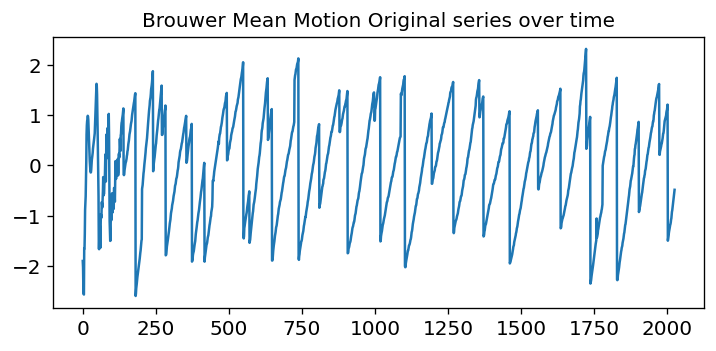

In [90]:
# Scale ['Brouwer mean motion'] to larger numbers
pd_df_Sen3A_bmm=pd_df_Sen3A_UnProp_train[['TimeStamp', 'Brouwer Mean Motion']]

pd_df_Sen3A_bmm['Brouwer Mean Motion'] = (pd_df_Sen3A_bmm['Brouwer Mean Motion'] - pd_df_Sen3A_bmm['Brouwer Mean Motion'].mean()) * 10000000
print(pd_df_Sen3A_bmm.head())

pd_df_Sen3A_bmm = pd_df_Sen3A_bmm[pd_df_Sen3A_bmm['Brouwer Mean Motion'] <= 5]
pd_df_Sen3A_bmm = pd_df_Sen3A_bmm[pd_df_Sen3A_bmm['Brouwer Mean Motion'] >= -10]

plt.rcParams.update({'figure.figsize':(7,3), 'figure.dpi':120})
plt.plot(pd_df_Sen3A_bmm['Brouwer Mean Motion'])
plt.title('Brouwer Mean Motion Original series over time')
plt.show()

In [91]:
mind=pd_df_Sen3A_bmm.loc[pd_df_Sen3A_bmm['TimeStamp']==pd_df_Sen3A_bmm['TimeStamp'].min(),'TimeStamp']
maxd=pd_df_Sen3A_bmm.loc[pd_df_Sen3A_bmm['TimeStamp']==pd_df_Sen3A_bmm['TimeStamp'].max(),'TimeStamp']
print(mind,maxd)

0   2016-03-04 15:21:16.747488
Name: TimeStamp, dtype: datetime64[ns] 2026   2021-10-02 02:56:59.807616
Name: TimeStamp, dtype: datetime64[ns]


## 4.3 Propagate elements

In [49]:
(pd_df_Sen3A_bmm_Arima_pred,dec_Sen3A_bmm_Arima_pred_RMSE, dec_Sen3A_bmm_Arima_pred_AIC, dec_Sen3A_bmm_Arima_pred_BIC
)=Fit_Predict_Arima(pd_df_Sen3A_bmm,'Brouwer Mean Motion',1,1,1)


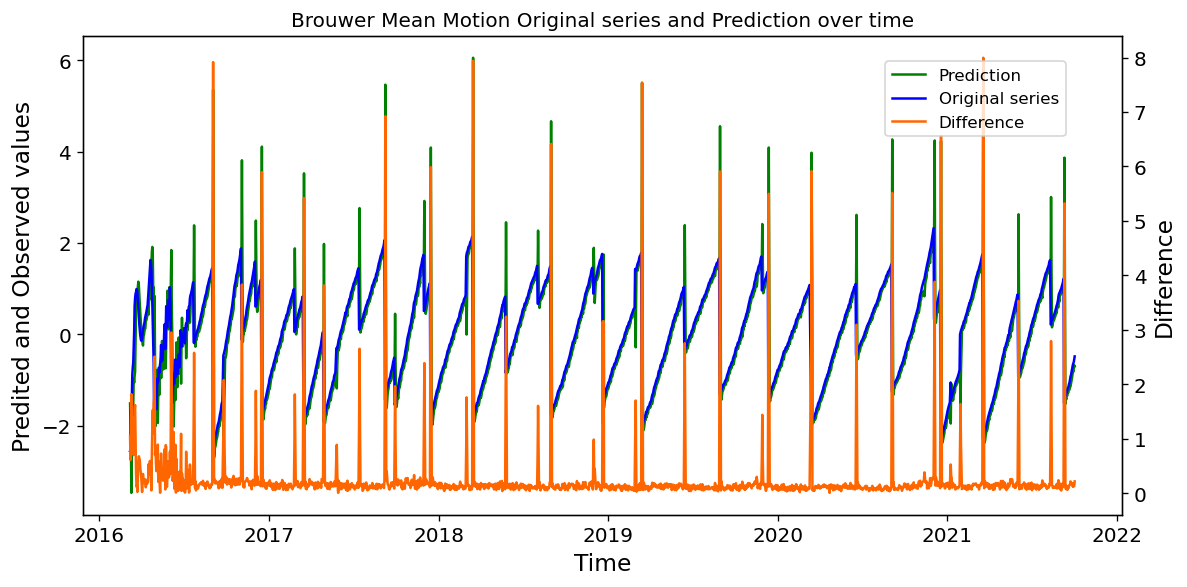

In [101]:
# evaluate forecasts
pd_df_Sen3A_bmm_Arima_pred['Difference']=abs(pd_df_Sen3A_bmm_Arima_pred['Prediction']-pd_df_Sen3A_bmm_Arima_pred['Observed'])
# print('RMSE: %.3f' % dec_Sen3A_bmm_Arima_pred_RMSE)
# print('AIC: %.3f' % dec_Sen3A_bmm_Arima_pred_AIC)
# print('BIC: %.3f' % dec_Sen3A_bmm_Arima_pred_BIC)

# pd_df_Sen3A_GrdTrth=data[['Satellite','Start Date','End Date']]

# plot forecasts against actual outcomes
x=pd_df_Sen3A_bmm_Arima_pred['TimeStamp']
y1=pd_df_Sen3A_bmm_Arima_pred['Prediction']
y2=pd_df_Sen3A_bmm_Arima_pred['Observed']
y3=pd_df_Sen3A_bmm_Arima_pred['Difference']

fig, ax = plt.subplots(figsize = (10, 5))
plt.title('Brouwer Mean Motion Original series and Prediction over time')
 
ax2 = ax.twinx()
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))
 
ax.set_xlabel('Time')
ax.set_ylabel('Predited and Observed values')
ax2.set_ylabel('Difference')
 
plt.tight_layout()
fig.legend(['Prediction','Original series','Difference'], loc='upper right', bbox_to_anchor=(0.9, 0.9))
 
# show plot
plt.show()


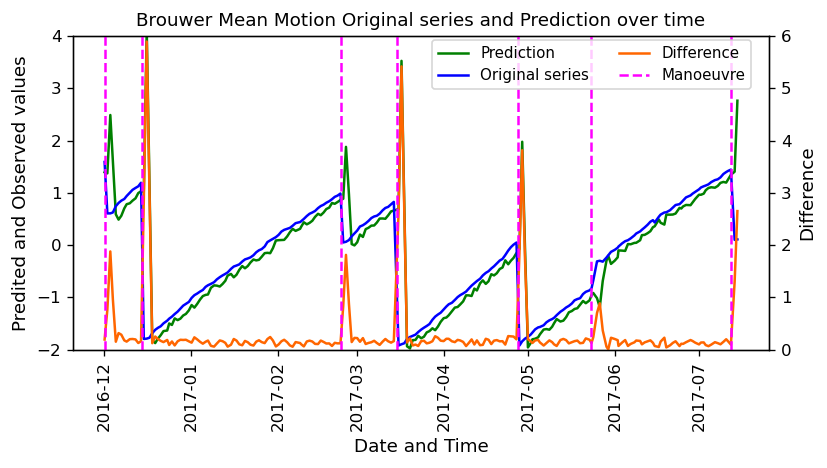

In [179]:
pd_df_Sen3A_bmm_Arima_pred['TimeStamp'] = pd.to_datetime(pd_df_Sen3A_bmm_Arima_pred['TimeStamp'])
pd_df_Sen3A_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Sen3A_GrdTrth['Start Date'])

# Define the start and end date for the filter
start_date = '2016-12-01'
end_date = '2017-07-15'

# Filter the DataFrame for rows where 'TimeStamp' is within the first few months of 2012
subset = pd_df_Sen3A_bmm_Arima_pred[
    (pd_df_Sen3A_bmm_Arima_pred['TimeStamp'] >= start_date) &
    (pd_df_Sen3A_bmm_Arima_pred['TimeStamp'] <= end_date)]
GrdTrth = pd_df_Sen3A_GrdTrth[
    (pd_df_Sen3A_GrdTrth['Start Date'] >= start_date) &
    (pd_df_Sen3A_GrdTrth['Start Date'] <= end_date)]

# plot forecasts against actual outcomes
x=subset['TimeStamp']
y1=subset['Prediction']
y2=subset['Observed']
y3=subset['Difference']

fig, ax = plt.subplots(figsize = (7, 4))
plt.title('Brouwer Mean Motion Original series and Prediction over time', fontsize = 11)

ax.tick_params(axis='x', labelrotation=90, labelsize=10)
ax.tick_params(axis='y', labelsize=10)

ax2 = ax.twinx()
ax2.tick_params(axis='y', labelsize=10)
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))

xcoords = GrdTrth['Start Date']
for xc in xcoords:
    plt.axvline(x=xc,color='magenta',label="Manoeuvre",linestyle='dashed')
 
ax.set_xlabel('Date and Time', fontsize = 11)
ax.set_ylabel('Predited and Observed values', fontsize = 11)
ax2.set_ylabel('Difference', fontsize = 11)

ax.set_ylim(-2, 4)
ax2.set_ylim(0, 6)

plt.tight_layout()
fig.legend(['Prediction','Original series','Difference','Manoeuvre'], loc='upper right', 
           bbox_to_anchor=(0.91, 0.92), fontsize = 9, ncol=2)

# show plot
plt.show()

## 4.4 Find optimal p,d,q for Brouwer Mean Motion

In [57]:
# Define the values for p, d, and q
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]

# Generate all combinations of p, d, q
combinations = list(product(p_values, d_values, q_values))

# Create a DataFrame from the combinations
pd_df_combos = pd.DataFrame(combinations, columns=['p', 'd', 'q'])


In [103]:
pd_df_Sen3A_best_metrics = pd.DataFrame(columns=['Model (p,d,q)', 'RMSE', 'AIC','BIC'])

for index,row in pd_df_combos.iterrows():
    p = row['p']
    d = row['d']
    q = row['q']
    print(p,d,q)
        
    (output,RMSE, AIC, BIC)=Fit_Predict_Arima(pd_df_Sen3A_bmm,'Brouwer Mean Motion',p,d,q)
    
    pd_df_Sen3A_best_metrics = pd_df_Sen3A_best_metrics.append({'Model (p,d,q)': 'Model - ('+ str(p) +',' + str(d) +','+ str(q)+ ')',
                'RMSE': RMSE, 'AIC': AIC, 'BIC': BIC}, ignore_index=True)
#     print(pd_df_Sen3A_best_metrics)

print(pd_df_Sen3A_best_metrics)
        
    

In [104]:
#  Choose Best

best_Sen3A_rmse_model = pd_df_Sen3A_best_metrics.loc[pd_df_Sen3A_best_metrics['RMSE']==pd_df_Sen3A_best_metrics['RMSE'].min(),'Model (p,d,q)']
best_Sen3A_aic_model = pd_df_Sen3A_best_metrics.loc[pd_df_Sen3A_best_metrics['AIC']==pd_df_Sen3A_best_metrics['AIC'].min(),'Model (p,d,q)']
best_Sen3A_bic_model = pd_df_Sen3A_best_metrics.loc[pd_df_Sen3A_best_metrics['BIC']==pd_df_Sen3A_best_metrics['BIC'].min(),'Model (p,d,q)']

print('Best model by RMSE: '+best_Sen3A_rmse_model)
print('Best model by AIC: '+best_Sen3A_aic_model)
print('Best model by BIC: '+best_Sen3A_bic_model)


## 4.5 Propagate elements for best p,d,q

In [28]:
(pd_df_Sen3A_bmm_Arima_pred,dec_Sen3A_bmm_Arima_pred_RMSE, dec_Sen3A_bmm_Arima_pred_AIC, dec_Sen3A_bmm_Arima_pred_BIC
)=Fit_Predict_Arima(pd_df_Sen3A_bmm,'Brouwer Mean Motion',2,0,0)



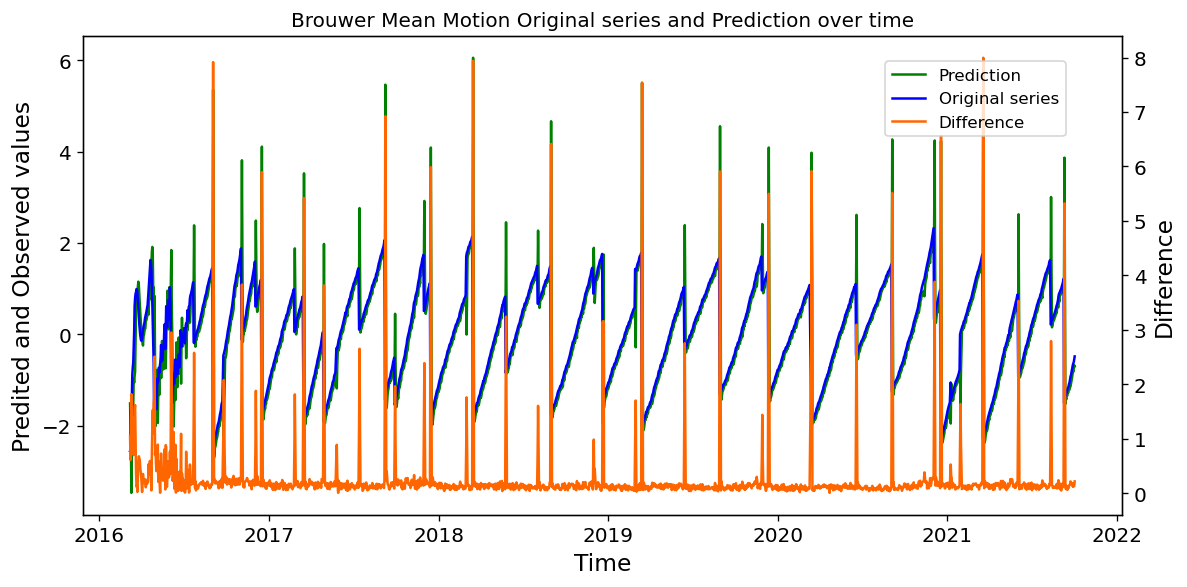

In [105]:
# evaluate forecasts
# pd_df_Sen3A_bmm_Arima_pred['Difference']=abs(pd_df_Sen3A_bmm_Arima_pred['Prediction']-pd_df_Sen3A_bmm_Arima_pred['Observed'])
# print('RMSE: %.3f' % dec_Sen3A_bmm_Arima_pred_RMSE)
# print('AIC: %.3f' % dec_Sen3A_bmm_Arima_pred_AIC)
# print('BIC: %.3f' % dec_Sen3A_bmm_Arima_pred_BIC)

# pd_df_Sen3A_GrdTrth=data[['Satellite','Start Date','End Date']]

# plot forecasts against actual outcomes
x=pd_df_Sen3A_bmm_Arima_pred['TimeStamp']
y1=pd_df_Sen3A_bmm_Arima_pred['Prediction']
y2=pd_df_Sen3A_bmm_Arima_pred['Observed']
y3=pd_df_Sen3A_bmm_Arima_pred['Difference']

fig, ax = plt.subplots(figsize = (10, 5))
plt.title('Brouwer Mean Motion Original series and Prediction over time')
 
ax2 = ax.twinx()
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))
 
ax.set_xlabel('Time')
ax.set_ylabel('Predited and Observed values')
ax2.set_ylabel('Difference')
 
plt.tight_layout()
fig.legend(['Prediction','Original series','Difference'], loc='upper right', bbox_to_anchor=(0.9, 0.9))
 
# show plot
plt.show()


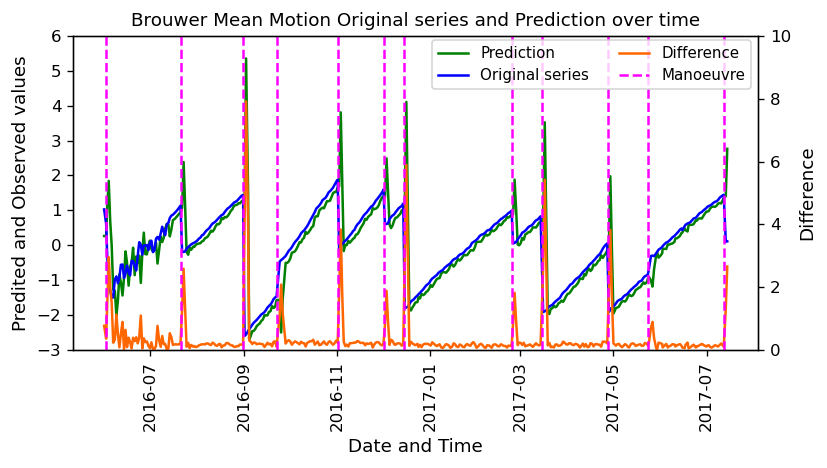

In [182]:
pd_df_Sen3A_bmm_Arima_pred['TimeStamp'] = pd.to_datetime(pd_df_Sen3A_bmm_Arima_pred['TimeStamp'])
pd_df_Sen3A_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Sen3A_GrdTrth['Start Date'])

# Define the start and end date for the filter
start_date = '2016-06-01'
end_date = '2017-07-15'

# Filter the DataFrame for rows where 'TimeStamp' is within the first few months of 2012
subset = pd_df_Sen3A_bmm_Arima_pred[
    (pd_df_Sen3A_bmm_Arima_pred['TimeStamp'] >= start_date) &
    (pd_df_Sen3A_bmm_Arima_pred['TimeStamp'] <= end_date)]
GrdTrth = pd_df_Sen3A_GrdTrth[
    (pd_df_Sen3A_GrdTrth['Start Date'] >= start_date) &
    (pd_df_Sen3A_GrdTrth['Start Date'] <= end_date)]

# plot forecasts against actual outcomes
x=subset['TimeStamp']
y1=subset['Prediction']
y2=subset['Observed']
y3=subset['Difference']

fig, ax = plt.subplots(figsize = (7, 4))
plt.title('Brouwer Mean Motion Original series and Prediction over time', fontsize = 11)

ax.tick_params(axis='x', labelrotation=90, labelsize=10)
ax.tick_params(axis='y', labelsize=10)

ax2 = ax.twinx()
ax2.tick_params(axis='y', labelsize=10)
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))

xcoords = GrdTrth['Start Date']
for xc in xcoords:
    plt.axvline(x=xc,color='magenta',label="Manoeuvre",linestyle='dashed')
 
ax.set_xlabel('Date and Time', fontsize = 11)
ax.set_ylabel('Predited and Observed values', fontsize = 11)
ax2.set_ylabel('Difference', fontsize = 11)

ax.set_ylim(-3, 6)
ax2.set_ylim(0, 10)

plt.tight_layout()
fig.legend(['Prediction','Original series','Difference','Manoeuvre'], loc='upper right', 
           bbox_to_anchor=(0.91, 0.92), fontsize = 9, ncol=2)
# show plot
plt.show()

## 4.6 Highlight Anomalies for best p,d,q

In [107]:
# Determine Threshold value

s=pd_df_Sen3A_bmm_Arima_pred['Difference']

# Define the threshold values
pd_lst_quan = [0.05, 0.5, 0.75, 0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

# Calculate the quantile threshold values
pd_lst_thres = s.quantile(pd_lst_quan)

# Calculate the count of data points above each threshold value
pd_lst_counts = [(s > threshold).sum() for threshold in pd_lst_thres]

# Create a DataFrame with the quantiles, threshold values, and counts
pd_df_thresh = pd.DataFrame({
    'Quantile': pd_lst_quan,
    'Threshold Value': pd_lst_thres.values,
    'Count': pd_lst_counts})
print(pd_df_thresh)



    Quantile  Threshold Value  Count
0       0.05         0.060095   1922
1       0.50         0.137804   1012
2       0.75         0.181516    506
3       0.80         0.198262    405
4       0.85         0.224051    304
5       0.90         0.305634    203
6       0.91         0.388928    183
7       0.92         0.526452    162
8       0.93         0.702725    142
9       0.94         0.891311    122
10      0.95         1.199128    102
11      0.96         1.583011     81
12      0.97         2.020321     61
13      0.98         2.972812     41
14      0.99         3.875828     21


In [108]:
# choose threshold
threshold = pd_df_thresh.loc[pd_df_thresh['Quantile'] == 0.94, 'Threshold Value'].values[0]
print(threshold)

pd_df_Sen3A_bmm_Arima_anom = detect_anomalies(pd_df_Sen3A_bmm_Arima_pred, threshold)

# pd_df_Sen3A_bmm_Arima_anom.iloc[220:270]

0.8913105995035685


In [109]:
# Add Manoeuvre column to show the ground truth manoevres (with a 3 day gray area)
pd_df_Sen3A_bmm_Arima_anom['Manoeuvre'] = 'No'

# Iterate over the Sen3A_GrdTrth DataFrame and update pd_df_Sen3A_bmm_Arima_anom['Manoeuvre']
for _, row in pd_df_Sen3A_GrdTrth.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']
    
    # for each row in pd_df_Sen3A_bmm_Arima_anom, calculate a boolean called in_gray_zone and 
    # set it to True if it is within 1 day of the start time or within 3 days of the finish time of a logged Manoeuvre
    in_gray_zone = (
        (pd_df_Sen3A_bmm_Arima_anom['TimeStamp'] >= (start_date + pd.Timedelta(days=2))) & 
        (pd_df_Sen3A_bmm_Arima_anom['TimeStamp'] <= (end_date + pd.Timedelta(days=4)))
    )
    
    # Update the 'Manoeuvre' column to 'Yes' if in_gray_zone is True
    pd_df_Sen3A_bmm_Arima_anom.loc[in_gray_zone, 'Manoeuvre'] = 'Yes'

    
test=pd_df_Sen3A_bmm_Arima_anom[['TimeStamp','Difference', 'Anomaly','Manoeuvre']]

for x in range(0,20):
    subset=test[50*x:50*(x+1)]
    print(subset)


                    TimeStamp  Difference Anomaly Manoeuvre
0  2016-03-07 05:37:27.298272    1.049039     Yes        No
1  2016-03-08 03:30:17.538911    0.612215      No        No
2  2016-03-09 03:04:06.551904    0.762949      No        No
3  2016-03-10 02:37:55.725600    1.818175     Yes       Yes
4  2016-03-11 02:11:44.990879    1.206698     Yes       Yes
5  2016-03-12 01:45:34.054847    1.061334     Yes        No
6  2016-03-13 01:19:23.002175    1.397036     Yes        No
7  2016-03-14 02:34:11.327519    0.909733     Yes        No
8  2016-03-15 02:08:00.378528    0.700661      No        No
9  2016-03-16 01:41:49.038144    1.119357     Yes        No
10 2016-03-17 01:15:37.568159    1.532272     Yes        No
11 2016-03-18 02:30:25.763040    1.620932     Yes        No
12 2016-03-19 02:04:14.645568    1.008167     Yes        No
13 2016-03-20 01:38:03.597216    0.389542      No        No
14 2016-03-21 02:52:51.764448    0.122188      No        No
15 2016-03-22 02:26:40.729055    0.15626

C:\Users\aloci\AppData\Local\Temp\ipykernel_4888\704852029.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['anomaly_bin'] = df['Anomaly'].map({'Yes': 1, 'No': 0})
C:\Users\aloci\AppData\Local\Temp\ipykernel_4888\704852029.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['manoeuvre_bin'] = df['Manoeuvre'].map({'Yes': 1, 'No': 0})


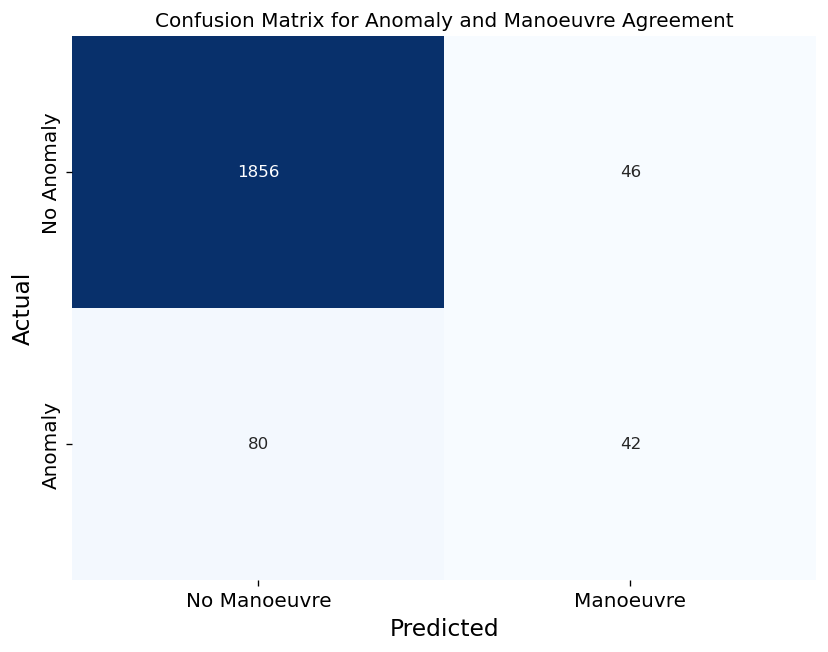

In [110]:
df=pd_df_Sen3A_bmm_Arima_anom[['TimeStamp','Anomaly','Manoeuvre']]

# Convert 'yes'/'no' to binary values
df['anomaly_bin'] = df['Anomaly'].map({'Yes': 1, 'No': 0})
df['manoeuvre_bin'] = df['Manoeuvre'].map({'Yes': 1, 'No': 0})

# Create confusion matrix
cm = confusion_matrix(df['anomaly_bin'], df['manoeuvre_bin'])

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=['No Anomaly', 'Anomaly'], columns=['No Manoeuvre', 'Manoeuvre'])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sb.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Anomaly and Manoeuvre Agreement')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 5. Model Fengyun 2F

## 5.1 Import Data

In [111]:
pd_df_Fen2F_UnProp = pd.read_csv(r"C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\orbital_elements\unpropagated_elements_Fengyun-2F.csv",parse_dates=True)
pd_df_Fen2F_UnProp = pd_df_Fen2F_UnProp.rename(columns={'Unnamed: 0': 'TimeStamp','eccentricity':'Eccentricity'})
pd_df_Fen2F_UnProp = pd_df_Fen2F_UnProp.rename(columns={'inclination': 'Inclination','mean anomaly':'Mean Anomaly'})
pd_df_Fen2F_UnProp = pd_df_Fen2F_UnProp.rename(columns={'argument of perigee': 'Argument of Perigee'})
pd_df_Fen2F_UnProp = pd_df_Fen2F_UnProp.rename(columns={'Brouwer mean motion': 'Brouwer Mean Motion'})
pd_df_Fen2F_UnProp = pd_df_Fen2F_UnProp.rename(columns={'right ascension':'Right Ascension'})
pd_df_Fen2F_UnProp['TimeStamp'] = pd.to_datetime(pd_df_Fen2F_UnProp['TimeStamp'])
pd_df_Fen2F_UnProp


TimeStamp  Eccentricity  Argument of Perigee  \
0    2012-09-06 18:48:32.050655      0.000488             4.483911   
1    2012-09-07 19:39:45.383327      0.000487             4.481215   
2    2012-09-08 15:43:39.075167      0.000487             4.475122   
3    2012-09-09 12:53:36.595967      0.000492             4.481063   
4    2012-09-10 13:15:22.135391      0.000495             4.512943   
...                         ...           ...                  ...   
2980 2021-12-25 04:39:15.108767      0.000330             0.082144   
2981 2021-12-28 21:00:18.080928      0.000355             0.140658   
2982 2022-01-06 13:25:24.541247      0.000527             6.211157   
2983 2022-01-07 18:42:19.086048      0.000533             6.231944   
2984 2022-01-11 17:26:36.259583      0.000503             6.184925   

      Inclination  Mean Anomaly  Brouwer Mean Motion  Right Ascension  
0        0.032940     -2.689729             0.004374         4.842139  
1        0.032901     -2.446726             0.004374         4.842234  
2        0.032868     -3.457326             0.004374         4.842332  
3        0.032835     -4.190783             0.004374         4.842201  
4        0.032798     -4.111348             0.004374         4.842257  
...           ...           ...                  ...              ...  
2980     0.058788     -2.965046             0.004375         1.413225  
2981     0.058901     -4.964060             0.004375         1.412455  
2982     0.059350     -0.307468             0.004376         1.411825  
2983     0.059406     -5.206757             0.004376         1.411793  
2984     0.059559     -5.418839             0.004375         1.411287  

[2985 rows x 7 columns]

In [112]:
pd_df_Fen2F_UnProp.info()
size=len(pd_df_Fen2F_UnProp)
split=round(0.85*size)
pd_df_Fen2F_UnProp_train, pd_df_Fen2F_UnProp_test = pd_df_Fen2F_UnProp[0:split], pd_df_Fen2F_UnProp[split:size]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985 entries, 0 to 2984
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   TimeStamp            2985 non-null   datetime64[ns]
 1   Eccentricity         2985 non-null   float64       
 2   Argument of Perigee  2985 non-null   float64       
 3   Inclination          2985 non-null   float64       
 4   Mean Anomaly         2985 non-null   float64       
 5   Brouwer Mean Motion  2985 non-null   float64       
 6   Right Ascension      2985 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 163.4 KB


In [128]:
# Read the fixed-width formatted text file into a DataFrame
file_path = r"C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\manoeuvres\Fengyun2F-manFY2F.Fy"
data = pd.read_fwf(file_path, header=None)
data = data.rename(columns={0: 'Satellite',2:'Start Date',4:'End Date'})
data=data[['Satellite','Start Date','End Date']]
data['Start Date'] = data['Start Date'].str.strip('"')
data['End Date'] = data['End Date'].str.strip('"')

data['Start Date'] = pd.to_datetime(data['Start Date'], format="%Y-%m-%dT%H:%M:%S")
data['End Date'] = pd.to_datetime(data['End Date'], format="%Y-%m-%dT%H:%M:%S")

pd_df_Fen2F_GrdTrth=data[['Satellite','Start Date','End Date']]

# Display the DataFrame
print(pd_df_Fen2F_GrdTrth.head(10))
int_Fen2F_num_man=pd_df_Fen2F_GrdTrth.shape[0]
print(int_Fen2F_num_man)



                Satellite          Start Date            End Date
0  GEO-EW-STATION-KEEPING 2022-01-05 08:30:00 2022-01-05 09:30:00
1  GEO-EW-STATION-KEEPING 2021-11-15 15:30:00 2021-11-15 16:30:00
2  GEO-EW-STATION-KEEPING 2021-09-23 16:00:00 2021-09-23 17:00:00
3  GEO-EW-STATION-KEEPING 2021-08-04 15:00:00 2021-08-04 16:00:00
4  GEO-EW-STATION-KEEPING 2021-06-15 16:00:00 2021-06-15 17:00:00
5  GEO-EW-STATION-KEEPING 2021-04-21 16:30:00 2021-04-21 17:30:00
6  GEO-EW-STATION-KEEPING 2021-03-08 16:30:00 2021-03-08 17:30:00
7  GEO-EW-STATION-KEEPING 2021-01-13 15:30:00 2021-01-13 16:30:00
8  GEO-EW-STATION-KEEPING 2020-11-16 15:00:00 2020-11-16 16:00:00
9  GEO-EW-STATION-KEEPING 2021-09-22 16:00:00 2021-09-22 17:00:00
68


## 5.2 Prepare individual dataframes per element

C:\Users\aloci\AppData\Local\Temp\ipykernel_4888\417718410.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df_Fen2F_bmm['Brouwer Mean Motion'] = (pd_df_Fen2F_bmm['Brouwer Mean Motion'] - pd_df_Fen2F_bmm['Brouwer Mean Motion'].mean()) * 10000000


                   TimeStamp  Brouwer Mean Motion
0 2012-09-06 18:48:32.050655            -5.958336
1 2012-09-07 19:39:45.383327            -6.193505
2 2012-09-08 15:43:39.075167            -6.388097
3 2012-09-09 12:53:36.595967            -6.598397
4 2012-09-10 13:15:22.135391            -6.830947


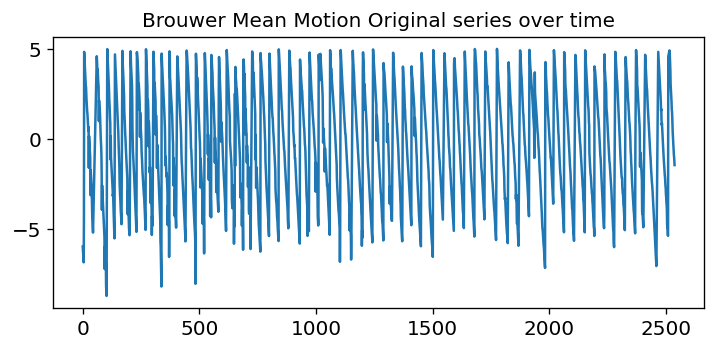

In [129]:
# Scale ['Brouwer mean motion'] to larger numbers
pd_df_Fen2F_bmm=pd_df_Fen2F_UnProp_train[['TimeStamp', 'Brouwer Mean Motion']]

pd_df_Fen2F_bmm['Brouwer Mean Motion'] = (pd_df_Fen2F_bmm['Brouwer Mean Motion'] - pd_df_Fen2F_bmm['Brouwer Mean Motion'].mean()) * 10000000
print(pd_df_Fen2F_bmm.head())

pd_df_Fen2F_bmm = pd_df_Fen2F_bmm[pd_df_Fen2F_bmm['Brouwer Mean Motion'] <= 5]
pd_df_Fen2F_bmm = pd_df_Fen2F_bmm[pd_df_Fen2F_bmm['Brouwer Mean Motion'] >= -10]

plt.rcParams.update({'figure.figsize':(7,3), 'figure.dpi':120})
plt.plot(pd_df_Fen2F_bmm['Brouwer Mean Motion'])
plt.title('Brouwer Mean Motion Original series over time')
plt.show()

In [130]:
mind=pd_df_Fen2F_bmm.loc[pd_df_Fen2F_bmm['TimeStamp']==pd_df_Fen2F_bmm['TimeStamp'].min(),'TimeStamp']
maxd=pd_df_Fen2F_bmm.loc[pd_df_Fen2F_bmm['TimeStamp']==pd_df_Fen2F_bmm['TimeStamp'].max(),'TimeStamp']
print(mind,maxd)

0   2012-09-06 18:48:32.050655
Name: TimeStamp, dtype: datetime64[ns] 2536   2020-09-01 03:53:41.012735
Name: TimeStamp, dtype: datetime64[ns]


## 5.3 Propagate elements

In [49]:
(pd_df_Fen2F_bmm_Arima_pred,dec_Fen2F_bmm_Arima_pred_RMSE, dec_Fen2F_bmm_Arima_pred_AIC, dec_Fen2F_bmm_Arima_pred_BIC
)=Fit_Predict_Arima(pd_df_Fen2F_bmm,'Brouwer Mean Motion',1,1,1)


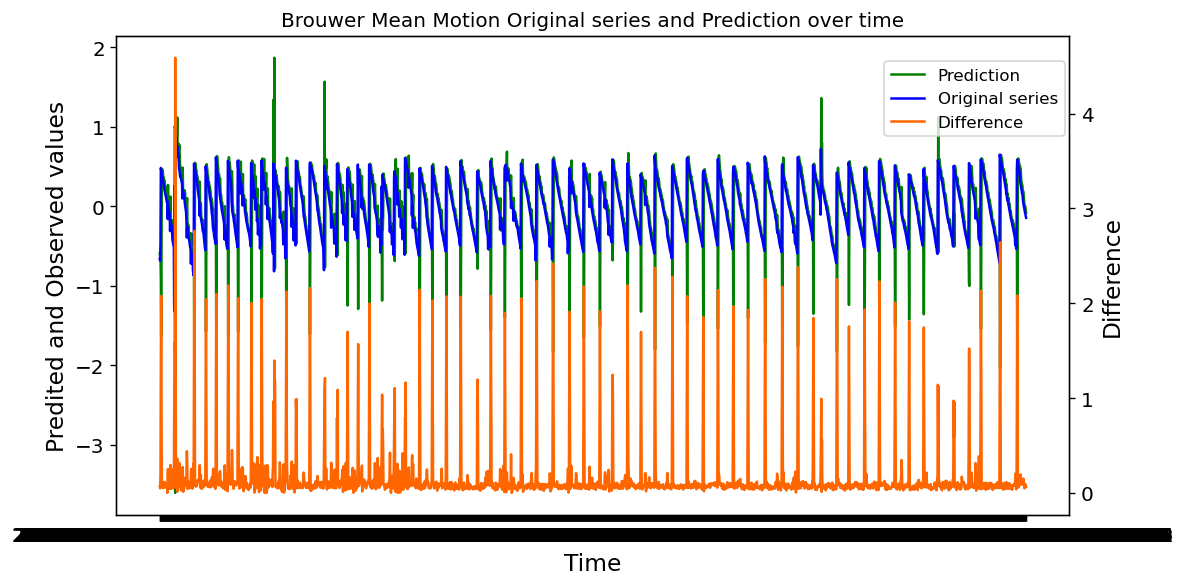

In [131]:
# evaluate forecasts
pd_df_Fen2F_bmm_Arima_pred['Difference']=abs(pd_df_Fen2F_bmm_Arima_pred['Prediction']-pd_df_Fen2F_bmm_Arima_pred['Observed'])
# print('RMSE: %.3f' % dec_Fen2F_bmm_Arima_pred_RMSE)
# print('AIC: %.3f' % dec_Fen2F_bmm_Arima_pred_AIC)
# print('BIC: %.3f' % dec_Fen2F_bmm_Arima_pred_BIC)

# pd_df_Fen2F_GrdTrth=data[['Satellite','Start Date','End Date']]

# plot forecasts against actual outcomes
x=pd_df_Fen2F_bmm_Arima_pred['TimeStamp']
y1=pd_df_Fen2F_bmm_Arima_pred['Prediction']
y2=pd_df_Fen2F_bmm_Arima_pred['Observed']
y3=pd_df_Fen2F_bmm_Arima_pred['Difference']

fig, ax = plt.subplots(figsize = (10, 5))
plt.title('Brouwer Mean Motion Original series and Prediction over time')
 
ax2 = ax.twinx()
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))
 
ax.set_xlabel('Time')
ax.set_ylabel('Predited and Observed values')
ax2.set_ylabel('Difference')
 
plt.tight_layout()
fig.legend(['Prediction','Original series','Difference'], loc='upper right', bbox_to_anchor=(0.9, 0.9))
 
# show plot
plt.show()


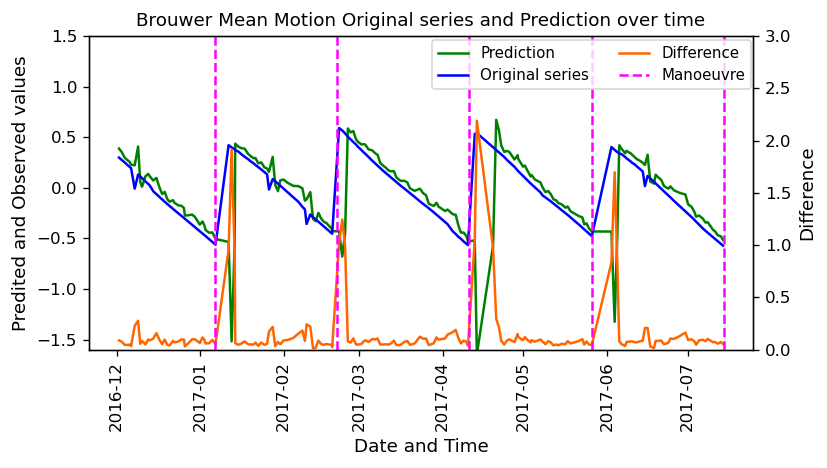

In [185]:
pd_df_Fen2F_bmm_Arima_pred['TimeStamp'] = pd.to_datetime(pd_df_Fen2F_bmm_Arima_pred['TimeStamp'])
pd_df_Fen2F_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Fen2F_GrdTrth['Start Date'])

# Define the start and end date for the filter
start_date = '2016-12-01'
end_date = '2017-07-15'

# Filter the DataFrame for rows where 'TimeStamp' is within the first few months of 2012
subset = pd_df_Fen2F_bmm_Arima_pred[
    (pd_df_Fen2F_bmm_Arima_pred['TimeStamp'] >= start_date) &
    (pd_df_Fen2F_bmm_Arima_pred['TimeStamp'] <= end_date)]
GrdTrth = pd_df_Fen2F_GrdTrth[
    (pd_df_Fen2F_GrdTrth['Start Date'] >= start_date) &
    (pd_df_Fen2F_GrdTrth['Start Date'] <= end_date)]

# plot forecasts against actual outcomes
x=subset['TimeStamp']
y1=subset['Prediction']
y2=subset['Observed']
y3=subset['Difference']

fig, ax = plt.subplots(figsize = (7, 4))
plt.title('Brouwer Mean Motion Original series and Prediction over time', fontsize = 11)

ax.tick_params(axis='x', labelrotation=90, labelsize=10)
ax.tick_params(axis='y', labelsize=10)

ax2 = ax.twinx()
ax2.tick_params(axis='y', labelsize=10)
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))

xcoords = GrdTrth['Start Date']
for xc in xcoords:
    plt.axvline(x=xc,color='magenta',label="Manoeuvre",linestyle='dashed')
 
ax.set_xlabel('Date and Time', fontsize = 11)
ax.set_ylabel('Predited and Observed values', fontsize = 11)
ax2.set_ylabel('Difference', fontsize = 11)

ax.set_ylim(-1.6, 1.5)
ax2.set_ylim(0, 3)

plt.tight_layout()
fig.legend(['Prediction','Original series','Difference','Manoeuvre'], loc='upper right', 
           bbox_to_anchor=(0.91, 0.92), fontsize = 9, ncol=2)
# show plot
plt.show()

## 5.4 Find optimal p,d,q for Brouwer Mean Motion

In [57]:
# Define the values for p, d, and q
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]

# Generate all combinations of p, d, q
combinations = list(product(p_values, d_values, q_values))

# Create a DataFrame from the combinations
pd_df_combos = pd.DataFrame(combinations, columns=['p', 'd', 'q'])


In [103]:
pd_df_Fen2F_best_metrics = pd.DataFrame(columns=['Model (p,d,q)', 'RMSE', 'AIC','BIC'])

for index,row in pd_df_combos.iterrows():
    p = row['p']
    d = row['d']
    q = row['q']
    print(p,d,q)
        
    (output,RMSE, AIC, BIC)=Fit_Predict_Arima(pd_df_Fen2F_bmm,'Brouwer Mean Motion',p,d,q)
    
    pd_df_Fen2F_best_metrics = pd_df_Fen2F_best_metrics.append({'Model (p,d,q)': 'Model - ('+ str(p) +',' + str(d) +','+ str(q)+ ')',
                'RMSE': RMSE, 'AIC': AIC, 'BIC': BIC}, ignore_index=True)
#     print(pd_df_Fen2F_best_metrics)

print(pd_df_Fen2F_best_metrics)
        
    

In [104]:
#  Choose Best

best_Fen2F_rmse_model = pd_df_Fen2F_best_metrics.loc[pd_df_Fen2F_best_metrics['RMSE']==pd_df_Fen2F_best_metrics['RMSE'].min(),'Model (p,d,q)']
best_Fen2F_aic_model = pd_df_Fen2F_best_metrics.loc[pd_df_Fen2F_best_metrics['AIC']==pd_df_Fen2F_best_metrics['AIC'].min(),'Model (p,d,q)']
best_Fen2F_bic_model = pd_df_Fen2F_best_metrics.loc[pd_df_Fen2F_best_metrics['BIC']==pd_df_Fen2F_best_metrics['BIC'].min(),'Model (p,d,q)']

print('Best model by RMSE: '+best_Fen2F_rmse_model)
print('Best model by AIC: '+best_Fen2F_aic_model)
print('Best model by BIC: '+best_Fen2F_bic_model)


## 5.5 Propagate elements for best p,d,q

In [28]:
(pd_df_Fen2F_bmm_Arima_pred,dec_Fen2F_bmm_Arima_pred_RMSE, dec_Fen2F_bmm_Arima_pred_AIC, dec_Fen2F_bmm_Arima_pred_BIC
)=Fit_Predict_Arima(pd_df_Fen2F_bmm,'Brouwer Mean Motion',2,0,0)



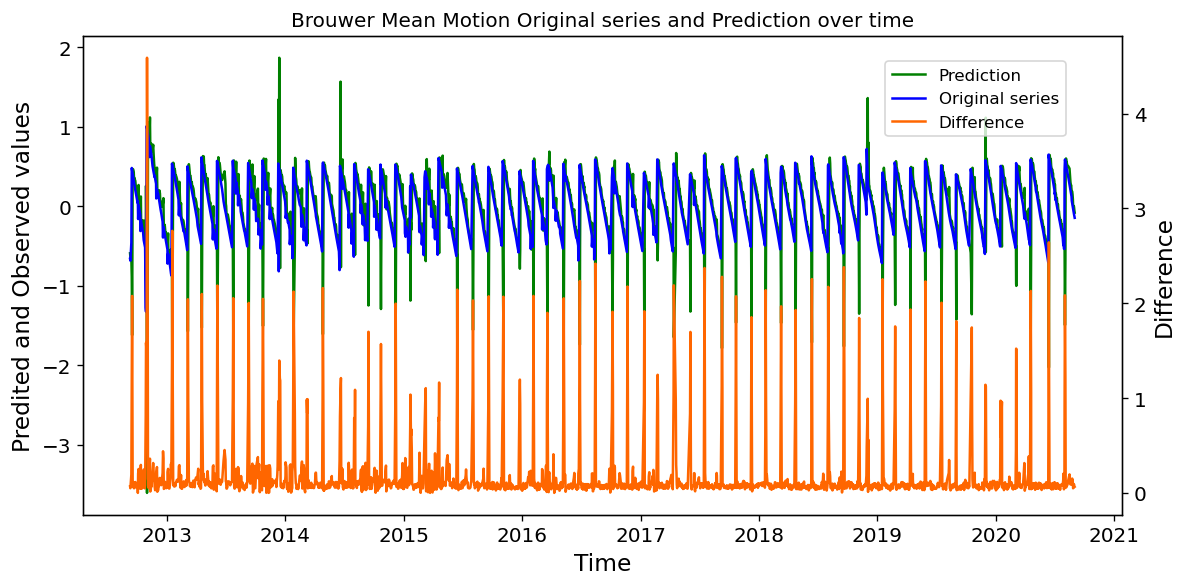

In [134]:
# evaluate forecasts
# pd_df_Fen2F_bmm_Arima_pred['Difference']=abs(pd_df_Fen2F_bmm_Arima_pred['Prediction']-pd_df_Fen2F_bmm_Arima_pred['Observed'])
# print('RMSE: %.3f' % dec_Fen2F_bmm_Arima_pred_RMSE)
# print('AIC: %.3f' % dec_Fen2F_bmm_Arima_pred_AIC)
# print('BIC: %.3f' % dec_Fen2F_bmm_Arima_pred_BIC)

# pd_df_Fen2F_GrdTrth=data[['Satellite','Start Date','End Date']]

# plot forecasts against actual outcomes
x=pd_df_Fen2F_bmm_Arima_pred['TimeStamp']
y1=pd_df_Fen2F_bmm_Arima_pred['Prediction']
y2=pd_df_Fen2F_bmm_Arima_pred['Observed']
y3=pd_df_Fen2F_bmm_Arima_pred['Difference']

fig, ax = plt.subplots(figsize = (10, 5))
plt.title('Brouwer Mean Motion Original series and Prediction over time')
 
ax2 = ax.twinx()
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))
 
ax.set_xlabel('Time')
ax.set_ylabel('Predited and Observed values')
ax2.set_ylabel('Difference')
 
plt.tight_layout()
fig.legend(['Prediction','Original series','Difference'], loc='upper right', bbox_to_anchor=(0.9, 0.9))
 
# show plot
plt.show()


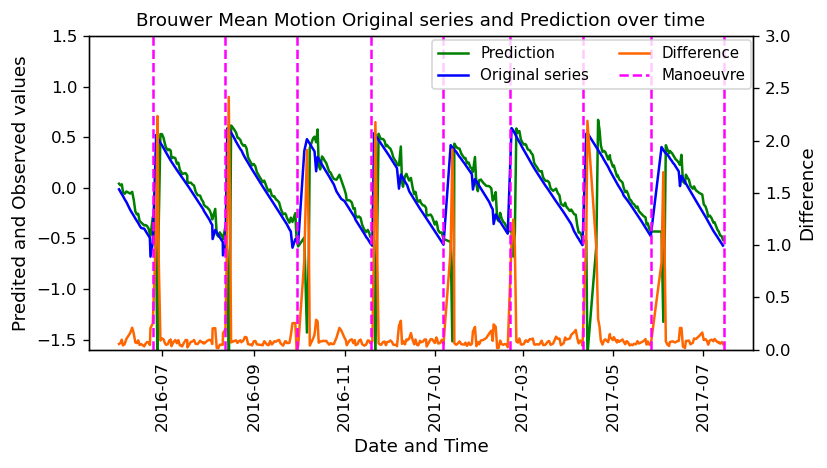

In [186]:
pd_df_Fen2F_bmm_Arima_pred['TimeStamp'] = pd.to_datetime(pd_df_Fen2F_bmm_Arima_pred['TimeStamp'])
pd_df_Fen2F_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Fen2F_GrdTrth['Start Date'])

# Define the start and end date for the filter
start_date = '2016-06-01'
end_date = '2017-07-15'

# Filter the DataFrame for rows where 'TimeStamp' is within the first few months of 2012
subset = pd_df_Fen2F_bmm_Arima_pred[
    (pd_df_Fen2F_bmm_Arima_pred['TimeStamp'] >= start_date) &
    (pd_df_Fen2F_bmm_Arima_pred['TimeStamp'] <= end_date)]
GrdTrth = pd_df_Fen2F_GrdTrth[
    (pd_df_Fen2F_GrdTrth['Start Date'] >= start_date) &
    (pd_df_Fen2F_GrdTrth['Start Date'] <= end_date)]

# plot forecasts against actual outcomes
x=subset['TimeStamp']
y1=subset['Prediction']
y2=subset['Observed']
y3=subset['Difference']

fig, ax = plt.subplots(figsize = (7, 4))
plt.title('Brouwer Mean Motion Original series and Prediction over time', fontsize = 11)

ax.tick_params(axis='x', labelrotation=90, labelsize=10)
ax.tick_params(axis='y', labelsize=10)

ax2 = ax.twinx()
ax2.tick_params(axis='y', labelsize=10)
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))

xcoords = GrdTrth['Start Date']
for xc in xcoords:
    plt.axvline(x=xc,color='magenta',label="Manoeuvre",linestyle='dashed')
 
ax.set_xlabel('Date and Time', fontsize = 11)
ax.set_ylabel('Predited and Observed values', fontsize = 11)
ax2.set_ylabel('Difference', fontsize = 11)

ax.set_ylim(-1.6, 1.5)
ax2.set_ylim(0, 3)

plt.tight_layout()
fig.legend(['Prediction','Original series','Difference','Manoeuvre'], loc='upper right', 
           bbox_to_anchor=(0.91, 0.92), fontsize = 9, ncol=2)
 
# show plot
plt.show()

## 5.6 Highlight Anomalies for best p,d,q

In [136]:
# Determine Threshold value

s=pd_df_Fen2F_bmm_Arima_pred['Difference']

# Define the threshold values
pd_lst_quan = [0.05, 0.5, 0.75, 0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

# Calculate the quantile threshold values
pd_lst_thres = s.quantile(pd_lst_quan)

# Calculate the count of data points above each threshold value
pd_lst_counts = [(s > threshold).sum() for threshold in pd_lst_thres]

# Create a DataFrame with the quantiles, threshold values, and counts
pd_df_thresh = pd.DataFrame({
    'Quantile': pd_lst_quan,
    'Threshold Value': pd_lst_thres.values,
    'Count': pd_lst_counts})
print(pd_df_thresh)



    Quantile  Threshold Value  Count
0       0.05         0.036786   2407
1       0.50         0.080917   1267
2       0.75         0.112469    634
3       0.80         0.128347    507
4       0.85         0.177044    380
5       0.90         0.268457    254
6       0.91         0.291564    228
7       0.92         0.353436    203
8       0.93         0.751748    178
9       0.94         0.920519    152
10      0.95         0.975149    127
11      0.96         1.030051    102
12      0.97         1.126010     76
13      0.98         1.538382     51
14      0.99         2.073844     26


In [137]:
# choose threshold
threshold = pd_df_thresh.loc[pd_df_thresh['Quantile'] == 0.94, 'Threshold Value'].values[0]
print(threshold)

pd_df_Fen2F_bmm_Arima_anom = detect_anomalies(pd_df_Fen2F_bmm_Arima_pred, threshold)

# pd_df_Fen2F_bmm_Arima_anom.iloc[220:270]

0.9205191689491438


In [139]:
# Add Manoeuvre column to show the ground truth manoevres (with a 3 day gray area)
pd_df_Fen2F_bmm_Arima_anom['Manoeuvre'] = 'No'

# Iterate over the Fen2F_GrdTrth DataFrame and update pd_df_Fen2F_bmm_Arima_anom['Manoeuvre']
for _, row in pd_df_Fen2F_GrdTrth.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']
    
    # for each row in pd_df_Fen2F_bmm_Arima_anom, calculate a boolean called in_gray_zone and 
    # set it to True if it is within 1 day of the start time or within 3 days of the finish time of a logged Manoeuvre
    in_gray_zone = (
        (pd_df_Fen2F_bmm_Arima_anom['TimeStamp'] >= (start_date + pd.Timedelta(days=2))) & 
        (pd_df_Fen2F_bmm_Arima_anom['TimeStamp'] <= (end_date + pd.Timedelta(days=4)))
    )
    
    # Update the 'Manoeuvre' column to 'Yes' if in_gray_zone is True
    pd_df_Fen2F_bmm_Arima_anom.loc[in_gray_zone, 'Manoeuvre'] = 'Yes'

    
test=pd_df_Fen2F_bmm_Arima_anom[['TimeStamp','Difference', 'Anomaly','Manoeuvre']]

for x in range(0,20):
    subset=test[50*x:50*(x+1)]
    print(subset)


                    TimeStamp  Difference Anomaly Manoeuvre
0  2012-09-09 12:53:36.595967    0.069751      No        No
1  2012-09-10 13:15:22.135391    0.049631      No        No
2  2012-09-13 11:30:17.116991    0.193908      No        No
3  2012-09-14 18:44:59.879040    1.367174     Yes       Yes
4  2012-09-15 20:34:10.570655    2.077213     Yes        No
5  2012-09-16 20:52:25.060800    0.855482      No        No
6  2012-09-17 14:02:09.292127    0.062963      No        No
7  2012-09-18 18:40:24.543839    0.094413      No        No
8  2012-09-19 19:05:11.099040    0.110096      No        No
9  2012-09-20 22:10:02.064864    0.113838      No        No
10 2012-09-21 18:36:08.288351    0.048906      No        No
11 2012-09-22 00:10:25.963680    0.073978      No        No
12 2012-09-23 14:16:58.677312    0.068834      No        No
13 2012-09-24 20:20:43.337184    0.110715      No        No
14 2012-09-25 20:43:03.872927    0.115279      No        No
15 2012-09-26 18:34:27.101856    0.09312

899 2015-11-23 23:02:23.093664    0.121656      No        No
                     TimeStamp  Difference Anomaly Manoeuvre
900 2015-11-24 17:39:27.273312    0.188443      No        No
901 2015-11-25 10:36:44.854847    0.121678      No        No
902 2015-11-26 21:09:15.877727    0.051589      No        No
903 2015-11-27 18:04:02.536032    0.102095      No        No
904 2015-11-28 14:17:14.034048    0.061160      No        No
905 2015-11-29 18:48:21.021695    0.036413      No        No
906 2015-11-30 22:06:39.219264    0.063406      No        No
907 2015-12-01 10:28:41.083967    0.091349      No        No
908 2015-12-02 13:48:39.552191    0.068658      No        No
909 2015-12-03 17:26:37.957343    0.078281      No        No
910 2015-12-04 20:13:15.894047    0.054119      No        No
911 2015-12-05 20:43:00.167232    0.053391      No        No
912 2015-12-06 22:12:30.900960    0.051603      No        No
913 2015-12-07 21:00:05.033663    0.049045      No        No
914 2015-12-08 22:51:57.

C:\Users\aloci\AppData\Local\Temp\ipykernel_4888\3486201541.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['anomaly_bin'] = df['Anomaly'].map({'Yes': 1, 'No': 0})
C:\Users\aloci\AppData\Local\Temp\ipykernel_4888\3486201541.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['manoeuvre_bin'] = df['Manoeuvre'].map({'Yes': 1, 'No': 0})


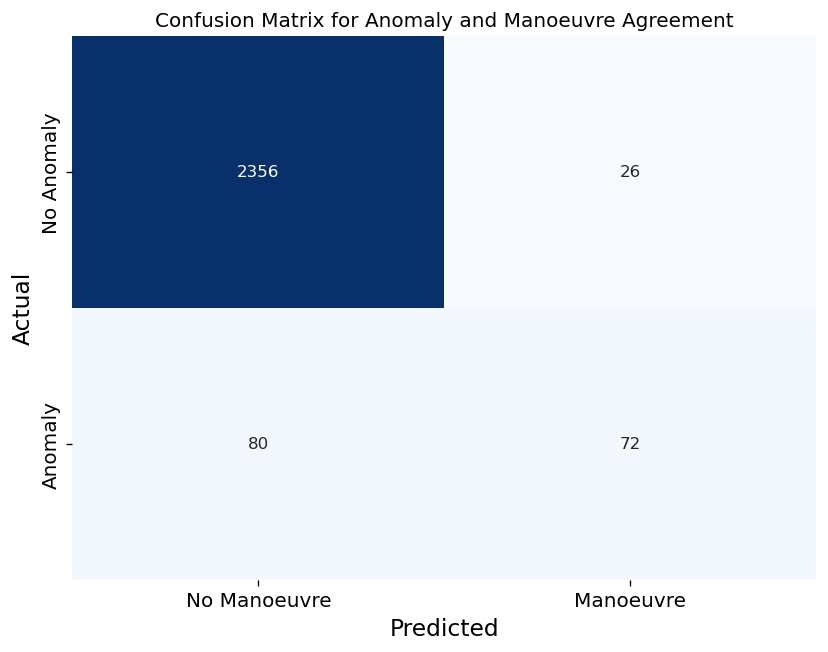

In [140]:
df=pd_df_Fen2F_bmm_Arima_anom[['TimeStamp','Anomaly','Manoeuvre']]

# Convert 'yes'/'no' to binary values
df['anomaly_bin'] = df['Anomaly'].map({'Yes': 1, 'No': 0})
df['manoeuvre_bin'] = df['Manoeuvre'].map({'Yes': 1, 'No': 0})

# Create confusion matrix
cm = confusion_matrix(df['anomaly_bin'], df['manoeuvre_bin'])

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=['No Anomaly', 'Anomaly'], columns=['No Manoeuvre', 'Manoeuvre'])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sb.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Anomaly and Manoeuvre Agreement')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 6. Model Haiyang 2A

## 6.1 Import Data

In [142]:
pd_df_Hai2A_UnProp = pd.read_csv(r"C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\orbital_elements\unpropagated_elements_Haiyang-2A.csv",parse_dates=True)
pd_df_Hai2A_UnProp = pd_df_Hai2A_UnProp.rename(columns={'Unnamed: 0': 'TimeStamp','eccentricity':'Eccentricity'})
pd_df_Hai2A_UnProp = pd_df_Hai2A_UnProp.rename(columns={'inclination': 'Inclination','mean anomaly':'Mean Anomaly'})
pd_df_Hai2A_UnProp = pd_df_Hai2A_UnProp.rename(columns={'argument of perigee': 'Argument of Perigee'})
pd_df_Hai2A_UnProp = pd_df_Hai2A_UnProp.rename(columns={'Brouwer mean motion': 'Brouwer Mean Motion'})
pd_df_Hai2A_UnProp = pd_df_Hai2A_UnProp.rename(columns={'right ascension':'Right Ascension'})
pd_df_Hai2A_UnProp['TimeStamp'] = pd.to_datetime(pd_df_Hai2A_UnProp['TimeStamp'])
pd_df_Hai2A_UnProp


TimeStamp  Eccentricity  Argument of Perigee  \
0    2011-10-08 03:08:31.065504      0.000158             1.456236   
1    2011-10-09 01:46:27.454367      0.000158             1.412851   
2    2011-10-10 03:53:18.699936      0.000149             1.414537   
3    2011-10-11 02:31:15.109536      0.000147             1.360987   
4    2011-10-12 02:53:38.975135      0.000150             1.457867   
...                         ...           ...                  ...   
2993 2020-05-29 03:50:24.635040      0.000154             1.196893   
2994 2020-05-30 00:44:24.709920      0.000153             1.177362   
2995 2020-05-31 09:49:54.818399      0.000151             1.151221   
2996 2020-06-01 08:28:24.885120      0.000149             1.144032   
2997 2020-06-02 01:53:24.932255      0.000147             1.128907   

      Inclination  Mean Anomaly  Brouwer Mean Motion  Right Ascension  
0        1.734299     -1.453913             0.060217         5.018305  
1        1.734299     -1.410530             0.060217         5.034573  
2        1.734285     -1.412231             0.060217         5.053360  
3        1.734292     -1.358690             0.060217         5.069649  
4        1.734280     -1.455514             0.060217         5.087160  
...           ...           ...                  ...              ...  
2993     1.733400     -1.194596             0.060192         2.759940  
2994     1.733398     -1.175069             0.060192         2.774875  
2995     1.733398     -1.148935             0.060192         2.798520  
2996     1.733396     -1.141751             0.060192         2.814698  
2997     1.733396     -1.126631             0.060192         2.827144  

[2998 rows x 7 columns]

In [143]:
pd_df_Hai2A_UnProp.info()
size=len(pd_df_Hai2A_UnProp)
split=round(0.85*size)
pd_df_Hai2A_UnProp_train, pd_df_Hai2A_UnProp_test = pd_df_Hai2A_UnProp[0:split], pd_df_Hai2A_UnProp[split:size]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2998 entries, 0 to 2997
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   TimeStamp            2998 non-null   datetime64[ns]
 1   Eccentricity         2998 non-null   float64       
 2   Argument of Perigee  2998 non-null   float64       
 3   Inclination          2998 non-null   float64       
 4   Mean Anomaly         2998 non-null   float64       
 5   Brouwer Mean Motion  2998 non-null   float64       
 6   Right Ascension      2998 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 164.1 KB


In [144]:
# Read the fixed-width formatted text file into a DataFrame
file_path = r"C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\manoeuvres\Haiyang2A-h2aman.txt"
data = pd.read_fwf(file_path, header=None)
data = data.rename(columns={0: 'Satellite'})
data['Start Date'] = pd.to_datetime(data[1].astype(str) + data[2].astype(str).str.zfill(3) + 
                                    data[3].astype(str).str.zfill(2) + data[4].astype(str).str.zfill(2), format='%Y%j%H%M')
data['End Date'] = pd.to_datetime(data[5].astype(str) + data[6].astype(str).str.zfill(3) + 
                                  data[7].astype(str).str.zfill(2) + data[8].astype(str).str.zfill(2), format='%Y%j%H%M')
pd_df_Hai2A_GrdTrth=data[['Satellite','Start Date','End Date']]

# Display the DataFrame
print(pd_df_Hai2A_GrdTrth.head(10))
int_Hai2A_num_man=pd_df_Hai2A_GrdTrth.shape[0]
print(int_Hai2A_num_man)



  Satellite          Start Date            End Date
0     HY-2A 2011-09-28 16:20:00 2011-09-28 16:20:00
1     HY-2A 2012-02-14 03:05:00 2012-02-14 03:05:00
2     HY-2A 2012-02-24 03:20:00 2012-02-24 03:20:00
3     HY-2A 2012-04-20 03:20:00 2012-04-20 03:20:00
4     HY-2A 2012-06-08 02:35:00 2012-06-08 02:35:00
5     HY-2A 2012-08-01 03:25:00 2012-08-01 03:25:00
6     HY-2A 2012-10-10 03:26:00 2012-10-10 03:26:00
7     HY-2A 2012-12-05 01:50:00 2012-12-05 01:50:00
8     HY-2A 2013-01-11 03:20:00 2013-01-11 03:20:00
9     HY-2A 2013-03-01 02:35:00 2013-03-01 02:35:00
58


## 6.2 Prepare individual dataframes per element

C:\Users\aloci\AppData\Local\Temp\ipykernel_4888\2093747481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df_Hai2A_bmm['Brouwer Mean Motion'] = (pd_df_Hai2A_bmm['Brouwer Mean Motion'] - pd_df_Hai2A_bmm['Brouwer Mean Motion'].mean()) * 1000000


                   TimeStamp  Brouwer Mean Motion
0 2011-10-08 03:08:31.065504             9.513356
1 2011-10-09 01:46:27.454367             9.516283
2 2011-10-10 03:53:18.699936             9.512017
3 2011-10-11 02:31:15.109536             9.511288
4 2011-10-12 02:53:38.975135             9.505780


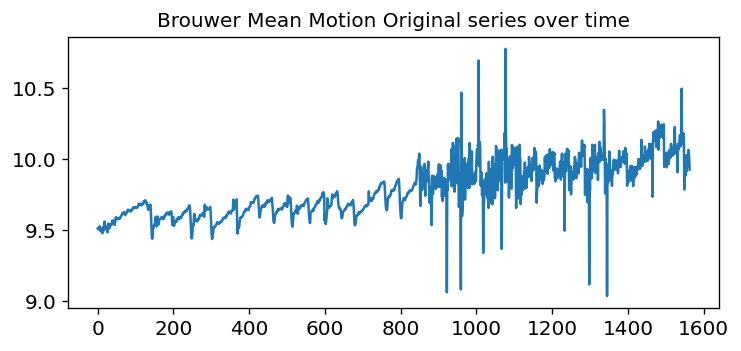

In [154]:
# Scale ['Brouwer mean motion'] to larger numbers
pd_df_Hai2A_bmm=pd_df_Hai2A_UnProp_train[['TimeStamp', 'Brouwer Mean Motion']]

pd_df_Hai2A_bmm['Brouwer Mean Motion'] = (pd_df_Hai2A_bmm['Brouwer Mean Motion'] - pd_df_Hai2A_bmm['Brouwer Mean Motion'].mean()) * 1000000
print(pd_df_Hai2A_bmm.head())

pd_df_Hai2A_bmm = pd_df_Hai2A_bmm[pd_df_Hai2A_bmm['Brouwer Mean Motion'] <= 15]
pd_df_Hai2A_bmm = pd_df_Hai2A_bmm[pd_df_Hai2A_bmm['Brouwer Mean Motion'] >= 8]

plt.rcParams.update({'figure.figsize':(7,3), 'figure.dpi':120})
plt.plot(pd_df_Hai2A_bmm['Brouwer Mean Motion'])
plt.title('Brouwer Mean Motion Original series over time')
plt.show()

In [155]:
mind=pd_df_Hai2A_bmm.loc[pd_df_Hai2A_bmm['TimeStamp']==pd_df_Hai2A_bmm['TimeStamp'].min(),'TimeStamp']
maxd=pd_df_Hai2A_bmm.loc[pd_df_Hai2A_bmm['TimeStamp']==pd_df_Hai2A_bmm['TimeStamp'].max(),'TimeStamp']
print(mind,maxd)

0   2011-10-08 03:08:31.065504
Name: TimeStamp, dtype: datetime64[ns] 1563   2016-03-16 05:42:31.336415
Name: TimeStamp, dtype: datetime64[ns]


## 6.3 Propagate elements

In [49]:
(pd_df_Hai2A_bmm_Arima_pred,dec_Hai2A_bmm_Arima_pred_RMSE, dec_Hai2A_bmm_Arima_pred_AIC, dec_Hai2A_bmm_Arima_pred_BIC
)=Fit_Predict_Arima(pd_df_Hai2A_bmm,'Brouwer Mean Motion',1,1,1)


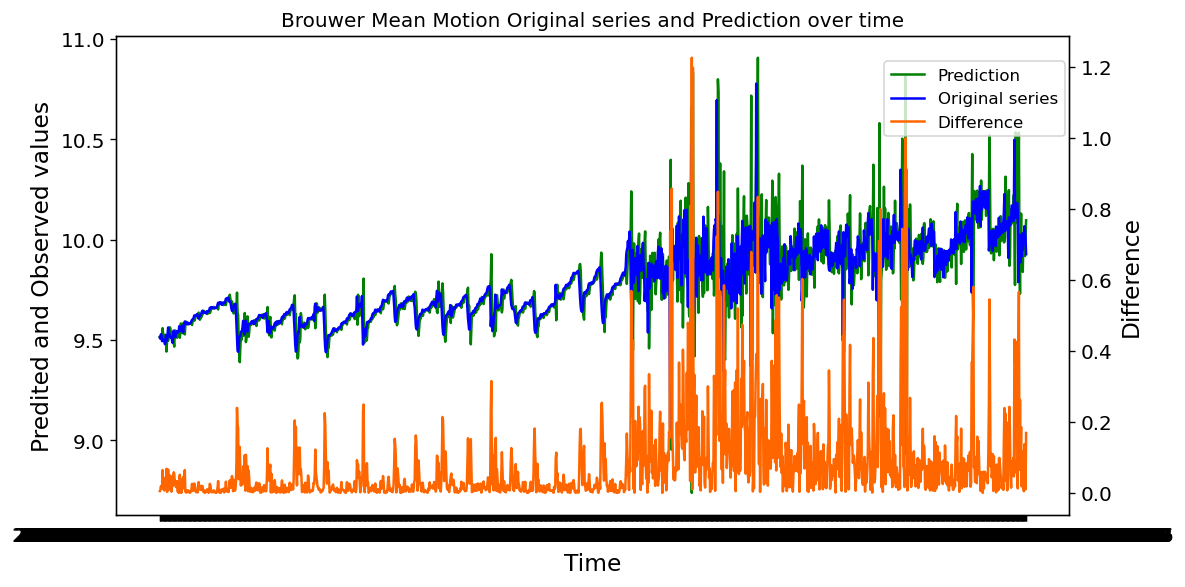

In [156]:
# evaluate forecasts
pd_df_Hai2A_bmm_Arima_pred['Difference']=abs(pd_df_Hai2A_bmm_Arima_pred['Prediction']-pd_df_Hai2A_bmm_Arima_pred['Observed'])
# print('RMSE: %.3f' % dec_Hai2A_bmm_Arima_pred_RMSE)
# print('AIC: %.3f' % dec_Hai2A_bmm_Arima_pred_AIC)
# print('BIC: %.3f' % dec_Hai2A_bmm_Arima_pred_BIC)

# pd_df_Hai2A_GrdTrth=data[['Satellite','Start Date','End Date']]

# plot forecasts against actual outcomes
x=pd_df_Hai2A_bmm_Arima_pred['TimeStamp']
y1=pd_df_Hai2A_bmm_Arima_pred['Prediction']
y2=pd_df_Hai2A_bmm_Arima_pred['Observed']
y3=pd_df_Hai2A_bmm_Arima_pred['Difference']

fig, ax = plt.subplots(figsize = (10, 5))
plt.title('Brouwer Mean Motion Original series and Prediction over time')
 
ax2 = ax.twinx()
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))
 
ax.set_xlabel('Time')
ax.set_ylabel('Predited and Observed values')
ax2.set_ylabel('Difference')
 
plt.tight_layout()
fig.legend(['Prediction','Original series','Difference'], loc='upper right', bbox_to_anchor=(0.9, 0.9))
 
# show plot
plt.show()


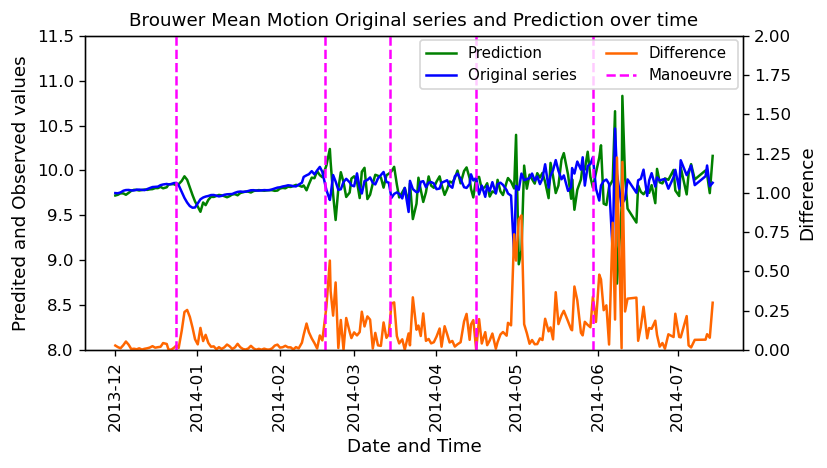

In [193]:
pd_df_Hai2A_bmm_Arima_pred['TimeStamp'] = pd.to_datetime(pd_df_Hai2A_bmm_Arima_pred['TimeStamp'])
pd_df_Hai2A_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Hai2A_GrdTrth['Start Date'])

# Define the start and end date for the filter
start_date = '2013-12-01'
end_date = '2014-07-15'

# Filter the DataFrame for rows where 'TimeStamp' is within the first few months of 2012
subset = pd_df_Hai2A_bmm_Arima_pred[
    (pd_df_Hai2A_bmm_Arima_pred['TimeStamp'] >= start_date) &
    (pd_df_Hai2A_bmm_Arima_pred['TimeStamp'] <= end_date)]
GrdTrth = pd_df_Hai2A_GrdTrth[
    (pd_df_Hai2A_GrdTrth['Start Date'] >= start_date) &
    (pd_df_Hai2A_GrdTrth['Start Date'] <= end_date)]

# plot forecasts against actual outcomes
x=subset['TimeStamp']
y1=subset['Prediction']
y2=subset['Observed']
y3=subset['Difference']

fig, ax = plt.subplots(figsize = (7, 4))
plt.title('Brouwer Mean Motion Original series and Prediction over time', fontsize = 11)

ax.tick_params(axis='x', labelrotation=90, labelsize=10)
ax.tick_params(axis='y', labelsize=10)

ax2 = ax.twinx()
ax2.tick_params(axis='y', labelsize=10)
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))

xcoords = GrdTrth['Start Date']
for xc in xcoords:
    plt.axvline(x=xc,color='magenta',label="Manoeuvre",linestyle='dashed')
 
ax.set_xlabel('Date and Time', fontsize = 11)
ax.set_ylabel('Predited and Observed values', fontsize = 11)
ax2.set_ylabel('Difference', fontsize = 11)

ax.set_ylim(8, 11.5)
ax2.set_ylim(0, 2)

plt.tight_layout()
fig.legend(['Prediction','Original series','Difference','Manoeuvre'], loc='upper right', 
           bbox_to_anchor=(0.895, 0.92), fontsize = 9, ncol=2)
 
# show plot
plt.show()

## 6.4 Find optimal p,d,q for Brouwer Mean Motion

In [159]:
# Define the values for p, d, and q
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]

# Generate all combinations of p, d, q
combinations = list(product(p_values, d_values, q_values))

# Create a DataFrame from the combinations
pd_df_combos = pd.DataFrame(combinations, columns=['p', 'd', 'q'])


In [103]:
pd_df_Hai2A_best_metrics = pd.DataFrame(columns=['Model (p,d,q)', 'RMSE', 'AIC','BIC'])

for index,row in pd_df_combos.iterrows():
    p = row['p']
    d = row['d']
    q = row['q']
    print(p,d,q)
        
    (output,RMSE, AIC, BIC)=Fit_Predict_Arima(pd_df_Hai2A_bmm,'Brouwer Mean Motion',p,d,q)
    
    pd_df_Hai2A_best_metrics = pd_df_Hai2A_best_metrics.append({'Model (p,d,q)': 'Model - ('+ str(p) +',' + str(d) +','+ str(q)+ ')',
                'RMSE': RMSE, 'AIC': AIC, 'BIC': BIC}, ignore_index=True)
#     print(pd_df_Hai2A_best_metrics)

print(pd_df_Hai2A_best_metrics)
        
    

In [104]:
#  Choose Best

best_Hai2A_rmse_model = pd_df_Hai2A_best_metrics.loc[pd_df_Hai2A_best_metrics['RMSE']==pd_df_Hai2A_best_metrics['RMSE'].min(),'Model (p,d,q)']
best_Hai2A_aic_model = pd_df_Hai2A_best_metrics.loc[pd_df_Hai2A_best_metrics['AIC']==pd_df_Hai2A_best_metrics['AIC'].min(),'Model (p,d,q)']
best_Hai2A_bic_model = pd_df_Hai2A_best_metrics.loc[pd_df_Hai2A_best_metrics['BIC']==pd_df_Hai2A_best_metrics['BIC'].min(),'Model (p,d,q)']

print('Best model by RMSE: '+best_Hai2A_rmse_model)
print('Best model by AIC: '+best_Hai2A_aic_model)
print('Best model by BIC: '+best_Hai2A_bic_model)


## 6.5 Propagate elements for best p,d,q

In [28]:
(pd_df_Hai2A_bmm_Arima_pred,dec_Hai2A_bmm_Arima_pred_RMSE, dec_Hai2A_bmm_Arima_pred_AIC, dec_Hai2A_bmm_Arima_pred_BIC
)=Fit_Predict_Arima(pd_df_Hai2A_bmm,'Brouwer Mean Motion',2,0,0)



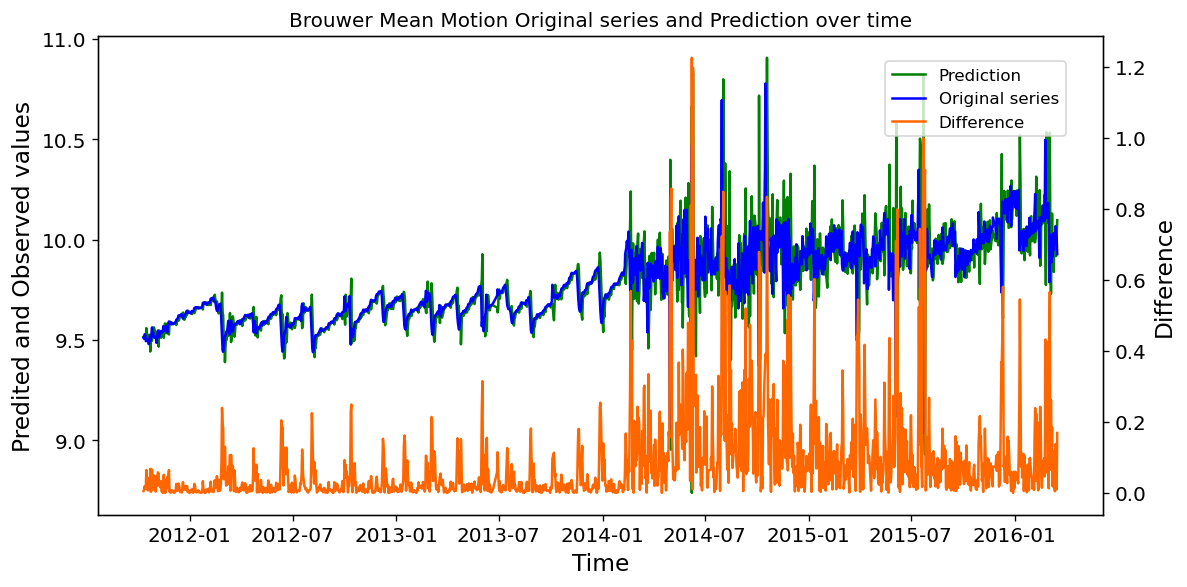

In [160]:
# evaluate forecasts
# pd_df_Hai2A_bmm_Arima_pred['Difference']=abs(pd_df_Hai2A_bmm_Arima_pred['Prediction']-pd_df_Hai2A_bmm_Arima_pred['Observed'])
# print('RMSE: %.3f' % dec_Hai2A_bmm_Arima_pred_RMSE)
# print('AIC: %.3f' % dec_Hai2A_bmm_Arima_pred_AIC)
# print('BIC: %.3f' % dec_Hai2A_bmm_Arima_pred_BIC)

# pd_df_Hai2A_GrdTrth=data[['Satellite','Start Date','End Date']]

# plot forecasts against actual outcomes
x=pd_df_Hai2A_bmm_Arima_pred['TimeStamp']
y1=pd_df_Hai2A_bmm_Arima_pred['Prediction']
y2=pd_df_Hai2A_bmm_Arima_pred['Observed']
y3=pd_df_Hai2A_bmm_Arima_pred['Difference']

fig, ax = plt.subplots(figsize = (10, 5))
plt.title('Brouwer Mean Motion Original series and Prediction over time')
 
ax2 = ax.twinx()
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))
 
ax.set_xlabel('Time')
ax.set_ylabel('Predited and Observed values')
ax2.set_ylabel('Difference')
 
plt.tight_layout()
fig.legend(['Prediction','Original series','Difference'], loc='upper right', bbox_to_anchor=(0.9, 0.9))
 
# show plot
plt.show()


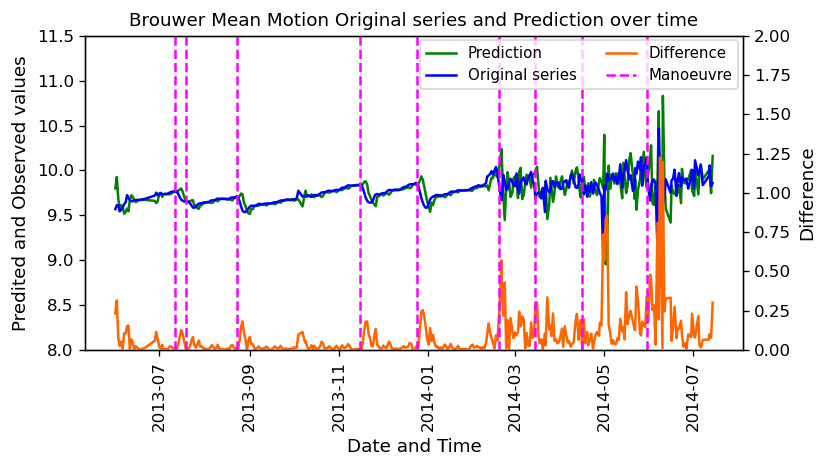

In [194]:
pd_df_Hai2A_bmm_Arima_pred['TimeStamp'] = pd.to_datetime(pd_df_Hai2A_bmm_Arima_pred['TimeStamp'])
pd_df_Hai2A_GrdTrth['Start Date'] = pd.to_datetime(pd_df_Hai2A_GrdTrth['Start Date'])

# Define the start and end date for the filter
start_date = '2013-06-01'
end_date = '2014-07-15'

# Filter the DataFrame for rows where 'TimeStamp' is within the first few months of 2012
subset = pd_df_Hai2A_bmm_Arima_pred[
    (pd_df_Hai2A_bmm_Arima_pred['TimeStamp'] >= start_date) &
    (pd_df_Hai2A_bmm_Arima_pred['TimeStamp'] <= end_date)]
GrdTrth = pd_df_Hai2A_GrdTrth[
    (pd_df_Hai2A_GrdTrth['Start Date'] >= start_date) &
    (pd_df_Hai2A_GrdTrth['Start Date'] <= end_date)]

# plot forecasts against actual outcomes
x=subset['TimeStamp']
y1=subset['Prediction']
y2=subset['Observed']
y3=subset['Difference']

fig, ax = plt.subplots(figsize = (7, 4))
plt.title('Brouwer Mean Motion Original series and Prediction over time', fontsize = 11)

ax.tick_params(axis='x', labelrotation=90, labelsize=10)
ax.tick_params(axis='y', labelsize=10)

ax2 = ax.twinx()
ax2.tick_params(axis='y', labelsize=10)
ax.plot(x, y1, color = 'green')
ax.plot(x, y2, color='blue')
ax2.plot(x, y3, color = (1,0.4,0))

xcoords = GrdTrth['Start Date']
for xc in xcoords:
    plt.axvline(x=xc,color='magenta',label="Manoeuvre",linestyle='dashed')
 
ax.set_xlabel('Date and Time', fontsize = 11)
ax.set_ylabel('Predited and Observed values', fontsize = 11)
ax2.set_ylabel('Difference', fontsize = 11)

ax.set_ylim(8, 11.5)
ax2.set_ylim(0, 2)

plt.tight_layout()
fig.legend(['Prediction','Original series','Difference','Manoeuvre'], loc='upper right', 
           bbox_to_anchor=(0.895, 0.92), fontsize = 9, ncol=2)
 
# show plot
plt.show()

## 6.6 Highlight Anomalies for best p,d,q

In [163]:
# Determine Threshold value

s=pd_df_Hai2A_bmm_Arima_pred['Difference']

# Define the threshold values
pd_lst_quan = [0.05, 0.5, 0.75, 0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

# Calculate the quantile threshold values
pd_lst_thres = s.quantile(pd_lst_quan)

# Calculate the count of data points above each threshold value
pd_lst_counts = [(s > threshold).sum() for threshold in pd_lst_thres]

# Create a DataFrame with the quantiles, threshold values, and counts
pd_df_thresh = pd.DataFrame({
    'Quantile': pd_lst_quan,
    'Threshold Value': pd_lst_thres.values,
    'Count': pd_lst_counts})
print(pd_df_thresh)



    Quantile  Threshold Value  Count
0       0.05         0.001829   1482
1       0.50         0.032744    780
2       0.75         0.100645    390
3       0.80         0.119926    312
4       0.85         0.154116    234
5       0.90         0.202649    156
6       0.91         0.215932    141
7       0.92         0.233302    125
8       0.93         0.258306    110
9       0.94         0.286486     94
10      0.95         0.325958     78
11      0.96         0.367612     63
12      0.97         0.431082     47
13      0.98         0.548987     32
14      0.99         0.709183     16


In [164]:
# choose threshold
threshold = pd_df_thresh.loc[pd_df_thresh['Quantile'] == 0.94, 'Threshold Value'].values[0]
print(threshold)

pd_df_Hai2A_bmm_Arima_anom = detect_anomalies(pd_df_Hai2A_bmm_Arima_pred, threshold)

# pd_df_Hai2A_bmm_Arima_anom.iloc[220:270]

0.28648565203500054


In [165]:
# Add Manoeuvre column to show the ground truth manoevres (with a 3 day gray area)
pd_df_Hai2A_bmm_Arima_anom['Manoeuvre'] = 'No'

# Iterate over the Hai2A_GrdTrth DataFrame and update pd_df_Hai2A_bmm_Arima_anom['Manoeuvre']
for _, row in pd_df_Hai2A_GrdTrth.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']
    
    # for each row in pd_df_Hai2A_bmm_Arima_anom, calculate a boolean called in_gray_zone and 
    # set it to True if it is within 1 day of the start time or within 3 days of the finish time of a logged Manoeuvre
    in_gray_zone = (
        (pd_df_Hai2A_bmm_Arima_anom['TimeStamp'] >= (start_date + pd.Timedelta(days=2))) & 
        (pd_df_Hai2A_bmm_Arima_anom['TimeStamp'] <= (end_date + pd.Timedelta(days=4)))
    )
    
    # Update the 'Manoeuvre' column to 'Yes' if in_gray_zone is True
    pd_df_Hai2A_bmm_Arima_anom.loc[in_gray_zone, 'Manoeuvre'] = 'Yes'

    
test=pd_df_Hai2A_bmm_Arima_anom[['TimeStamp','Difference', 'Anomaly','Manoeuvre']]

for x in range(0,20):
    subset=test[50*x:50*(x+1)]
    print(subset)


                    TimeStamp  Difference Anomaly Manoeuvre
0  2011-10-11 02:31:15.109536    0.005250      No        No
1  2011-10-12 02:53:38.975135    0.008180      No        No
2  2011-10-13 01:31:35.329439    0.018805      No        No
3  2011-10-14 01:53:59.128512    0.012335      No        No
4  2011-10-15 04:00:50.395679    0.014983      No        No
5  2011-10-16 02:38:46.803552    0.064421      No        No
6  2011-10-17 01:16:43.221792    0.020086      No        No
7  2011-10-18 05:08:01.803264    0.009501      No        No
8  2011-10-19 02:01:30.811295    0.006873      No        No
9  2011-10-20 04:08:22.086240    0.024121      No        No
10 2011-10-21 02:46:18.464735    0.042472      No        No
11 2011-10-22 13:35:26.724191    0.025464      No        No
12 2011-10-23 01:46:38.640576    0.067801      No        No
13 2011-10-24 02:09:02.497536    0.002964      No        No
14 2011-10-25 04:15:53.748288    0.020747      No        No
15 2011-10-26 02:53:50.044704    0.06563

449 2013-01-03 03:20:57.592607    0.002655      No        No
                     TimeStamp  Difference Anomaly Manoeuvre
450 2013-01-04 03:43:21.103103    0.011106      No        No
451 2013-01-05 02:21:17.251775    0.007490      No        No
452 2013-01-06 04:28:08.177664    0.004090      No        No
453 2013-01-07 04:50:31.676928    0.007534      No        No
454 2013-01-08 03:28:27.797087    0.023692      No        No
455 2013-01-09 03:50:51.318815    0.013939      No        No
456 2013-01-10 04:13:14.844863    0.003339      No        No
457 2013-01-11 04:35:38.328575    0.009270      No        No
458 2013-01-12 18:53:41.055072    0.030683      No        No
459 2013-01-13 03:35:58.162272    0.035544      No       Yes
460 2013-01-14 02:13:54.496704    0.128206      No       Yes
461 2013-01-15 02:36:18.256032    0.161817      No       Yes
462 2013-01-16 02:58:41.992032    0.143263      No        No
463 2013-01-17 01:36:38.283264    0.068754      No        No
464 2013-01-18 01:59:01.

                     TimeStamp  Difference Anomaly Manoeuvre
700 2013-09-21 01:31:36.486336    0.010591      No        No
701 2013-09-22 01:54:00.065087    0.025110      No        No
702 2013-09-23 02:16:23.664576    0.009263      No        No
703 2013-09-24 02:38:47.281343    0.005825      No        No
704 2013-09-25 01:16:43.461120    0.005645      No        No
705 2013-09-26 01:39:07.044191    0.007041      No        No
706 2013-09-27 02:01:30.617760    0.006054      No        No
707 2013-09-28 11:06:11.240640    0.005254      No        No
708 2013-09-29 04:30:45.222624    0.007699      No        No
709 2013-09-30 04:53:08.780640    0.000271      No        No
710 2013-10-01 03:31:04.954367    0.016931      No        No
711 2013-10-02 03:53:28.529664    0.010419      No        No
712 2013-10-03 04:15:52.073855    0.015866      No        No
713 2013-10-04 04:38:15.470304    0.096906      No        No
714 2013-10-07 00:32:04.039871    0.113289      No        No
715 2013-10-08 20:03:28.

                     TimeStamp  Difference Anomaly Manoeuvre
900 2014-04-11 12:29:43.541375    0.180671      No        No
901 2014-04-12 11:07:39.508608    0.228734      No        No
902 2014-04-13 14:58:57.789408    0.063447      No        No
903 2014-04-14 03:10:09.259968    0.162017      No        No
904 2014-04-15 00:03:37.898207    0.189327      No        No
905 2014-04-16 02:10:28.425792    0.000010      No        No
906 2014-04-17 04:17:19.517568    0.195626      No        No
907 2014-04-18 04:39:43.079903    0.040102      No       Yes
908 2014-04-19 11:59:56.338368    0.112432      No       Yes
909 2014-04-20 05:24:30.279744    0.029363      No        No
910 2014-04-21 04:02:26.563199    0.059049      No        No
911 2014-04-22 04:24:50.072831    0.103670      No        No
912 2014-04-23 11:45:03.328704    0.006882      No        No
913 2014-04-24 03:25:09.853823    0.048623      No        No
914 2014-04-25 05:32:00.686400    0.097723      No        No
915 2014-04-26 04:09:56.

C:\Users\aloci\AppData\Local\Temp\ipykernel_4888\2439854499.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['anomaly_bin'] = df['Anomaly'].map({'Yes': 1, 'No': 0})
C:\Users\aloci\AppData\Local\Temp\ipykernel_4888\2439854499.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['manoeuvre_bin'] = df['Manoeuvre'].map({'Yes': 1, 'No': 0})


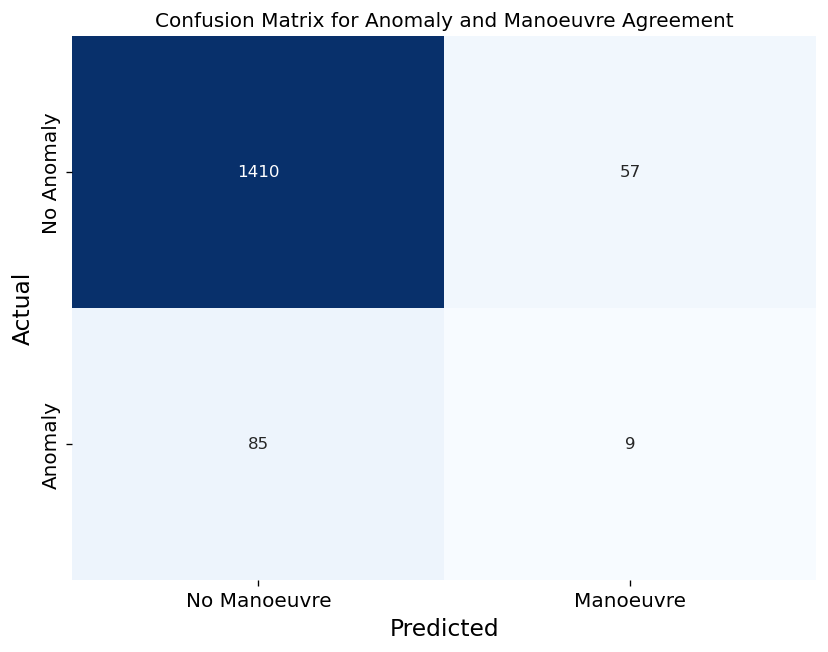

In [166]:
df=pd_df_Hai2A_bmm_Arima_anom[['TimeStamp','Anomaly','Manoeuvre']]

# Convert 'yes'/'no' to binary values
df['anomaly_bin'] = df['Anomaly'].map({'Yes': 1, 'No': 0})
df['manoeuvre_bin'] = df['Manoeuvre'].map({'Yes': 1, 'No': 0})

# Create confusion matrix
cm = confusion_matrix(df['anomaly_bin'], df['manoeuvre_bin'])

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=['No Anomaly', 'Anomaly'], columns=['No Manoeuvre', 'Manoeuvre'])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sb.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Anomaly and Manoeuvre Agreement')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [327]:
# Define the values for data Dump
elements=['bmm','ecc','aop','ma','inc','ra']
RMSE_values = [dec_Cryo_bmm_Arima_pred_RMSE, dec_Cryo_ecc_Arima_pred_RMSE, dec_Cryo_aop_Arima_pred_RMSE,
              dec_Cryo_ma_Arima_pred_RMSE,dec_Cryo_inc_Arima_pred_RMSE,dec_Cryo_ra_Arima_pred_RMSE]
AIC_values = [dec_Cryo_bmm_Arima_pred_AIC, dec_Cryo_ecc_Arima_pred_AIC, dec_Cryo_aop_Arima_pred_AIC,
              dec_Cryo_ma_Arima_pred_AIC,dec_Cryo_inc_Arima_pred_AIC,dec_Cryo_ra_Arima_pred_AIC]
BIC_values = [dec_Cryo_bmm_Arima_pred_BIC, dec_Cryo_ecc_Arima_pred_BIC, dec_Cryo_aop_Arima_pred_BIC,
              dec_Cryo_ma_Arima_pred_BIC,dec_Cryo_inc_Arima_pred_BIC,dec_Cryo_ra_Arima_pred_BIC]

# Create a DataFrame 
data= {'Element': elements,'RMSE': RMSE_values,'AIC': AIC_values,'BIC': BIC_values}

Cryo_Metrics_1_1_1 = pd.DataFrame(data)
print(Cryo_Metrics_1_1_1)

  Element      RMSE        AIC        BIC
0     bmm  7.179722  -8.712601 -12.318152
1     ecc  0.112328  -5.706613  -9.627172
2     aop  0.648067   1.233771  -2.686787
3      ma  0.859005   1.233970  -2.686589
4     inc  0.000006 -34.554833 -38.475392
5      ra  0.165823 -12.332106 -16.252664


In [328]:
# Dump data for easy future work without rerunning slow code

# Write the dataframe to a CSV file
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_bmm.csv'
pd_df_Cryo_bmm.to_csv(file_path, index=False)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_ecc.csv'
pd_df_Cryo_ecc.to_csv(file_path, index=False)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_aop.csv'
pd_df_Cryo_aop.to_csv(file_path, index=False)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_ma.csv'
pd_df_Cryo_ma.to_csv(file_path, index=False)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_inc.csv'
pd_df_Cryo_inc.to_csv(file_path, index=False)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_ra.csv'
pd_df_Cryo_ra.to_csv(file_path, index=False)

file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_bmm_Arima_pred.csv'
pd_df_Cryo_bmm_Arima_pred.to_csv(file_path, index=False)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_ecc_Arima_pred.csv'
pd_df_Cryo_ecc_Arima_pred.to_csv(file_path, index=False)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_aop_Arima_pred.csv'
pd_df_Cryo_aop_Arima_pred.to_csv(file_path, index=False)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_ma_Arima_pred.csv'
pd_df_Cryo_ma_Arima_pred.to_csv(file_path, index=False)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_inc_Arima_pred.csv'
pd_df_Cryo_inc_Arima_pred.to_csv(file_path, index=False)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_ra_Arima_pred.csv'
pd_df_Cryo_ra_Arima_pred.to_csv(file_path, index=False)

file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_bmm_Arima_anom.csv'
pd_df_Cryo_bmm_Arima_anom.to_csv(file_path, index=False)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_ecc_Arima_anom.csv'
pd_df_Cryo_ecc_Arima_anom.to_csv(file_path, index=False)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_aop_Arima_anom.csv'
pd_df_Cryo_aop_Arima_anom.to_csv(file_path, index=False)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_ma_Arima_anom.csv'
pd_df_Cryo_ma_Arima_anom.to_csv(file_path, index=False)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_inc_Arima_anom.csv'
pd_df_Cryo_inc_Arima_anom.to_csv(file_path, index=False)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_ra_Arima_anom.csv'
pd_df_Cryo_ra_Arima_anom.to_csv(file_path, index=False)

file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\Cryo_Metrics_1_1_1.csv'
Cryo_Metrics_1_1_1.to_csv(file_path, index=False)

file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Jas1_bmm.csv'
pd_df_Jas1_bmm.to_csv(file_path, index=False)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Jas1_bmm_Arima_pred.csv'
pd_df_Jas1_bmm_Arima_pred.to_csv(file_path, index=False)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Jas1_bmm_Arima_anom.csv'
pd_df_Jas1_bmm_Arima_anom.to_csv(file_path, index=False)

file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Sen3A_bmm.csv'
pd_df_Sen3A_bmm.to_csv(file_path, index=False)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Sen3A_bmm_Arima_pred.csv'
pd_df_Sen3A_bmm_Arima_pred.to_csv(file_path, index=False)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Sen3A_bmm_Arima_anom.csv'
pd_df_Sen3A_bmm_Arima_anom.to_csv(file_path, index=False)

file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Hai2A_bmm.csv'
pd_df_Hai2A_bmm.to_csv(file_path, index=False)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Hai2A_bmm_Arima_pred.csv'
pd_df_Hai2A_bmm_Arima_pred.to_csv(file_path, index=False)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Hai2A_bmm_Arima_anom.csv'
pd_df_Hai2A_bmm_Arima_anom.to_csv(file_path, index=False)

file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Fen2F_bmm.csv'
pd_df_Fen2F_bmm.to_csv(file_path, index=False)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Fen2F_bmm_Arima_pred.csv'
pd_df_Fen2F_bmm_Arima_pred.to_csv(file_path, index=False)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Fen2F_bmm_Arima_anom.csv'
pd_df_Fen2F_bmm_Arima_anom.to_csv(file_path, index=False)


In [141]:
# pull in dumped data
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_bmm.csv'

pd_df_Cryo_bmm = pd.read_csv(file_path,parse_dates=True)

# Write the dataframe to a CSV file
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_bmm.csv'
pd_df_Cryo_bmm = pd.read_csv(file_path,parse_dates=True)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_ecc.csv'
pd_df_Cryo_ecc = pd.read_csv(file_path,parse_dates=True)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_aop.csv'
pd_df_Cryo_aop = pd.read_csv(file_path,parse_dates=True)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_ma.csv'
pd_df_Cryo_ma = pd.read_csv(file_path,parse_dates=True)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_inc.csv'
pd_df_Cryo_inc = pd.read_csv(file_path,parse_dates=True)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_ra.csv'
pd_df_Cryo_ra = pd.read_csv(file_path,parse_dates=True)

file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_bmm_Arima_pred.csv'
pd_df_Cryo_bmm_Arima_pred = pd.read_csv(file_path,parse_dates=True)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_ecc_Arima_pred.csv'
pd_df_Cryo_ecc_Arima_pred = pd.read_csv(file_path,parse_dates=True)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_aop_Arima_pred.csv'
pd_df_Cryo_aop_Arima_pred = pd.read_csv(file_path,parse_dates=True)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_ma_Arima_pred.csv'
pd_df_Cryo_ma_Arima_pred = pd.read_csv(file_path,parse_dates=True)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_inc_Arima_pred.csv'
pd_df_Cryo_inc_Arima_pred = pd.read_csv(file_path,parse_dates=True)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_ra_Arima_pred.csv'
pd_df_Cryo_ra_Arima_pred = pd.read_csv(file_path,parse_dates=True)

file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_bmm_Arima_anom.csv'
pd_df_Cryo_bmm_Arima_anom = pd.read_csv(file_path,parse_dates=True)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_ecc_Arima_anom.csv'
pd_df_Cryo_ecc_Arima_anom = pd.read_csv(file_path,parse_dates=True)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_aop_Arima_anom.csv'
pd_df_Cryo_aop_Arima_anom = pd.read_csv(file_path,parse_dates=True)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_ma_Arima_anom.csv'
pd_df_Cryo_ma_Arima_anom = pd.read_csv(file_path,parse_dates=True)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_inc_Arima_anom.csv'
pd_df_Cryo_inc_Arima_anom = pd.read_csv(file_path,parse_dates=True)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Cryo_ra_Arima_anom.csv'
pd_df_Cryo_ra_Arima_anom = pd.read_csv(file_path,parse_dates=True)

file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\Cryo_Metrics_1_1_1.csv'
Cryo_Metrics_1_1_1 = pd.read_csv(file_path,parse_dates=True)

file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Jas1_bmm.csv'
pd_df_Jas1_bmm = pd.read_csv(file_path,parse_dates=True)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Jas1_bmm_Arima_pred.csv'
pd_df_Jas1_bmm_Arima_pred = pd.read_csv(file_path,parse_dates=True)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Jas1_bmm_Arima_anom.csv'
pd_df_Jas1_bmm_Arima_anom = pd.read_csv(file_path,parse_dates=True)

file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Sen3A_bmm.csv'
pd_df_Sen3A_bmm= pd.read_csv(file_path,parse_dates=True)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Sen3A_bmm_Arima_pred.csv'
pd_df_Sen3A_bmm_Arima_pred= pd.read_csv(file_path,parse_dates=True)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Sen3A_bmm_Arima_anom.csv'
pd_df_Sen3A_bmm_Arima_anom= pd.read_csv(file_path,parse_dates=True)

file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Hai2A_bmm.csv'
pd_df_Hai2A_bmm= pd.read_csv(file_path,parse_dates=True)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Hai2A_bmm_Arima_pred.csv'
pd_df_Hai2A_bmm_Arima_pred= pd.read_csv(file_path,parse_dates=True)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Hai2A_bmm_Arima_anom.csv'
pd_df_Hai2A_bmm_Arima_anom= pd.read_csv(file_path,parse_dates=True)

file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Fen2F_bmm.csv'
pd_df_Fen2F_bmm= pd.read_csv(file_path,parse_dates=True)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Fen2F_bmm_Arima_pred.csv'
pd_df_Fen2F_bmm_Arima_pred= pd.read_csv(file_path,parse_dates=True)
file_path = r'C:\Users\aloci\Desktop\Data science application\Maths7097 - project\data\Project dumps\pd_df_Fen2F_bmm_Arima_anom.csv'
pd_df_Fen2F_bmm_Arima_anom= pd.read_csv(file_path,parse_dates=True)